<pre style="color:#D00000;text-align:center;font-size:150%;font-weight:bold;font-family:Helvetica;background-color:#F9E4D0;border-style: solid;  border-color: coral; border-width: 1px;">
Portuguese Bank Marketing Campaign Analysis & Prediction
</pre>


 **Domain Perspective**

- Industry: The project is focused on the Finance/Banking sector, specifically looking at how a bank can improve its marketing campaigns for term deposit subscriptions.
  
- Problem Statement: The goal is to analyze customer data from a direct phone call marketing campaign aimed at promoting term deposits. The task is to predict customer behavior (whether they will subscribe to a term deposit) and offer suggestions to the marketing team to increase future subscriptions.

- Objective: The project has three main objectives: 
  1. Perform a data analysis to understand customer patterns.
  2. Build a predictive model to forecast which customers are likely to subscribe to a term deposit.
  3. Provide marketing Recommendations, Model Comparison and Challenges faced report to improve customer engagement.

- Target Audience: The target audience for this marketing campaign is existing customers of a Portuguese bank, reached out via direct phone calls from May 2008 to November 2010.

 **Data Perspective**

- Data Source: The dataset contains information from the bank’s marketing campaigns. It includes data about direct phone calls made to existing customers between 2008 and 2010. and used bank-additional-full.csv for this use case. 

- Variables: The dataset contains a variety of features, such as:
  - Demographic information (age, job, marital status, education).
  - Loan and credit details (housing loan, personal loan).
  - Campaign-related data (contact type, contact duration, previous campaign outcomes).
  - Economic context indicators (employment rate, consumer price index).

- Target Variable: The primary target variable is y, which indicates whether a customer subscribed to a term deposit ("yes" or "no").

- Input Variables: The dataset includes both categorical variables (e.g., job type, marital status, education level) and numerical variables (e.g., age, campaign duration, previous contact count). These features will help predict whether a customer subscribes to a term deposit.

---

# Data Analysis 

### Import data

In [1]:
import pandas as pd
data = pd.read_csv(r"D:\datamites\ProtugeseBank\data\1.1 raw\bank-additional\bank-additional-full.csv", sep=';')

In [2]:
from tabulate import tabulate
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

### Imports & functions

In [3]:
from insightfulpy.eda import *

In [4]:
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#import dtale
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, pearsonr, spearmanr, ttest_ind, mannwhitneyu, shapiro
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, learning_curve
)
from sklearn.preprocessing import (
     LabelEncoder, OneHotEncoder,
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, compute_class_weight

In [5]:
import time
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, 
    AdaBoostClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, 
    roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

---

In [6]:
import psutil
import os
import gc

def memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / 1024 ** 2:.2f} MB")

def dataframe_memory_usage(df):
    mem_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"DataFrame Memory Usage: {mem_usage:.2f} MB")
    return mem_usage

def garbage_collection():
    gc.collect()
    memory_usage()

In [7]:
if __name__ == "__main__":
    memory_usage()

Memory Usage: 294.79 MB


In [8]:
dataframe_memory_usage(data)

DataFrame Memory Usage: 30.26 MB


30.260939598083496

----

In [9]:
def chi_square_test(data, target_col='y'):
    chi_square_results = {}
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns.tolist()    
    for col in categorical_vars:
        if col == target_col:
            continue        
        contingency_table = pd.crosstab(data[col], data[target_col])        
        if contingency_table.shape != (2, 2):
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            if (expected >= 5).all():
                chi_square_results[col] = p_value
                print(f"- {col} (Chi-Square Test): p-value = {p_value:.4f}")    
    return chi_square_results
def fisher_exact_test(data, target_col='y'):
    fisher_exact_results = {}
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns.tolist()   
    for col in categorical_vars:
        if col == target_col:
            continue        
        contingency_table = pd.crosstab(data[col], data[target_col])        
        if contingency_table.shape == (2, 2):
            _, p_value = fisher_exact(contingency_table)
            fisher_exact_results[col] = p_value
            print(f"- {col} (Fisher's Exact Test): p-value = {p_value:.4f}")    
    return fisher_exact_results
def spearman_correlation_with_target(data, non_normal_cols, target_col='TARGET', plot=True, table=True):
    if not pd.api.types.is_numeric_dtype(data[target_col]):
        raise ValueError(f"Target column '{target_col}' must be numeric. Please encode it before running this test.")
    correlation_results = {}
    for col in non_normal_cols:
        if col not in data.columns:
            continue 
        coef, p_value = spearmanr(data[col], data[target_col], nan_policy='omit')
        correlation_results[col] = {'Spearman Coefficient': coef, 'p-value': p_value}
    correlation_data = pd.DataFrame(correlation_results).T.dropna()
    correlation_data = correlation_data.sort_values('Spearman Coefficient', ascending=False)
    if target_col in correlation_data.index:
        correlation_data = correlation_data.drop(target_col)
    positive_corr = correlation_data[correlation_data['Spearman Coefficient'] > 0]
    negative_corr = correlation_data[correlation_data['Spearman Coefficient'] < 0]
    if table:
        print(f"\nPositive Spearman Correlations with Target ('{target_col}'):\n")
        for feature, stats in positive_corr.iterrows():
            print(f"- {feature}: Correlation={stats['Spearman Coefficient']:.4f}, p-value={stats['p-value']:.4f}")
        print(f"\nNegative Spearman Correlations with Target ('{target_col}'):\n")
        for feature, stats in negative_corr.iterrows():
            print(f"- {feature}: Correlation={stats['Spearman Coefficient']:.4f}, p-value={stats['p-value']:.4f}")
    if plot:
        plt.figure(figsize=(20, 8))  # Increase figure width to prevent label overlap
        sns.barplot(x=correlation_data.index, y='Spearman Coefficient', data=correlation_data, palette='coolwarm')
        plt.axhline(0, color='black', linestyle='--')
        plt.title(f"Spearman Correlation with Target ('{target_col}')", fontsize=16)
        plt.xlabel("Features", fontsize=14)
        plt.ylabel("Spearman Coefficient", fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # labels for clarity
        plt.subplots_adjust(bottom=0.3)  # Add space below the plot for labels
        plt.tight_layout()
        plt.show()
    return correlation_data
def hypothesis_testing_mann_whitney(data, non_normal_cols, target_col='y'):
    results = {}
    group_no = data[data[target_col] == 0]
    group_yes = data[data[target_col] == 1]
    print(f"\nMann-Whitney U Test Results Between Non-Normal Numerical Variables and Target ('{target_col}'):\n")
    for col in non_normal_cols:
        stat, p_value = mannwhitneyu(group_no[col].dropna(), group_yes[col].dropna(), alternative='two-sided')
        results[col] = {'Mann-Whitney U Statistic': stat, 'p-value': p_value}
        print(f"- {col}: U-Statistic = {stat:.4f}, p-value = {p_value:.4f}")
    return results
def cap_outliers_percentile(data, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = data[column].quantile(lower_percentile)
    upper_bound = data[column].quantile(upper_percentile)
    data[column] = np.where(data[column] < lower_bound, lower_bound, 
                            np.where(data[column] > upper_bound, upper_bound, data[column])).astype(data[column].dtype)    
    return
def normality_test_with_skew_kurt(df):
    normal_cols = []
    not_normal_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        col_data = df[col].dropna()
        if len(col_data) >= 3:
            if len(col_data) <= 5000:
                stat, p_value = shapiro(col_data)
                test_used = 'Shapiro-Wilk'
            else:
                stat, p_value = kstest(col_data, 'norm', args=(col_data.mean(), col_data.std()))
                test_used = 'Kolmogorov-Smirnov'
            col_skewness = skew(col_data)
            col_kurtosis = kurtosis(col_data)
            result = {
                'Column': col,
                'Test': test_used,
                'Statistic': stat,
                'p_value': p_value,
                'Skewness': col_skewness,
                'Kurtosis': col_kurtosis
            }
            if p_value > 0.05:
                normal_cols.append(result)
            else:
                not_normal_cols.append(result)
    normal_df = (
        pd.DataFrame(normal_cols)
        .sort_values(by='Column') 
        if normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    not_normal_df = (
        pd.DataFrame(not_normal_cols)
        .sort_values(by='p_value', ascending=False)  # Sort by p-value descending (near normal to not normal)
        if not_normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    print("\nNormal Columns (p > 0.05):")
    display(normal_df)
    print("\nNot Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:")
    display(not_normal_df)
    return normal_df, not_normal_df
def spearman_correlation(data, non_normal_cols, exclude_target=None, multicollinearity_threshold=0.8):
    if non_normal_cols.empty:
        print("\nNo non-normally distributed numerical columns found. Exiting Spearman Correlation.")
        return
    selected_columns = non_normal_cols['Column'].tolist()
    if exclude_target and exclude_target in selected_columns and pd.api.types.is_numeric_dtype(data[exclude_target]):
        selected_columns.remove(exclude_target)
    spearman_corr_matrix = data[selected_columns].corr(method='spearman')
    multicollinear_pairs = []
    for i, col1 in enumerate(selected_columns):
        for col2 in selected_columns[i+1:]:
            coef = spearman_corr_matrix.loc[col1, col2]
            if abs(coef) > multicollinearity_threshold:
                multicollinear_pairs.append((col1, col2, coef))
    print("\nVariables Exhibiting Multicollinearity (|Correlation| > {:.2f}):".format(multicollinearity_threshold))
    if multicollinear_pairs:
        for col1, col2, coef in multicollinear_pairs:
            print(f"- {col1} & {col2}: Correlation={coef:.4f}")
    else:
        print("No multicollinear pairs found.")
    annot_matrix = spearman_corr_matrix.round(2).astype(str)
    num_vars = len(selected_columns)
    fig_size = max(min(24, num_vars * 1.2), 10)  # Keep reasonable bounds
    annot_font_size = max(min(10, 200 / num_vars), 6)  # Smaller font for more variables
    plt.figure(figsize=(fig_size, fig_size * 0.75))
    sns.heatmap(
        spearman_corr_matrix,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        annot_kws={"size": annot_font_size},
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Spearman Correlation Matrix', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()
def calculate_vif(data, exclude_target='TARGET', multicollinearity_threshold=5.0):
    # Select only numeric columns, exclude target, and drop rows with missing values
    numeric_data = data.select_dtypes(include=[np.number]).drop(columns=[exclude_target], errors='ignore').dropna()
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_data.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) 
                       for i in range(numeric_data.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    high_vif = vif_data[vif_data['VIF'] > multicollinearity_threshold]
    low_vif = vif_data[vif_data['VIF'] <= multicollinearity_threshold]
    print(f"\nVariance Inflation Factor (VIF) Scores (multicollinearity_threshold = {multicollinearity_threshold}):")
    print("\nFeatures with VIF > threshold (High Multicollinearity):")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    else:
        print("None. No features exceed the VIF threshold.")
    print("\nFeatures with VIF <= threshold (Low/No Multicollinearity):")
    if not low_vif.empty:
        print(low_vif.to_string(index=False))
    else:
        print("None. All features exceed the VIF threshold.")
    return vif_data, high_vif['Feature'].tolist()

---

## Data understanding and cleaning

In [10]:
print(data.shape)
for idx, col in enumerate(data.columns):
        print(f"{idx}: {col}")

(41188, 21)
0: age
1: job
2: marital
3: education
4: default
5: housing
6: loan
7: contact
8: month
9: day_of_week
10: duration
11: campaign
12: pdays
13: previous
14: poutcome
15: emp.var.rate
16: cons.price.idx
17: cons.conf.idx
18: euribor3m
19: nr.employed
20: y


In [11]:
data.head().T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed          5191.0       5191.0       5191.0       5191.0   
y                        no           no           no           no   

                          4  
age                      56  
job                services  
marital             married  
education       high.school  
default                  no  
housing                  no  
loan                    yes  
contact           telephone  
month                   may  
day_of_week             mon  
duration                307  
campaign                  1  
pdays                   999  
previous                  0  
poutcome        nonexistent  
emp.var.rate            1.1  
cons.price.idx       93.994  
cons.conf.idx         -36.4  
euribor3m             4.857  
nr.employed          5191.0  
y                        no

In [12]:
detect_mixed_data_types(data)

'No mixed data types detected!'

In [13]:
cat_high_cardinality(data)

high_cardinality_columns


[]

In [14]:
data.replace('unknown', pd.NA, inplace=True)
print(f'Total Missing Percentage: {(data.isnull().sum().sum() / data.size) * 100:.2f}%')

Total Missing Percentage: 1.47%


Missing Values Summary:
          Data Type  Missing Count  Missing Percentage
default      object           8597           20.872584
education    object           1731            4.202680
housing      object            990            2.403613
loan         object            990            2.403613
job          object            330            0.801204
marital      object             80            0.194231

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 12



<Figure size 2000x800 with 0 Axes>

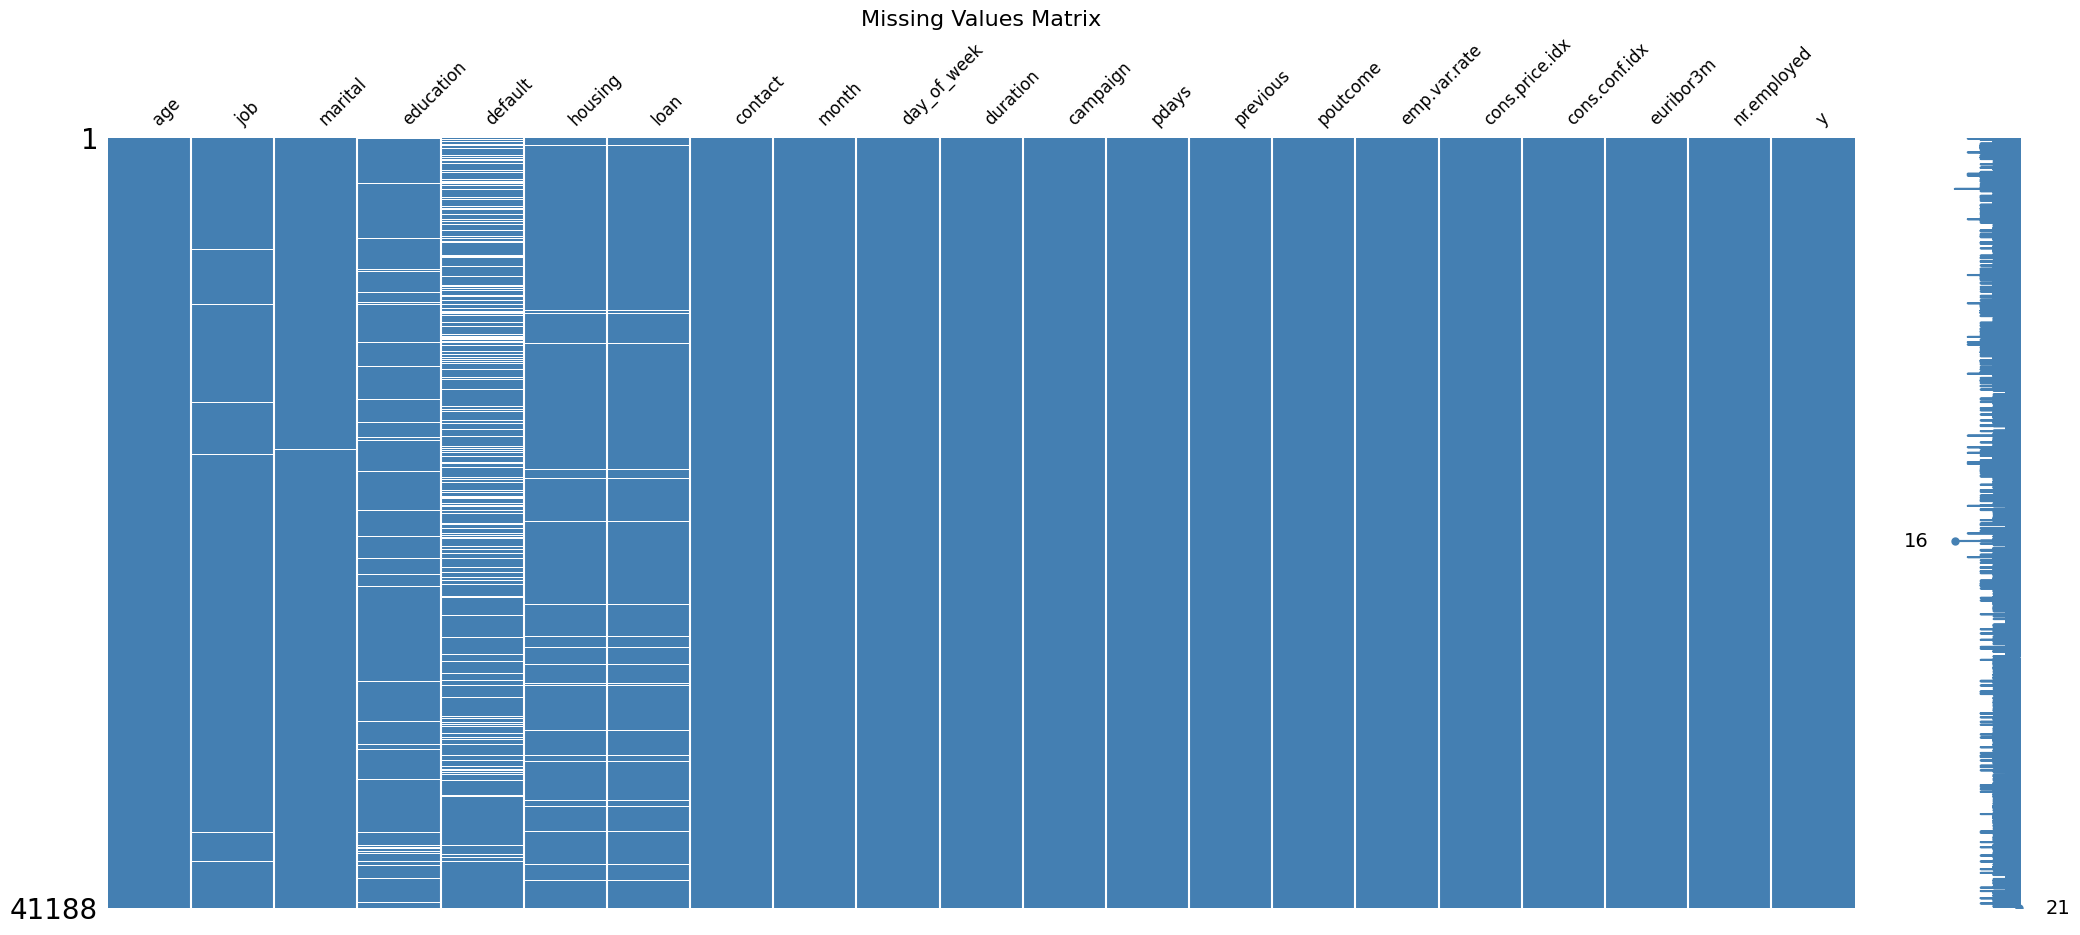

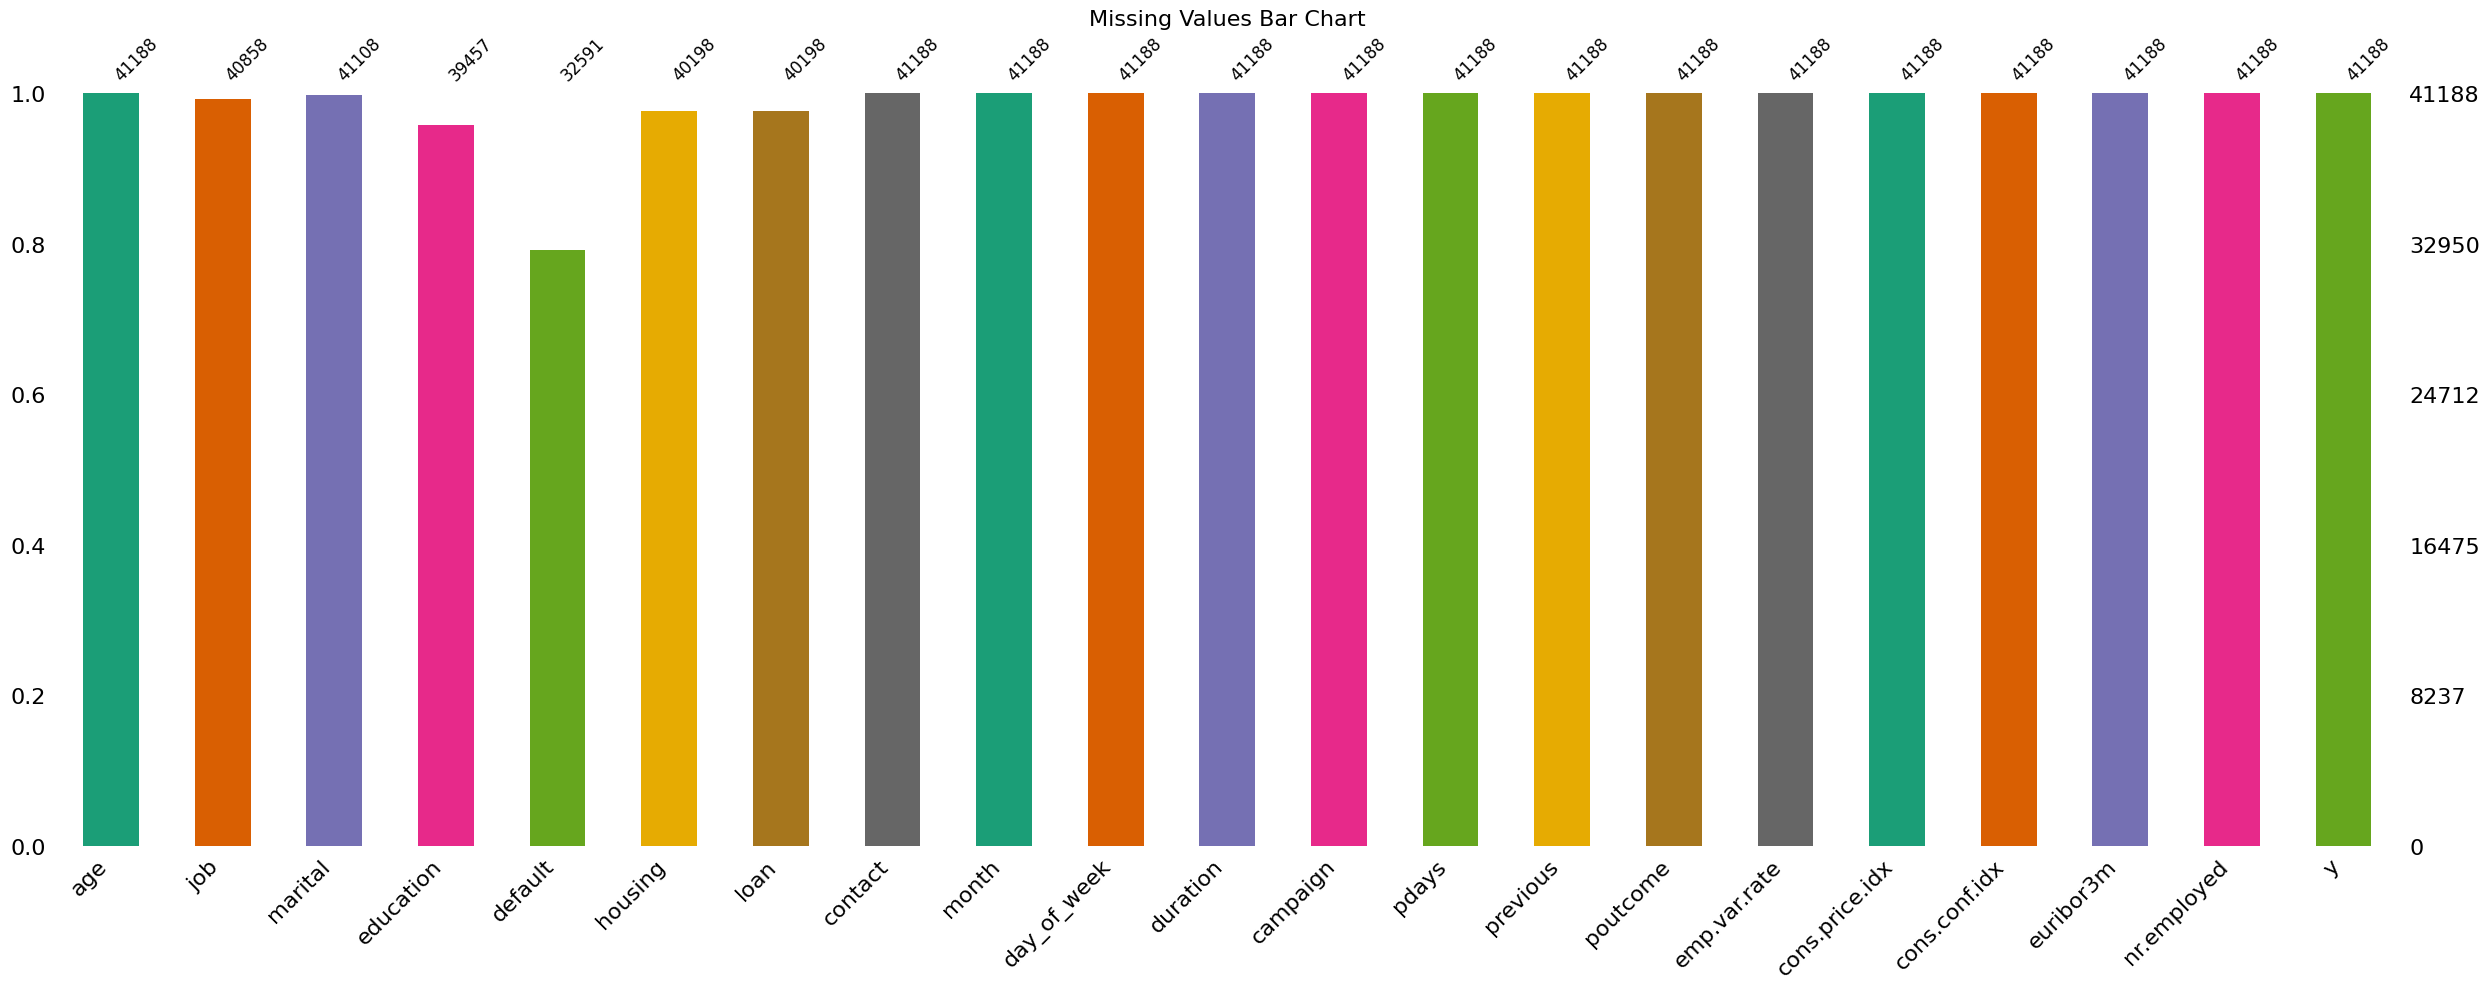

In [15]:
missing_inf_values(data)
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}\n")
duplicates = data[data.duplicated()]
duplicates
show_missing(data)

In [16]:
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    if data[col].isna().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}\n")
duplicates = data[data.duplicated()]


Number of duplicate rows: 14



In [17]:
data = data.drop_duplicates()

In [18]:
missing_inf_values(data)

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.


In [19]:
inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum().sum()
print(f"Total Inf values: {inf_counts}")

Total Inf values: 0


There are missing values in key columns: default (21%) and education (4%). Other columns have minimal missing data. No infinite values were found. There are 12 duplicate rows that need to be removed.

In [20]:
data.dtypes.value_counts()

object     11
int64       5
float64     5
Name: count, dtype: int64

In [21]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     15         emp.var.rate                   float64         -3.4 - 1.4                     10
2     16         cons.price.idx                 float64         92.201 - 94.767                26
3     17         cons.conf.idx                  float64         -50.8 - -26.9                  26
4     18         euribor3m                      float64         0.634 - 5.045                  316
5     19         nr.employed                    float64         4963.6 - 5228.1                11
6     0          age                            int64           17 - 98                        78
7     10         duration                       int64           0 - 4918                       1544
8     11         campaign                       i

In [22]:
analyze_data(data)





















=== Numerical Analysis ===
|    | Variable       |     N |      Mean |       SD |     SE |   95% Conf. |   Interval |
|---:|:---------------|------:|----------:|---------:|-------:|------------:|-----------:|
|  0 | age            | 41174 |   40.0236 |  10.4206 | 0.0514 |     39.9229 |    40.1242 |
|  1 | duration       | 41174 |  258.324  | 259.309  | 1.2779 |    255.819  |   260.828  |
|  2 | campaign       | 41174 |    2.568  |   2.7704 | 0.0137 |      2.5412 |     2.5947 |
|  3 | pdays          | 41174 |  962.463  | 186.941  | 0.9213 |    960.657  |   964.269  |
|  4 | previous       | 41174 |    0.173  |   0.495  | 0.0024 |      0.1682 |     0.1778 |
|  5 | emp.var.rate   | 41174 |    0.0819 |   1.5709 | 0.0077 |      0.0667 |     0.097  |
|  6 | cons.price.idx | 41174 |   93.5757 |   0.5788 | 0.0029 |     93.5701 |    93.5813 |
|  7 | cons.conf.idx  | 41174 |  -40.5031 |   4.6279 | 0.0228 |    -40.5478 |   -40.4584 |
|  8 | euribor3m      | 41174 |    3.6212 |

In [23]:
data_cat_missing_summary, data_cat_non_missing_summary = comp_cat_analysis(data, missing_df=True)
data_num_missing_summary, data_num_non_missing_summary = comp_num_analysis(data, missing_df=True)
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_cat_missing_summary.shape)
print(data_num_missing_summary.shape)
print(data_outlier_summary.shape)

(0, 9)
(0, 31)
(6, 31)


In [24]:
data_cat_missing_summary

Empty DataFrame
Columns: [Index, Column, DataType, Count, Missing_Percentage, Unique_Count, Mode, Mode Frequency, Mode %]
Index: []

In [25]:
data_num_missing_summary

Empty DataFrame
Columns: [Index, Column, DataType, Count, Missing_Percentage, Unique_Count, Min, Q1, 50% (Median), Q3, Max, Mode, Range, IQR, Lower Bound, Upper Bound, Total Distinct, Outliers Distinct, Outliers Count, Outliers %, Negative Count, Negative Distinct, Negative %, Mean, Variance, Std, Skewness, Kurtosis, Normality Test, Normality Statistic, Normality p-value]
Index: []

In [26]:
data_cat_non_missing_summary

Index       Column DataType  Count  Missing_Percentage  Unique_Count  \
6       7      contact   object  41174                 0.0             2   
8       9  day_of_week   object  41174                 0.0             5   
3       4      default   object  41174                 0.0             2   
2       3    education   object  41174                 0.0             7   
4       5      housing   object  41174                 0.0             2   
0       1          job   object  41174                 0.0            11   
5       6         loan   object  41174                 0.0             2   
1       2      marital   object  41174                 0.0             3   
7       8        month   object  41174                 0.0            10   
9      14     poutcome   object  41174                 0.0             3   
10     20            y   object  41174                 0.0             2   

                 Mode  Mode Frequency     Mode %  
6            cellular           26134  63.472094  
8                 thu            8617  20.928256  
3                  no           41171  99.992714  
2   university.degree           13893  33.742167  
4                 yes           22560  54.791859  
0              admin.           10748  26.103852  
5                  no           34926  84.825375  
1             married           24999  60.715500  
7                 may           13766  33.433720  
9         nonexistent           35549  86.338466  
10                 no           36535  88.733181

In [27]:
data_num_non_missing_summary

Index          Column DataType  Count  Missing_Percentage  Unique_Count  \
0      0             age    int64  41174                 0.0            78   
1     10        duration    int64  41174                 0.0          1544   
2     11        campaign    int64  41174                 0.0            42   
3     12           pdays    int64  41174                 0.0            27   
4     13        previous    int64  41174                 0.0             8   
5     15    emp.var.rate  float64  41174                 0.0            10   
6     16  cons.price.idx  float64  41174                 0.0            26   
7     17   cons.conf.idx  float64  41174                 0.0            26   
8     18       euribor3m  float64  41174                 0.0           316   
9     19     nr.employed  float64  41174                 0.0            11   

        Min        Q1  50% (Median)        Q3       Max      Mode     Range  \
0    17.000    32.000        38.000    47.000    98.000    31.000    81.000   
1     0.000   102.000       180.000   319.000  4918.000    85.000  4918.000   
2     1.000     1.000         2.000     3.000    56.000     1.000    55.000   
3     0.000   999.000       999.000   999.000   999.000   999.000   999.000   
4     0.000     0.000         0.000     0.000     7.000     0.000     7.000   
5    -3.400    -1.800         1.100     1.400     1.400     1.400     4.800   
6    92.201    93.075        93.749    93.994    94.767    93.994     2.566   
7   -50.800   -42.700       -41.800   -36.400   -26.900   -36.400    23.900   
8     0.634     1.344         4.857     4.961     5.045     4.857     4.411   
9  4963.600  5099.100      5191.000  5228.100  5228.100  5228.100   264.500   

       IQR  Lower Bound  Upper Bound  Total Distinct  Outliers Distinct  \
0   15.000       9.5000      69.5000              78                 25   
1  217.000    -223.5000     644.5000            1544                899   
2    2.000      -2.0000       6.0000              42                 36   
3    0.000     999.0000     999.0000              27                 26   
4    0.000       0.0000       0.0000               8                  7   
5    3.200      -6.6000       6.2000              10                  0   
6    0.919      91.6965      95.3725              26                  0   
7    6.300     -52.1500     -26.9500              26                  1   
8    3.617      -4.0815      10.3865             316                  0   
9  129.000    4905.6000    5421.6000              11                  0   

   Outliers Count  Outliers %  Negative Count  Negative Distinct  Negative %  \
0             468    1.136640               0                  0    0.000000   
1            2963    7.196289               0                  0    0.000000   
2            2406    5.843493               0                  0    0.000000   
3            1515    3.679506               0                  0    0.000000   
4            5625   13.661534               0                  0    0.000000   
5               0    0.000000           17186                  8   41.739933   
6               0    0.000000               0                  0    0.000000   
7             446    1.083208           41174                 26  100.000000   
8               0    0.000000               0                  0    0.000000   
9               0    0.000000               0                  0    0.000000   

          Mean      Variance         Std  Skewness   Kurtosis  \
0    40.023583    108.588446   10.420578  0.784575   0.791130   
1   258.323627  67241.187348  259.309058  3.262629  20.240554   
2     2.567956      7.674917    2.770364  4.761792  36.965996   
3   962.463035  34947.112652  186.941469 -4.921073  22.217391   
4     0.173022      0.245000    0.494975  3.831148  20.098468   
5     0.081865      2.467725    1.570899 -0.723959  -1.062824   
6    93.575713      0.335066    0.578849 -0.230817  -0.829959   
7   -40.503070     21.417248    4.627877  0.302

In [28]:
data_non_outlier_summary

Index          Column DataType  Count  Missing_Percentage  Unique_Count  \
5     15    emp.var.rate  float64  41174                 0.0            10   
6     16  cons.price.idx  float64  41174                 0.0            26   
8     18       euribor3m  float64  41174                 0.0           316   
9     19     nr.employed  float64  41174                 0.0            11   

        Min        Q1  50% (Median)        Q3       Max      Mode    Range  \
5    -3.400    -1.800         1.100     1.400     1.400     1.400    4.800   
6    92.201    93.075        93.749    93.994    94.767    93.994    2.566   
8     0.634     1.344         4.857     4.961     5.045     4.857    4.411   
9  4963.600  5099.100      5191.000  5228.100  5228.100  5228.100  264.500   

       IQR  Lower Bound  Upper Bound  Total Distinct  Outliers Distinct  \
5    3.200      -6.6000       6.2000              10                  0   
6    0.919      91.6965      95.3725              26                  0   
8    3.617      -4.0815      10.3865             316                  0   
9  129.000    4905.6000    5421.6000              11                  0   

   Outliers Count  Outliers %  Negative Count  Negative Distinct  Negative %  \
5               0         0.0           17186                  8   41.739933   
6               0         0.0               0                  0    0.000000   
8               0         0.0               0                  0    0.000000   
9               0         0.0               0                  0    0.000000   

          Mean     Variance        Std  Skewness  Kurtosis  \
5     0.081865     2.467725   1.570899 -0.723959 -1.062824   
6    93.575713     0.335066   0.578849 -0.230817 -0.829959   
8     3.621231     3.008337   1.734456 -0.709092 -1.406875   
9  5167.032805  5220.408652  72.252395 -1.044215 -0.003843   

       Normality Test  Normality Statistic  Normality p-value  
5  Kolmogorov-Smirnov             0.324148                0.0  
6  Kolmogorov-Smirnov             0.214032                0.0  
8  Kolmogorov-Smirnov             0.345472                0.0  
9  Kolmogorov-Smirnov             0.301974                0.0

In [29]:
data_outlier_summary

Index         Column DataType  Count  Missing_Percentage  Unique_Count  \
0      0            age    int64  41174                 0.0            78   
3     12          pdays    int64  41174                 0.0            27   
2     11       campaign    int64  41174                 0.0            42   
1     10       duration    int64  41174                 0.0          1544   
4     13       previous    int64  41174                 0.0             8   
7     17  cons.conf.idx  float64  41174                 0.0            26   

    Min     Q1  50% (Median)     Q3     Max   Mode   Range    IQR  \
0  17.0   32.0          38.0   47.0    98.0   31.0    81.0   15.0   
3   0.0  999.0         999.0  999.0   999.0  999.0   999.0    0.0   
2   1.0    1.0           2.0    3.0    56.0    1.0    55.0    2.0   
1   0.0  102.0         180.0  319.0  4918.0   85.0  4918.0  217.0   
4   0.0    0.0           0.0    0.0     7.0    0.0     7.0    0.0   
7 -50.8  -42.7         -41.8  -36.4   -26.9  -36.4    23.9    6.3   

   Lower Bound  Upper Bound  Total Distinct  Outliers Distinct  \
0         9.50        69.50              78                 25   
3       999.00       999.00              27                 26   
2        -2.00         6.00              42                 36   
1      -223.50       644.50            1544                899   
4         0.00         0.00               8                  7   
7       -52.15       -26.95              26                  1   

   Outliers Count  Outliers %  Negative Count  Negative Distinct  Negative %  \
0             468    1.136640               0                  0         0.0   
3            1515    3.679506               0                  0         0.0   
2            2406    5.843493               0                  0         0.0   
1            2963    7.196289               0                  0         0.0   
4            5625   13.661534               0                  0         0.0   
7             446    1.083208           41174                 26       100.0   

         Mean      Variance         Std  Skewness   Kurtosis  \
0   40.023583    108.588446   10.420578  0.784575   0.791130   
3  962.463035  34947.112652  186.941469 -4.921073  22.217391   
2    2.567956      7.674917    2.770364  4.761792  36.965996   
1  258.323627  67241.187348  259.309058  3.262629  20.240554   
4    0.173022      0.245000    0.494975  3.831148  20.098468   
7  -40.503070     21.417248    4.627877  0.302972  -0.359091   

       Normality Test  Normality Statistic  Normality p-value  
0  Kolmogorov-Smirnov             0.094435      5.032553e-320  
3  Kolmogorov-Smirnov             0.540683       0.000000e+00  
2  Kolmogorov-Smirnov             0.285706       0.000000e+00  
1  Kolmogorov-Smirnov             0.169505       0.000000e+00  
4  Kolmogorov-Smirnov             0.500049       0.000000e+00  
7  Kolmogorov-Smirnov             0.190261       0.000000e+00

In [30]:
data_negative_values = data.select_dtypes(include=[np.number]).lt(0).sum()
data_negative_values = data_negative_values[data_negative_values > 0].sort_values(ascending=False)
print("Columns with Negative Values (Sorted):\n", data_negative_values)

Columns with Negative Values (Sorted):
 cons.conf.idx    41174
emp.var.rate     17186
dtype: int64


In [31]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


Empty DataFrame
Columns: [Column, Test, Statistic, p_value, Skewness, Kurtosis]
Index: []


Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


Column                Test  Statistic        p_value  Skewness  \
0             age  Kolmogorov-Smirnov   0.094435  5.032553e-320  0.784575   
1        duration  Kolmogorov-Smirnov   0.169505   0.000000e+00  3.262629   
2        campaign  Kolmogorov-Smirnov   0.285706   0.000000e+00  4.761792   
3           pdays  Kolmogorov-Smirnov   0.540683   0.000000e+00 -4.921073   
4        previous  Kolmogorov-Smirnov   0.500049   0.000000e+00  3.831148   
5    emp.var.rate  Kolmogorov-Smirnov   0.324148   0.000000e+00 -0.723959   
6  cons.price.idx  Kolmogorov-Smirnov   0.214032   0.000000e+00 -0.230817   
7   cons.conf.idx  Kolmogorov-Smirnov   0.190261   0.000000e+00  0.302972   
8       euribor3m  Kolmogorov-Smirnov   0.345472   0.000000e+00 -0.709092   
9     nr.employed  Kolmogorov-Smirnov   0.301974   0.000000e+00 -1.044215   

    Kurtosis  
0   0.791130  
1  20.240554  
2  36.965996  
3  22.217391  
4  20.098468  
5  -1.062824  
6  -0.829959  
7  -0.359091  
8  -1.406875  
9  -0.003843

several columns contain outliers. For example, age has 469 outliers (1.14%), while pdays, campaign, duration, and previous have more significant outliers. The distribution of most columns is skewed, with duration and campaign showing strong positive skew. pdays has a high concentration of 999 values, indicating a lot of unchanged data. Overall, the data is non-normal, and transformations may be necessary for certain models.


Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
- emp.var.rate & euribor3m: Correlation=0.9399
- emp.var.rate & nr.employed: Correlation=0.9447
- euribor3m & nr.employed: Correlation=0.9289


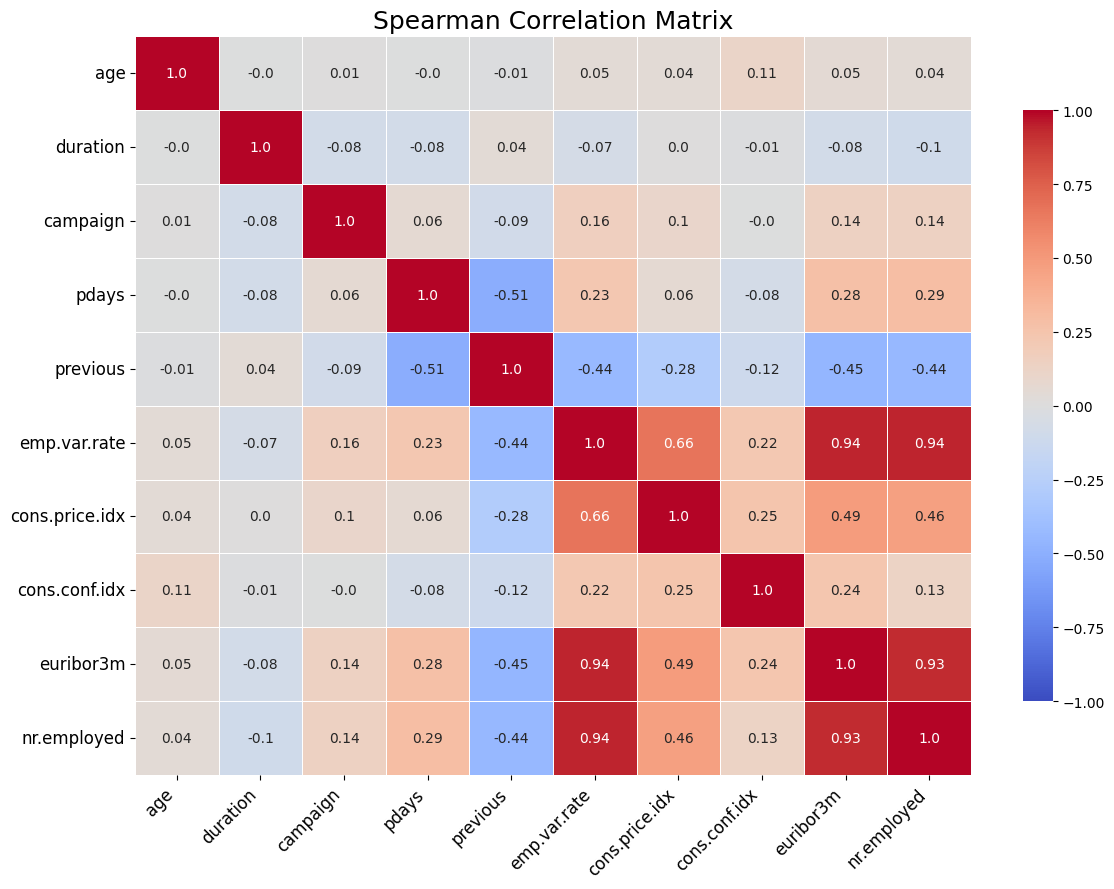

In [32]:
spearman_correlation(data, data_not_normal_df, exclude_target='y', multicollinearity_threshold=0.8)

In [33]:
at_above_threshold, at_below_threshold = calculate_vif(data, exclude_target='y', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
       Feature          VIF
   nr.employed 26744.075510
cons.price.idx 22558.526669
     euribor3m   226.217188
 cons.conf.idx   120.098329
         pdays    44.398360
  emp.var.rate    28.907236
           age    16.047465

Features with VIF <= threshold (Low/No Multicollinearity):
 Feature      VIF
duration 2.011120
previous 2.001613
campaign 1.921579


There is strong multicollinearity in the dataset between **emp.var.rate**, **euribor3m**, and **nr.employed**, with correlation values above 0.90. This means these variables are highly related and could cause issues in modeling

### Exploratory Data Analysis (EDA)

### Descriptive Statistics


Value counts and percentages for Y:

| Y   |   Count |   % Total |
|:----|--------:|----------:|
| no  |   36535 |     88.73 |
| yes |    4639 |     11.27 |


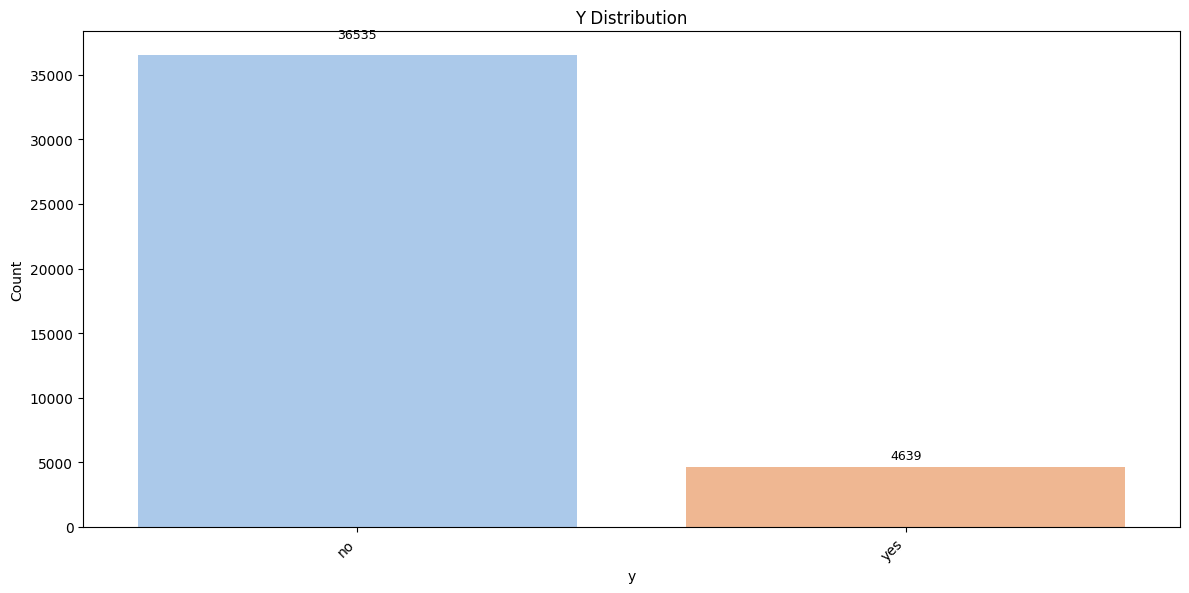

In [34]:
cat_analyze_and_plot(data, 'y')

In [35]:
grouped_summary(data, groupby='y')

=== Summary Grouped by 'y' ===


Grouped by y                                                     
                                                   Missing        Overall             no            yes P-Value
n                                                                   41174          36535           4639        
age, mean (SD)                                           0    40.0 (10.4)     39.9 (9.9)    40.9 (13.8)  <0.001
job, n (%)                admin.                             10748 (26.1)    9360 (25.6)    1388 (29.9)  <0.001
                          blue-collar                         9252 (22.5)    8614 (23.6)     638 (13.8)        
                          entrepreneur                         1456 (3.5)     1332 (3.6)      124 (2.7)        
                          housemaid                            1060 (2.6)      954 (2.6)      106 (2.3)        
                          management                           2924 (7.1)     2596 (7.1)      328 (7.1)        
                          retired                              1718 (4.2)     1284 (3.5)      434 (9.4)        
                          self-employed                        1421 (3.5)     1272 (3.5)      149 (3.2)        
                          services                             3967 (9.6)    3644 (10.0)      323 (7.0)        
                          student                               875 (2.1)      600 (1.6)      275 (5.9)        
                          technician                          6739 (16.4)    6009 (16.4)     730 (15.7)        
                          unemployed                           1014 (2.5)      870 (2.4)      144 (3.1)        
marital, n (%)            divorced                            4611 (11.2)    4135 (11.3)     476 (10.3)  <0.001
                          married                            24999 (60.7)   22456 (61.5)    2543 (54.8)        
                          single                             11564 (28.1)    9944 (27.2)    1620 (34.9)        
education, n (%)          basic.4y                            4175 (10.1)    3747 (10.3)      428 (9.2)  <0.001
                          basic.6y                             2291 (5.6)     2103 (5.8)      188 (4.1)        
                          basic.9y                            6045 (14.7)    5572 (15.3)     473 (10.2)        
                          high.school                         9512 (23.1)    8481 (23.2)    1031 (22.2)        
                          illiterate                             18 (0.0)       14 (0.0)        4 (0.1)        
                          professional.course                 5240 (12.7)    4645 (12.7)     595 (12.8)        
                          university.degree                  13893 (33.7)   11973 (32.8)    1920 (41.4)        
default, n (%)            no                                41171 (100.0)  36532 (100.0)   4639 (100.0)   1.000
                          yes                                     3 (0.0)        3 (0.0)                       
housing, n (%)            no                                 18614 (45.2)   16589 (45.4)    2025 (43.7)   0.025
                          yes                                22560 (54.8)   19946 (54.6)    2614 (56.3)        
loan, n (%)               no                                 34926 (84.8)   30970 (84.8)    3956 (85.3)   0.374
                          yes                                 6248 (15.2)    5565 (15.2)     683 (14.7)        
contact, n (%)            cellular                           26134 (63.5)   22282 (61.0)    3852 (83.0)  <0.001
                          telephone                          15040 (36.5)   14253 (39.0)     787 (17.0)        
month, n (%)              apr                                  2631 (6.4)     2092 (5.7)     539 (11.6)  <0.001
                          aug                                 6175 (15.0)    5520 (15.1)     655 (14.1)        
                          dec                                   182 (0.4)       93 (0.3)       89 (1.9)        
              

1. Demographic Differences: Those who said “yes” tend to be slightly older, more likely single, and more often highly educated (e.g., have a university degree). They also show specific job patterns (higher proportions of retirees and students).

2. Contact/Timing Factors: 
   - “Cellular” contacts are much more common in the “yes” group.  
   - The duration of the last call is significantly longer among “yes” than “no.”  
   - The month of contact matters: certain months (e.g., March, October) have higher shares of “yes” than might be expected given the overall distribution.

3. Previous Interaction: “Yes” is more likely if a previous campaign outcome was “success,” and typically they had fewer days since last contact and possibly more total prior contacts overall.

4. Macroeconomic Indicators: Lower euribor3m rates, lower “emp.var.rate,” and fewer employees (nr.employed) seem to be associated with the “yes” group.

Overall, the significant p-values (< 0.001 for most) imply strong evidence that the “yes” and “no” groups differ on these features—important for modeling or understanding who might subscribe.

In [36]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     15         emp.var.rate                   float64         -3.4 - 1.4                     10
2     16         cons.price.idx                 float64         92.201 - 94.767                26
3     17         cons.conf.idx                  float64         -50.8 - -26.9                  26
4     18         euribor3m                      float64         0.634 - 5.045                  316
5     19         nr.employed                    float64         4963.6 - 5228.1                11
6     0          age                            int64           17 - 98                        78
7     10         duration                       int64           0 - 4918                       1544
8     11         campaign                       i

In [37]:
num_summary(data)

Count  Unique       Mean       Std       Min       25%  \
age             41174.0    78.0    40.0236   10.4206    17.000    32.000   
duration        41174.0  1544.0   258.3236  259.3091     0.000   102.000   
campaign        41174.0    42.0     2.5680    2.7704     1.000     1.000   
pdays           41174.0    27.0   962.4630  186.9415     0.000   999.000   
previous        41174.0     8.0     0.1730    0.4950     0.000     0.000   
emp.var.rate    41174.0    10.0     0.0819    1.5709    -3.400    -1.800   
cons.price.idx  41174.0    26.0    93.5757    0.5788    92.201    93.075   
cons.conf.idx   41174.0    26.0   -40.5031    4.6279   -50.800   -42.700   
euribor3m       41174.0   316.0     3.6212    1.7345     0.634     1.344   
nr.employed     41174.0    11.0  5167.0328   72.2524  4963.600  5099.100   

                     50%       75%       Max      Mode     Range      IQR  \
age               38.000    47.000    98.000    31.000    81.000   15.000   
duration         180.000   319.000  4918.000    85.000  4918.000  217.000   
campaign           2.000     3.000    56.000     1.000    55.000    2.000   
pdays            999.000   999.000   999.000   999.000   999.000    0.000   
previous           0.000     0.000     7.000     0.000     7.000    0.000   
emp.var.rate       1.100     1.400     1.400     1.400     4.800    3.200   
cons.price.idx    93.749    93.994    94.767    93.994     2.566    0.919   
cons.conf.idx    -41.800   -36.400   -26.900   -36.400    23.900    6.300   
euribor3m          4.857     4.961     5.045     4.857     4.411    3.617   
nr.employed     5191.000  5228.100  5228.100  5228.100   264.500  129.000   

                  Variance  Skewness  Kurtosis  Shapiro-Wilk Stat  \
age               108.5884    0.7846    0.7914             0.9573   
duration        67241.1873    3.2627   20.2432             0.7217   
campaign            7.6749    4.7620   36.9706             0.5579   
pdays           34947.1127   -4.9213   22.2202             0.1830   
previous            0.2450    3.8313   20.1011             0.3913   
emp.var.rate        2.4677   -0.7240   -1.0628             0.7622   
cons.price.idx      0.3351   -0.2308   -0.8299             0.9339   
cons.conf.idx      21.4172    0.3030   -0.3590             0.9241   
euribor3m           3.0083   -0.7091   -1.4069             0.6863   
nr.employed      5220.4087   -1.0443   -0.0037             0.7878   

                Shapiro-Wilk p-value  
age                              0.0  
duration                         0.0  
campaign                         0.0  
pdays                            0.0  
previous                         0.0  
emp.var.rate                     0.0  
cons.price.idx                   0.0  
cons.conf.idx                    0.0  
euribor3m                        0.0  
nr.employed                      0.0

In [38]:
cat_summary(data)

Count Unique                Top   Freq   Top %
job          41174     11             admin.  10748  26.10%
marital      41174      3            married  24999  60.72%
education    41174      7  university.degree  13893  33.74%
default      41174      2                 no  41171  99.99%
housing      41174      2                yes  22560  54.79%
loan         41174      2                 no  34926  84.83%
contact      41174      2           cellular  26134  63.47%
month        41174     10                may  13766  33.43%
day_of_week  41174      5                thu   8617  20.93%
poutcome     41174      3        nonexistent  35549  86.34%
y            41174      2                 no  36535  88.73%

the duration of phone calls varies significantly, indicating a mixture of very short and exceptionally long calls. The average call duration is approximately 258 seconds, but it can extend to nearly 4918 seconds. This suggests that longer calls might be associated with successful conversions, which could be a focus area for enhancing customer engagement strategies.

In terms of campaign contact, the data reveals a skewed distribution, with most clients being contacted less than three times, but a few receiving up to 56 contacts. This pattern suggests the possibility of diminishing returns on repeated contacts, indicating a need to optimize the number of interactions per client.

The 'pdays' attribute shows a predominance of the value 999, indicating that most clients had not been contacted before this campaign. This observation suggests that the bank is frequently reaching out to new prospects or has not effectively followed up with previous contacts.

From a demographic perspective, administrative roles dominate the client job categories, representing over a quarter of the total client base. This suggests that marketing efforts could be tailored to appeal specifically to this group. Additionally, the majority of clients are married and well-educated (with university degrees), which might influence the type of products they are interested in or the marketing channels that are most effective.

overall, the low conversion rate of 11.27% for term deposit subscriptions highlights a significant challenge in the marketing strategy's effectiveness. This low rate suggests there is substantial room for improvement in campaign targeting, messaging, and possibly product offers to better meet the needs and preferences of potential clients.

### Univariate Analysis

#### num_analysis

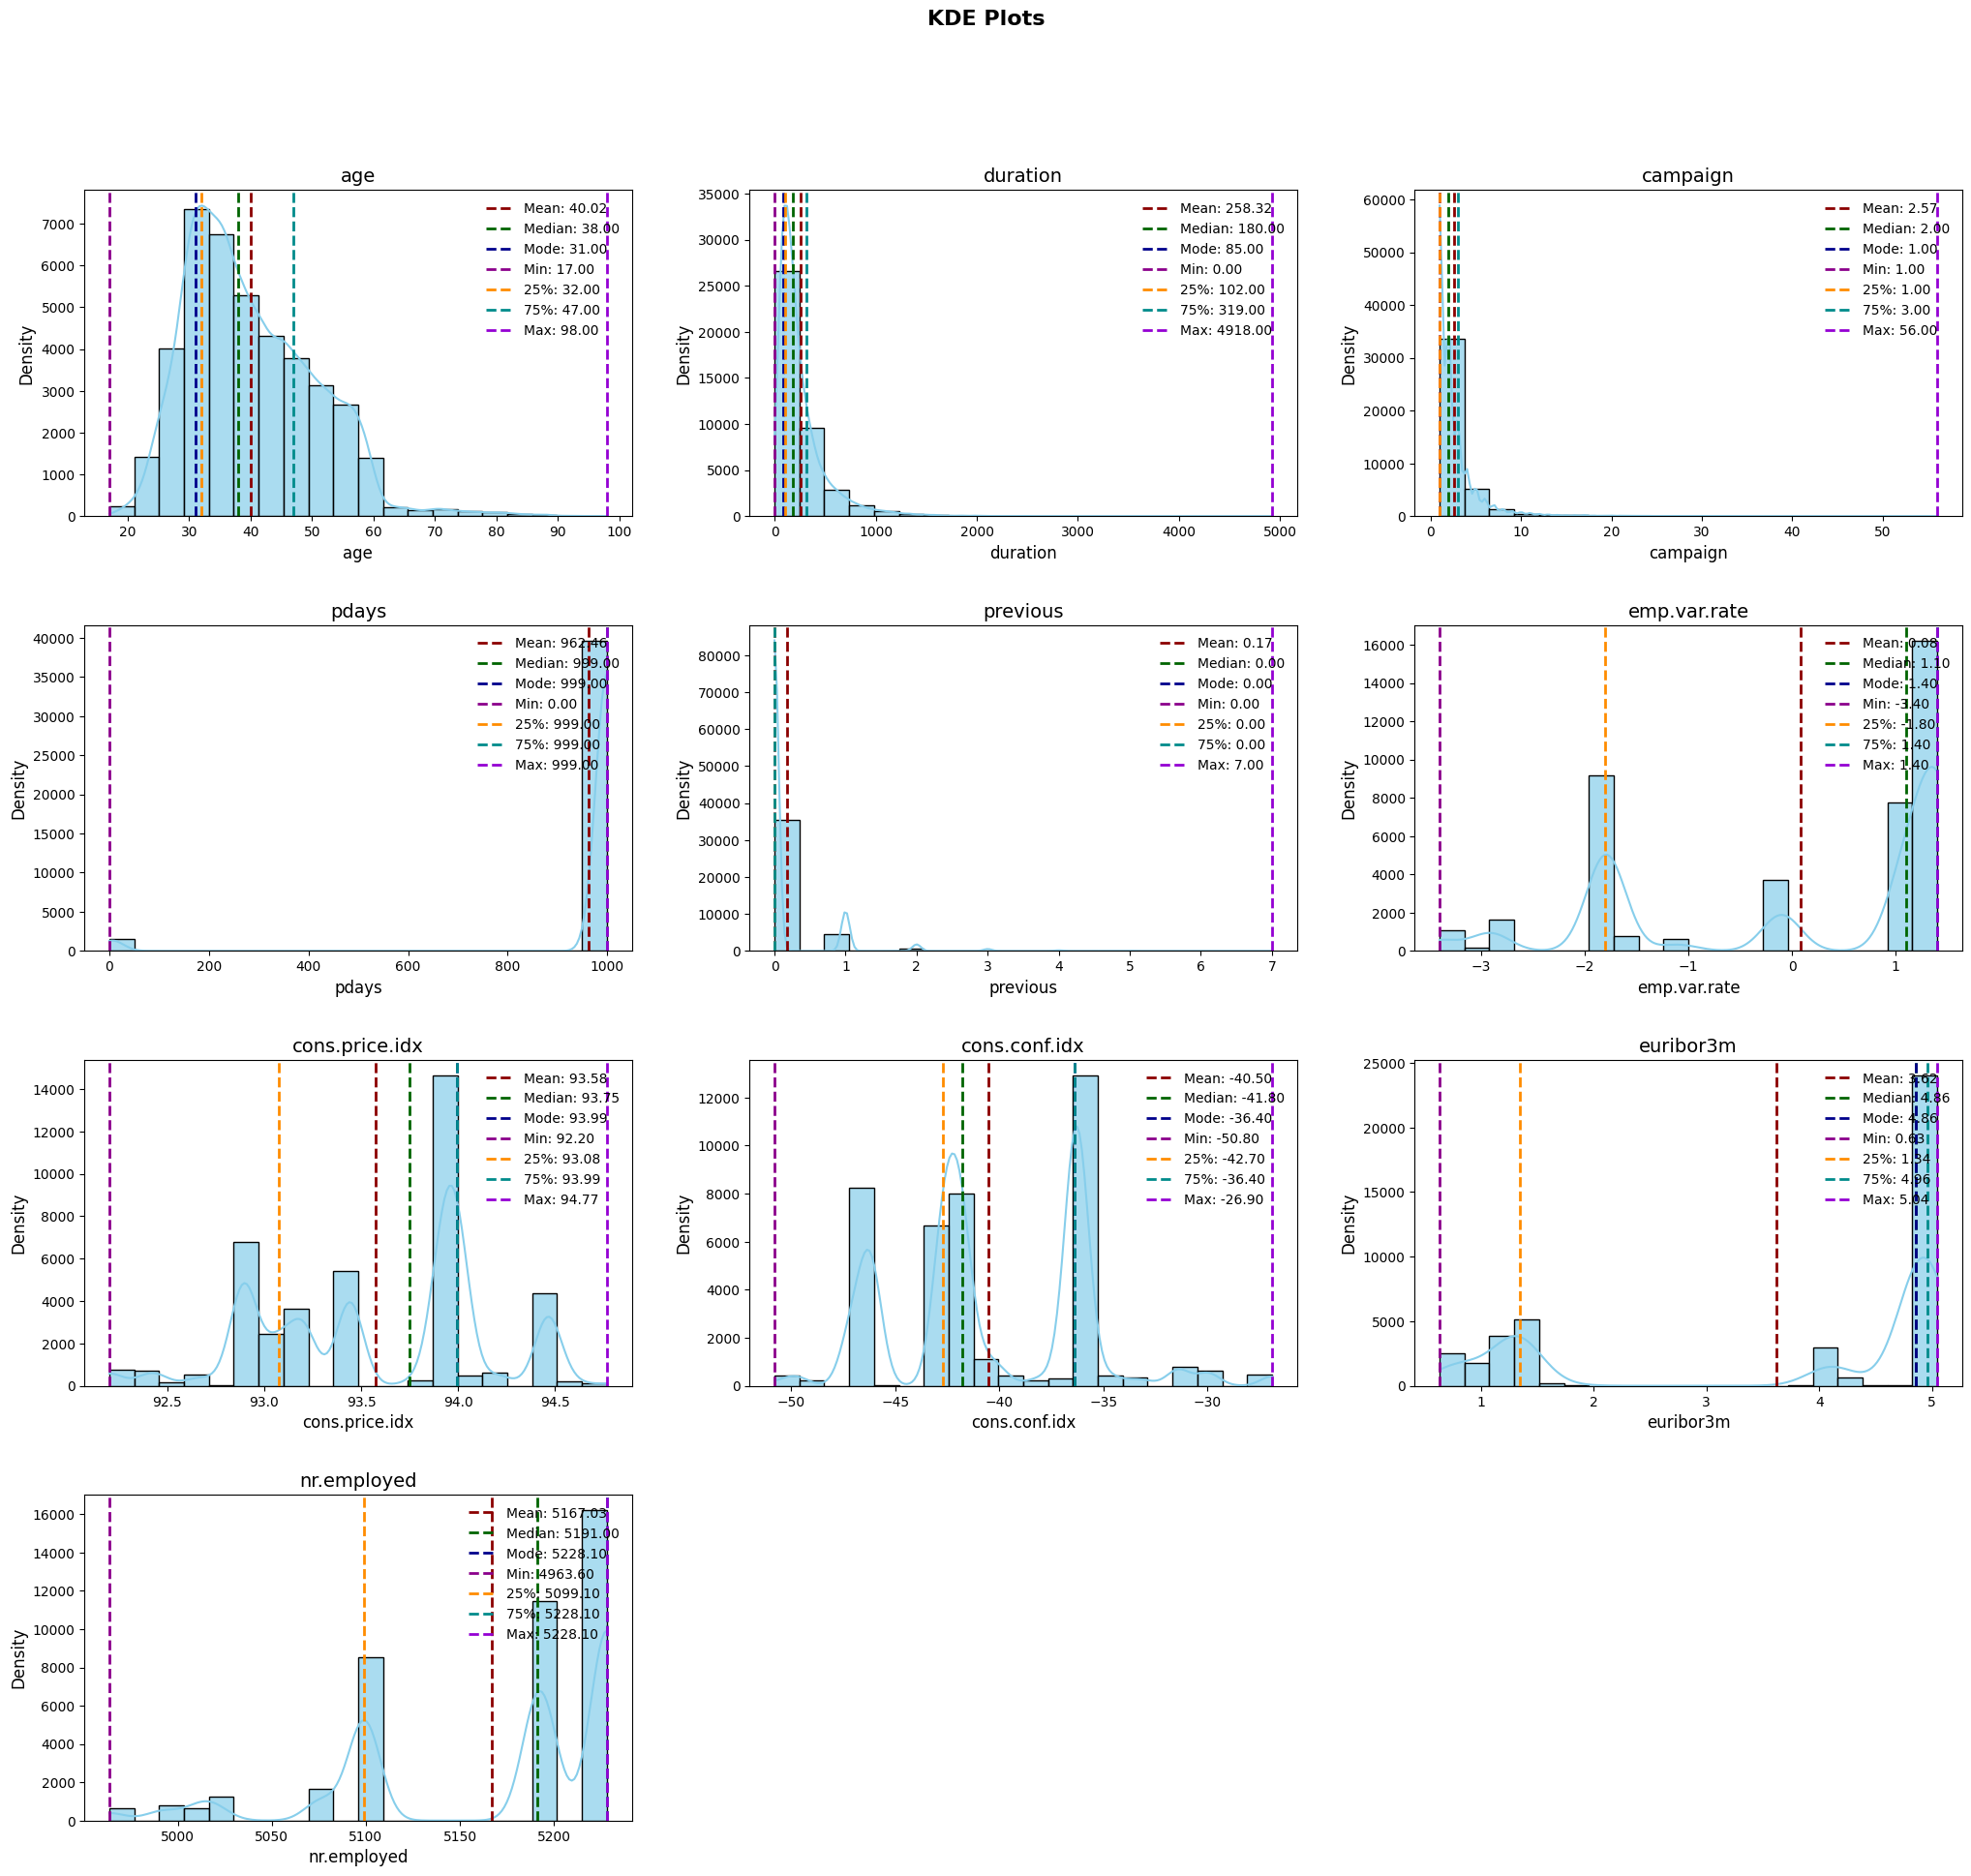

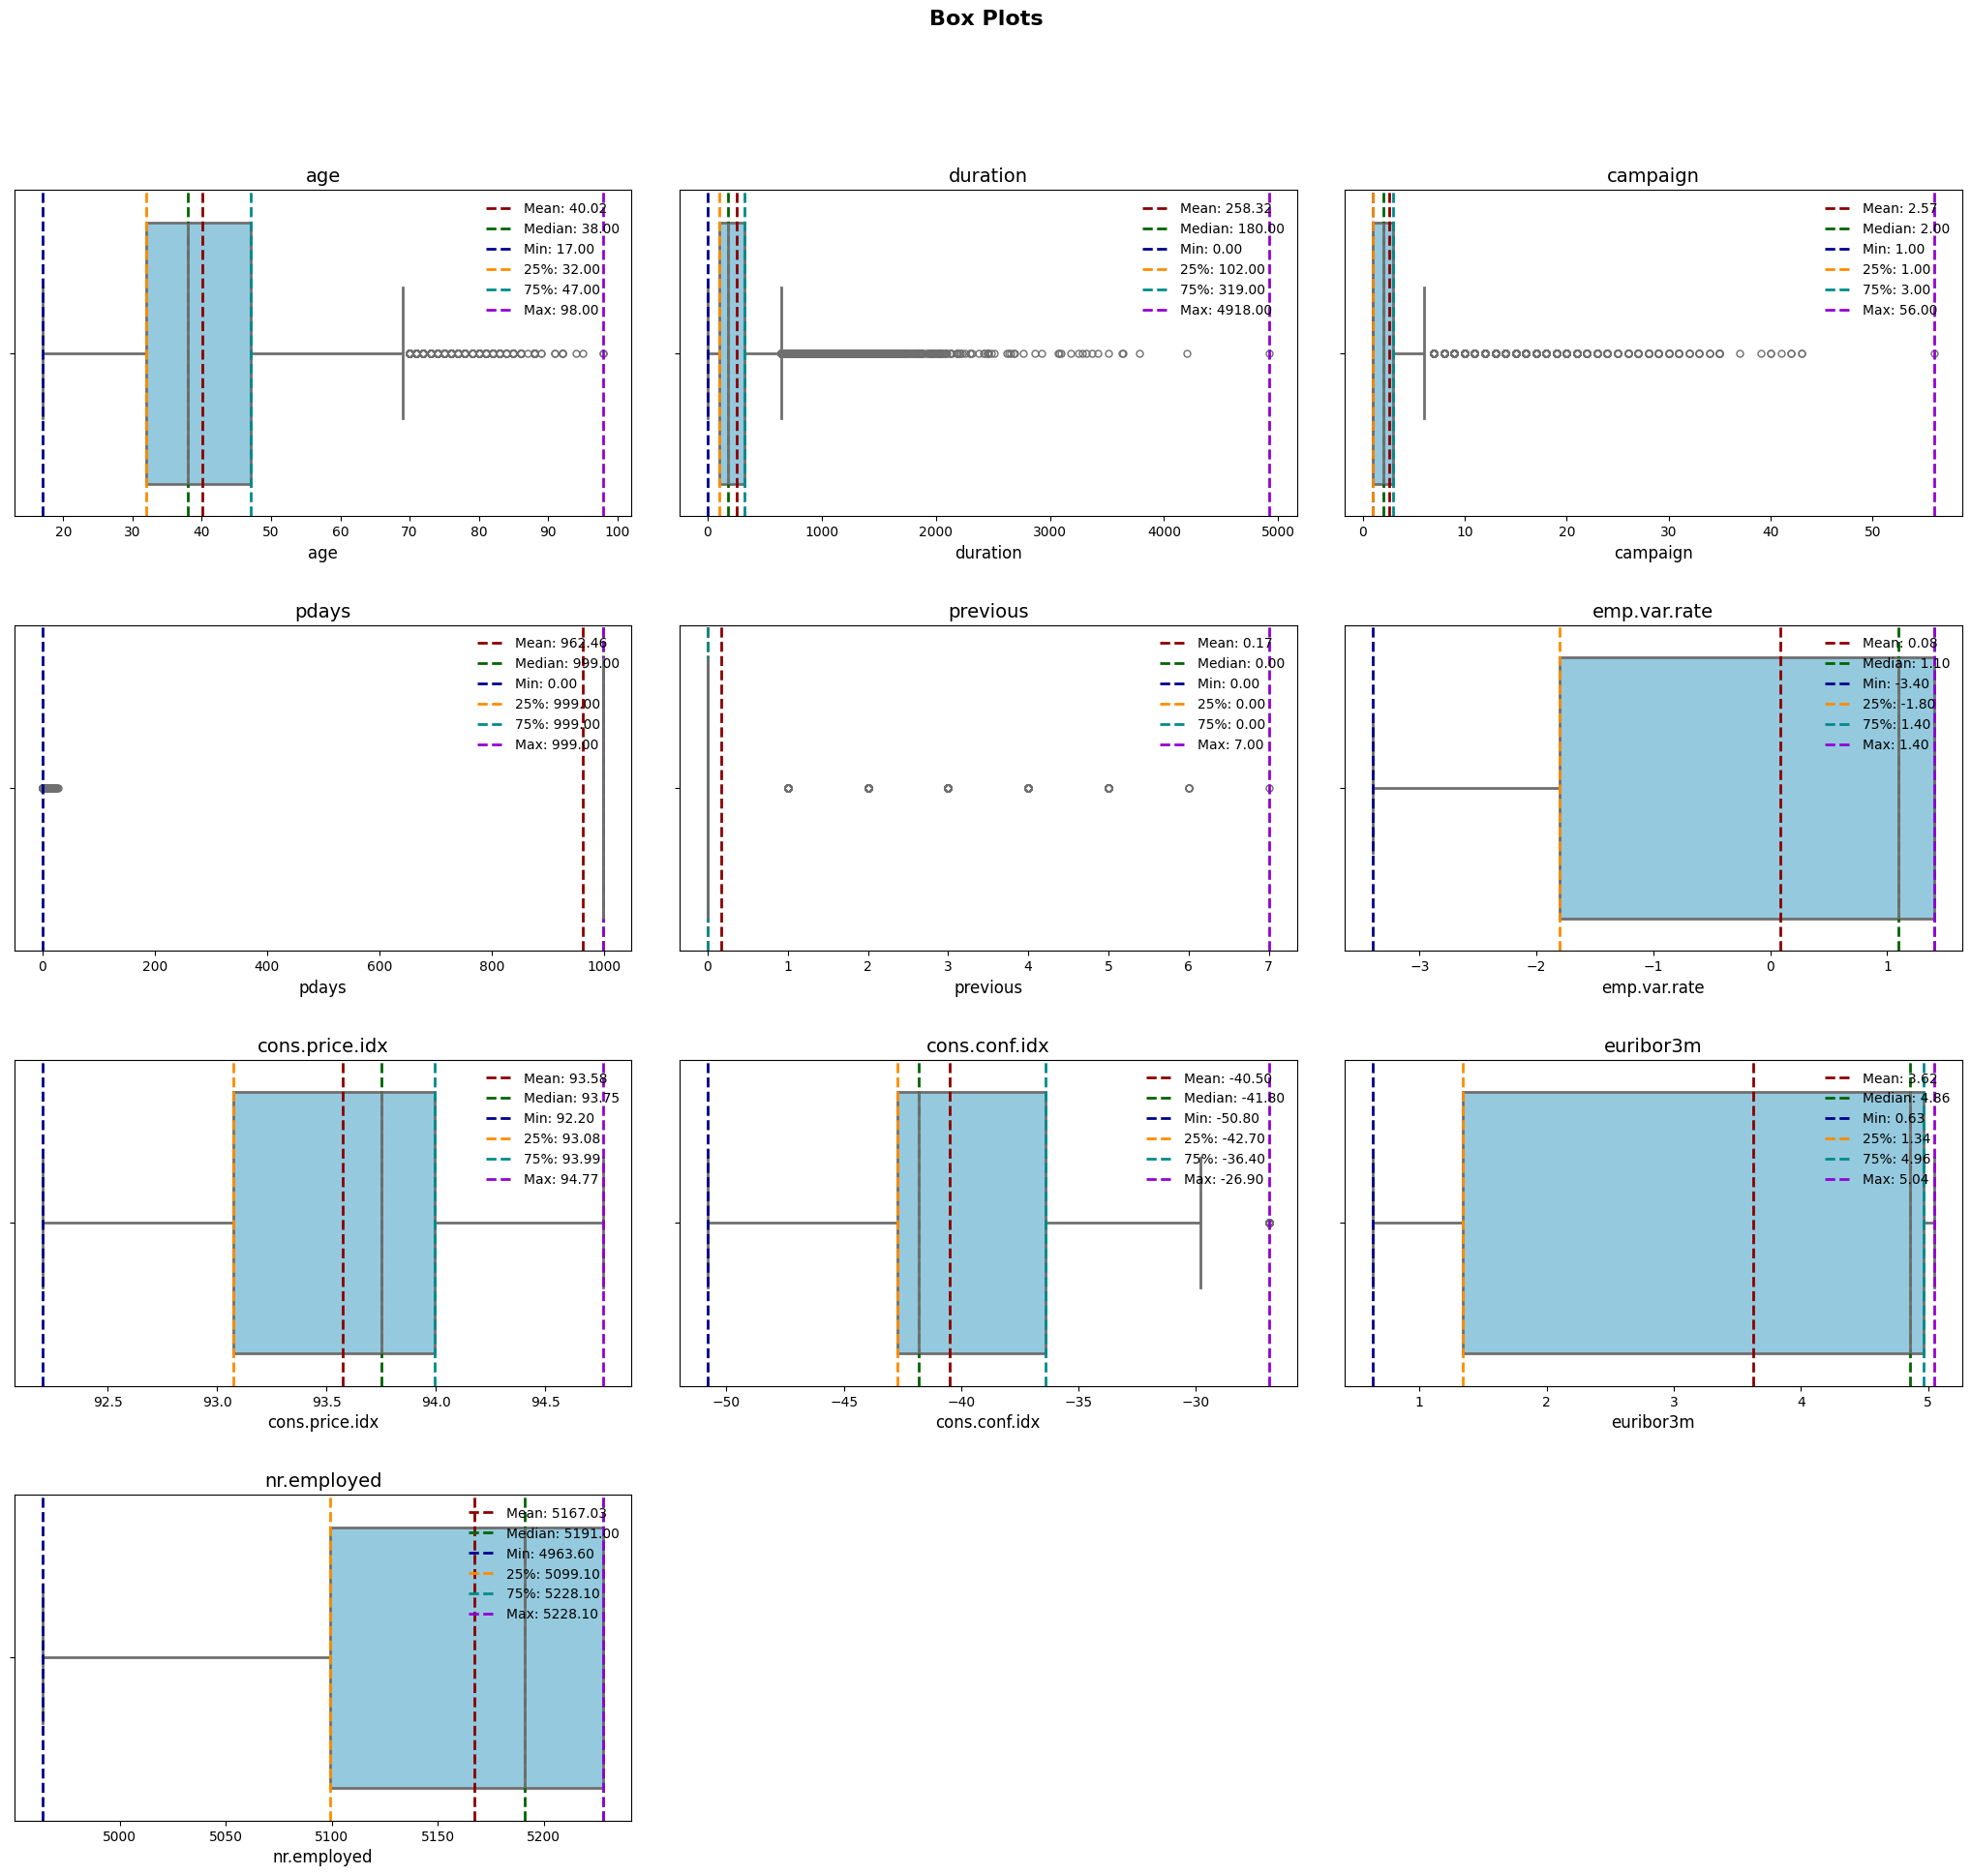

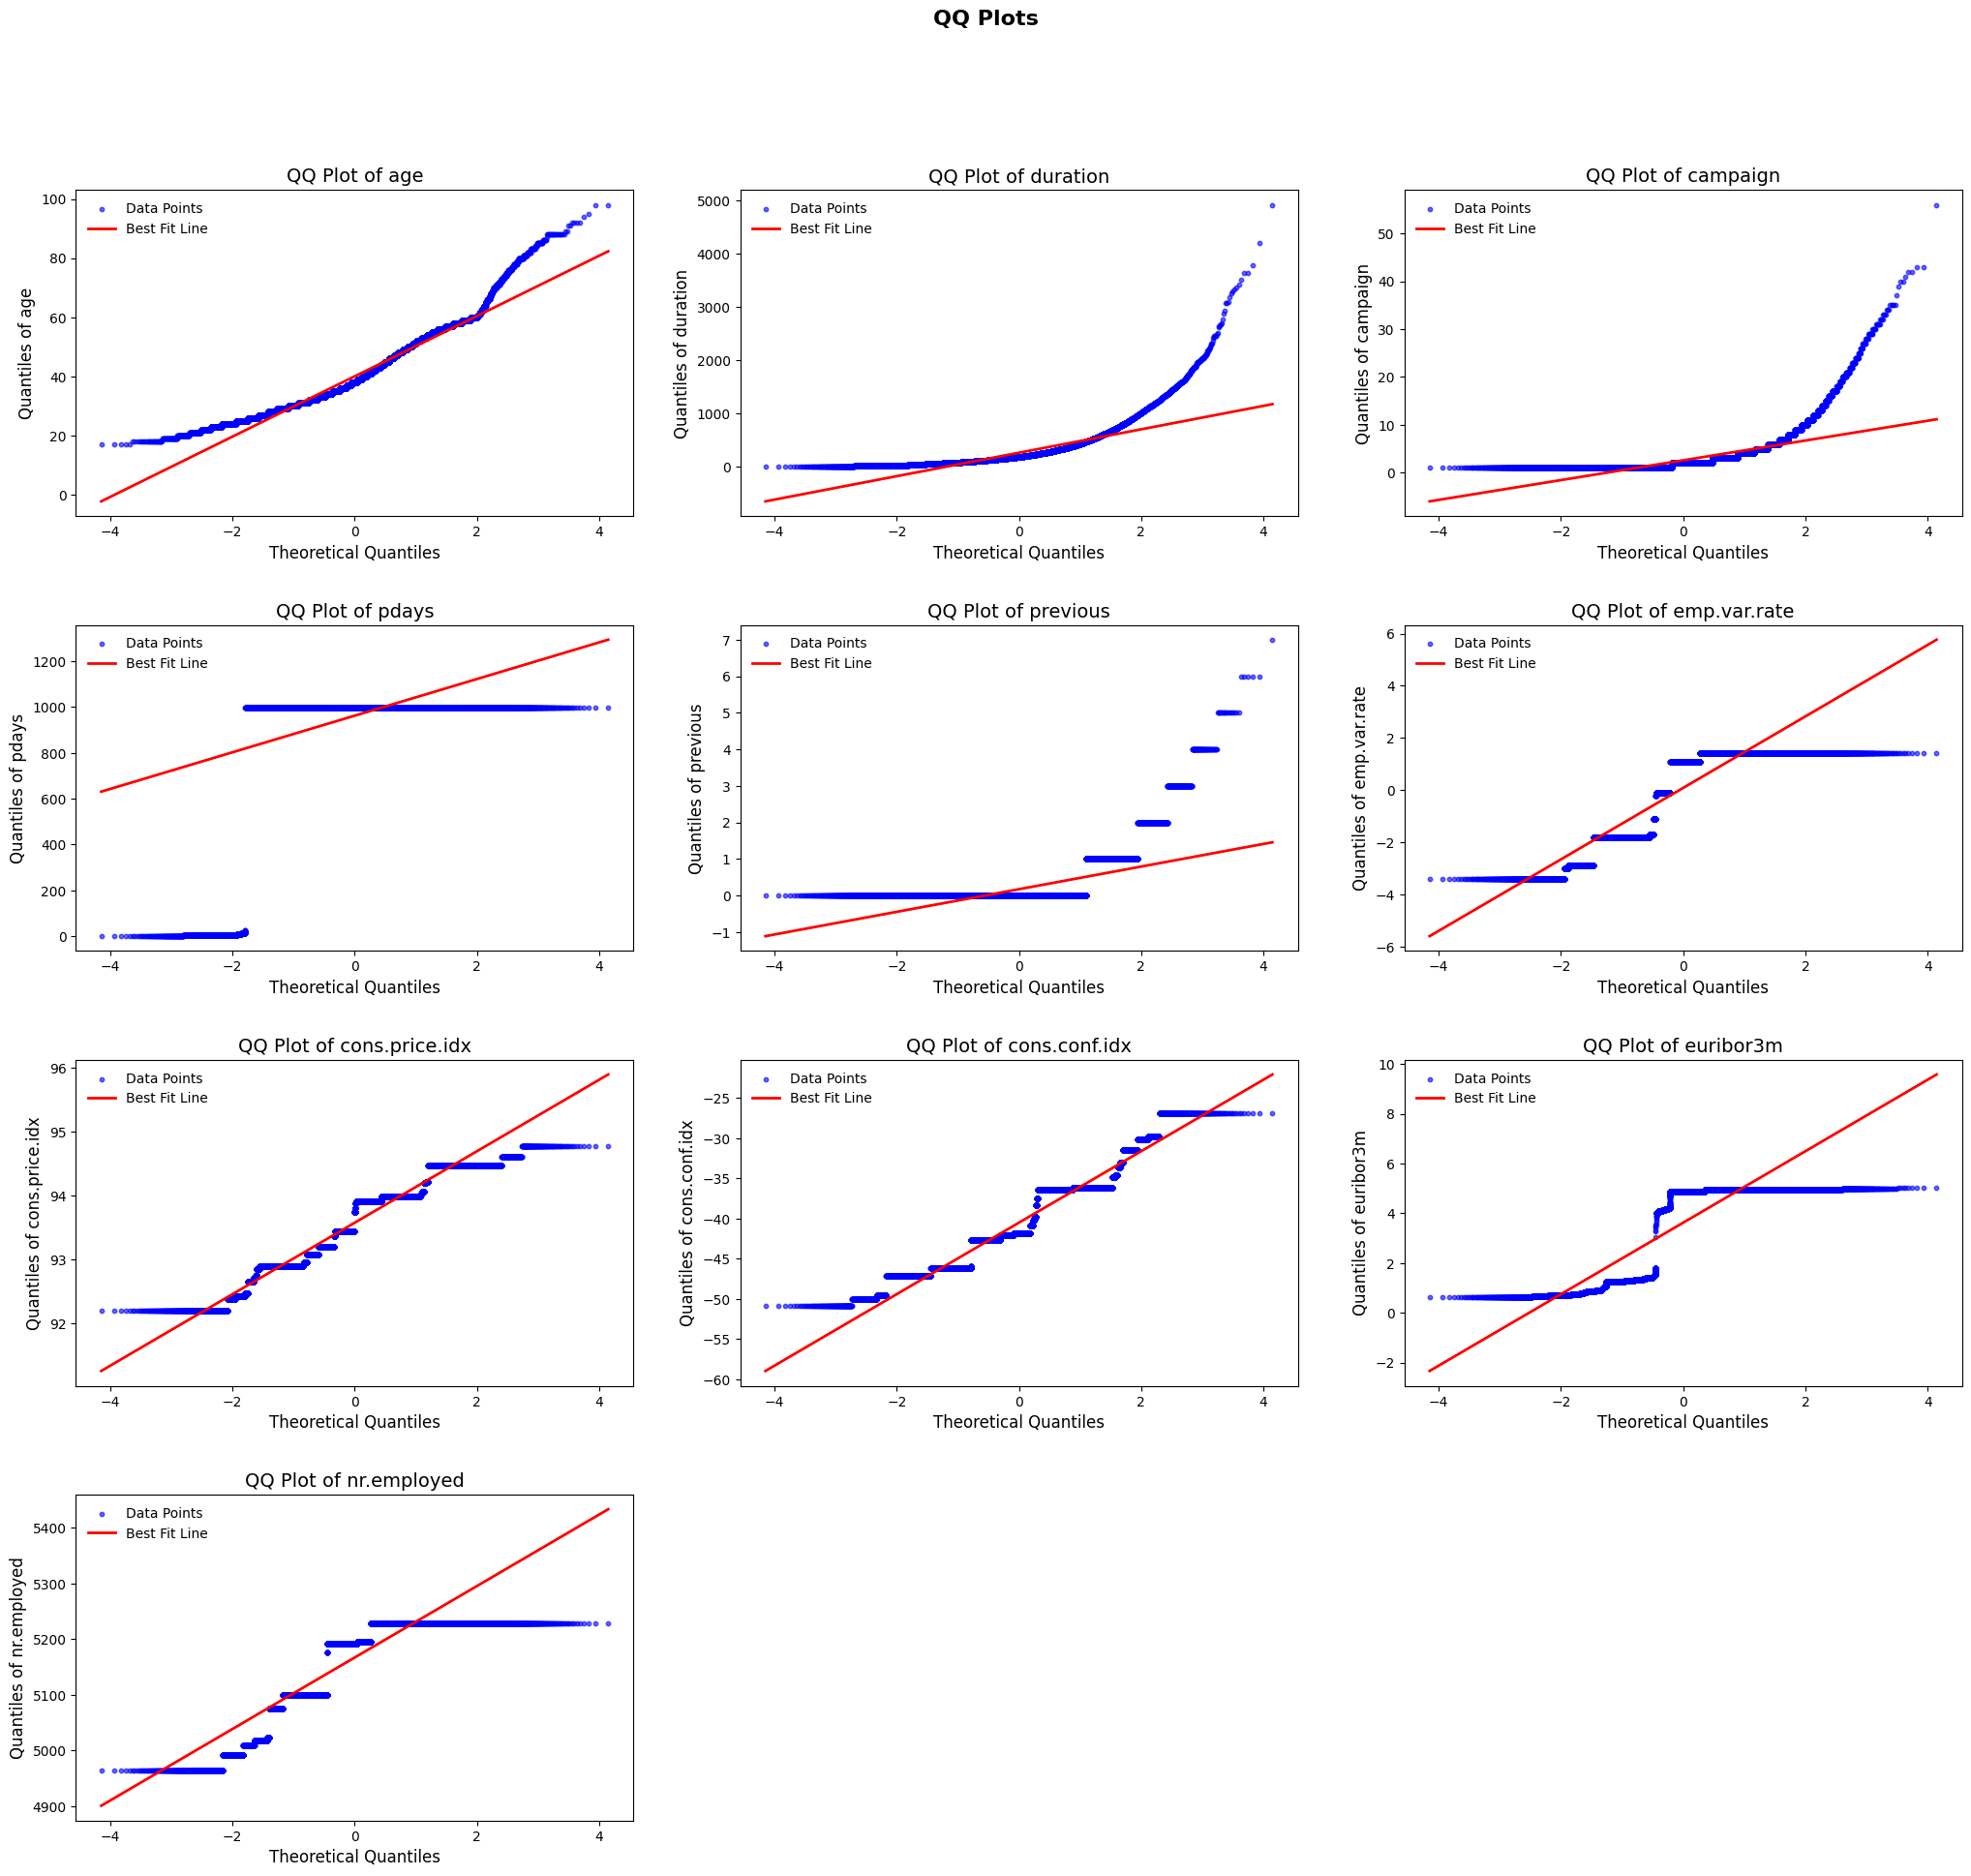

In [39]:
kde_batches(data, batch_num=1)
box_plot_batches(data, batch_num=1)
qq_plot_batches(data, batch_num=1)

Age peaks around 40 with a slight right skew and a few outliers. Duration and campaign are highly skewed, with many short contacts and some extremely long or frequent ones. Pdays and previous mostly sit at zero or 999, indicating minimal prior contact for most customers. Emp.var.rate shows wide variation, while cons.price.idx and cons.conf.idx remain relatively stable with few outliers. Euribor3m has a broad distribution featuring some extreme values, and nr.employed clusters around 5228. Overall, several features deviate from normality, confirming the presence of skewed distributions and outliers.

#### cat_analysis

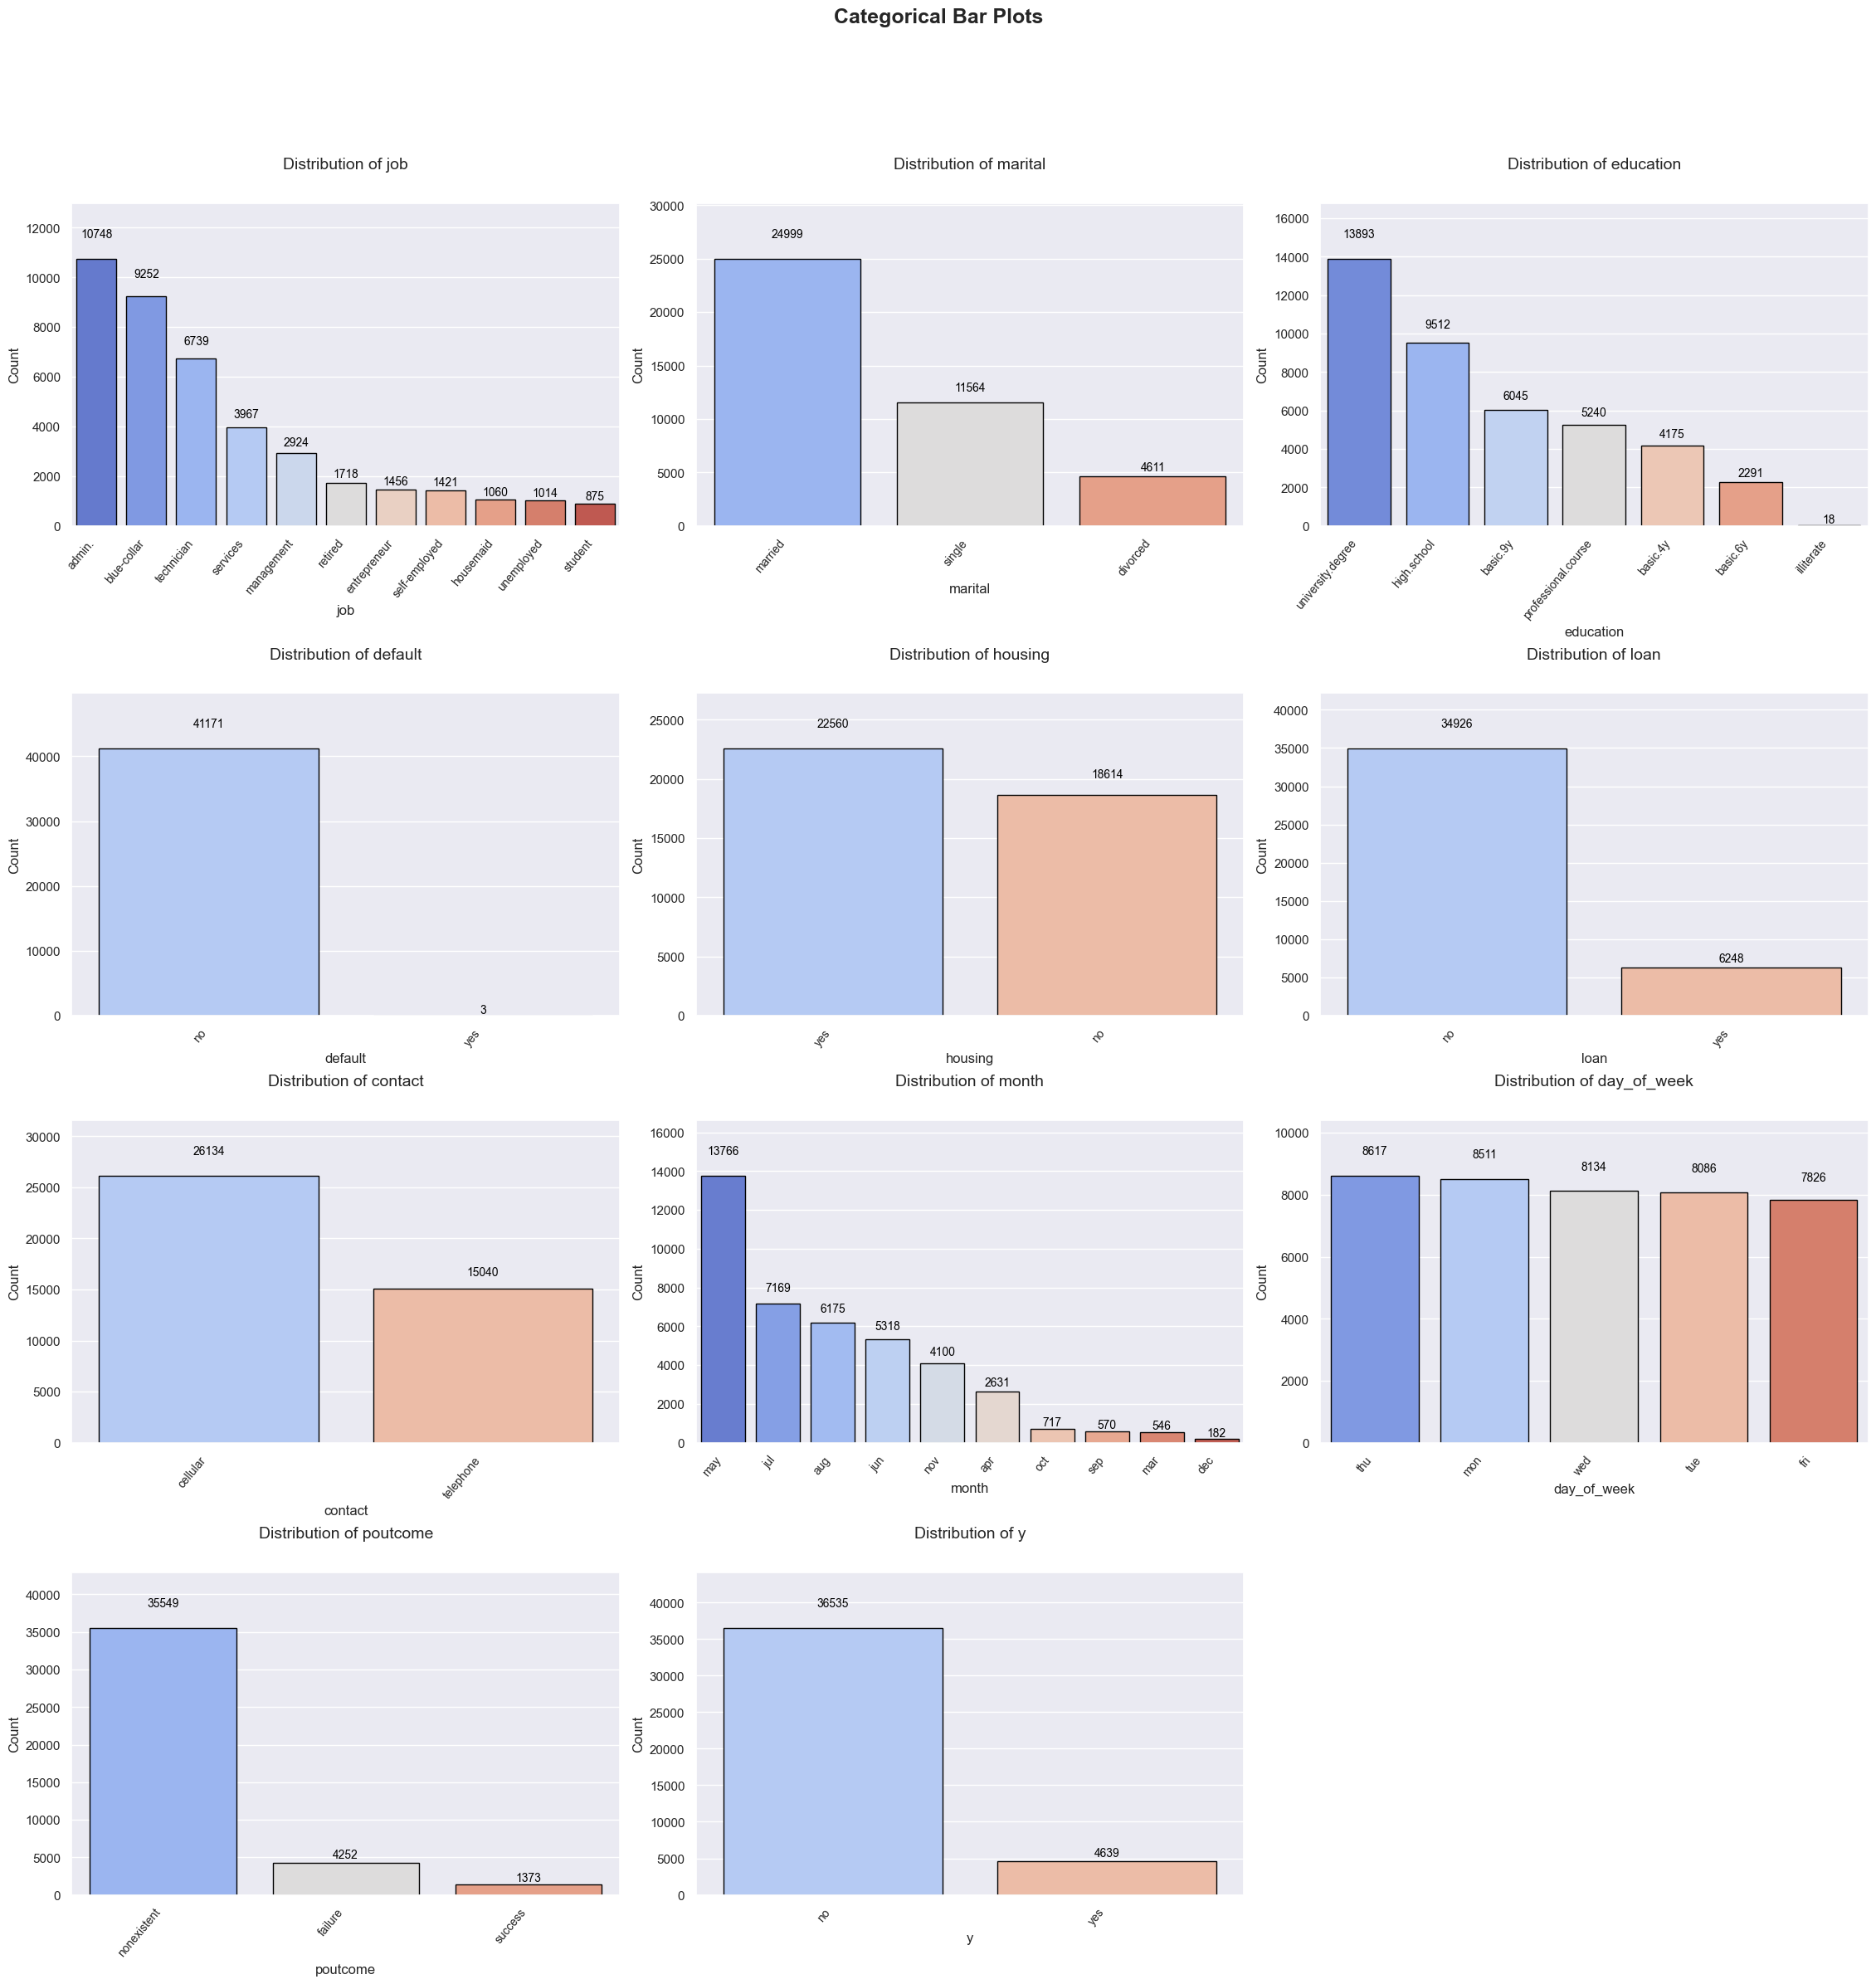

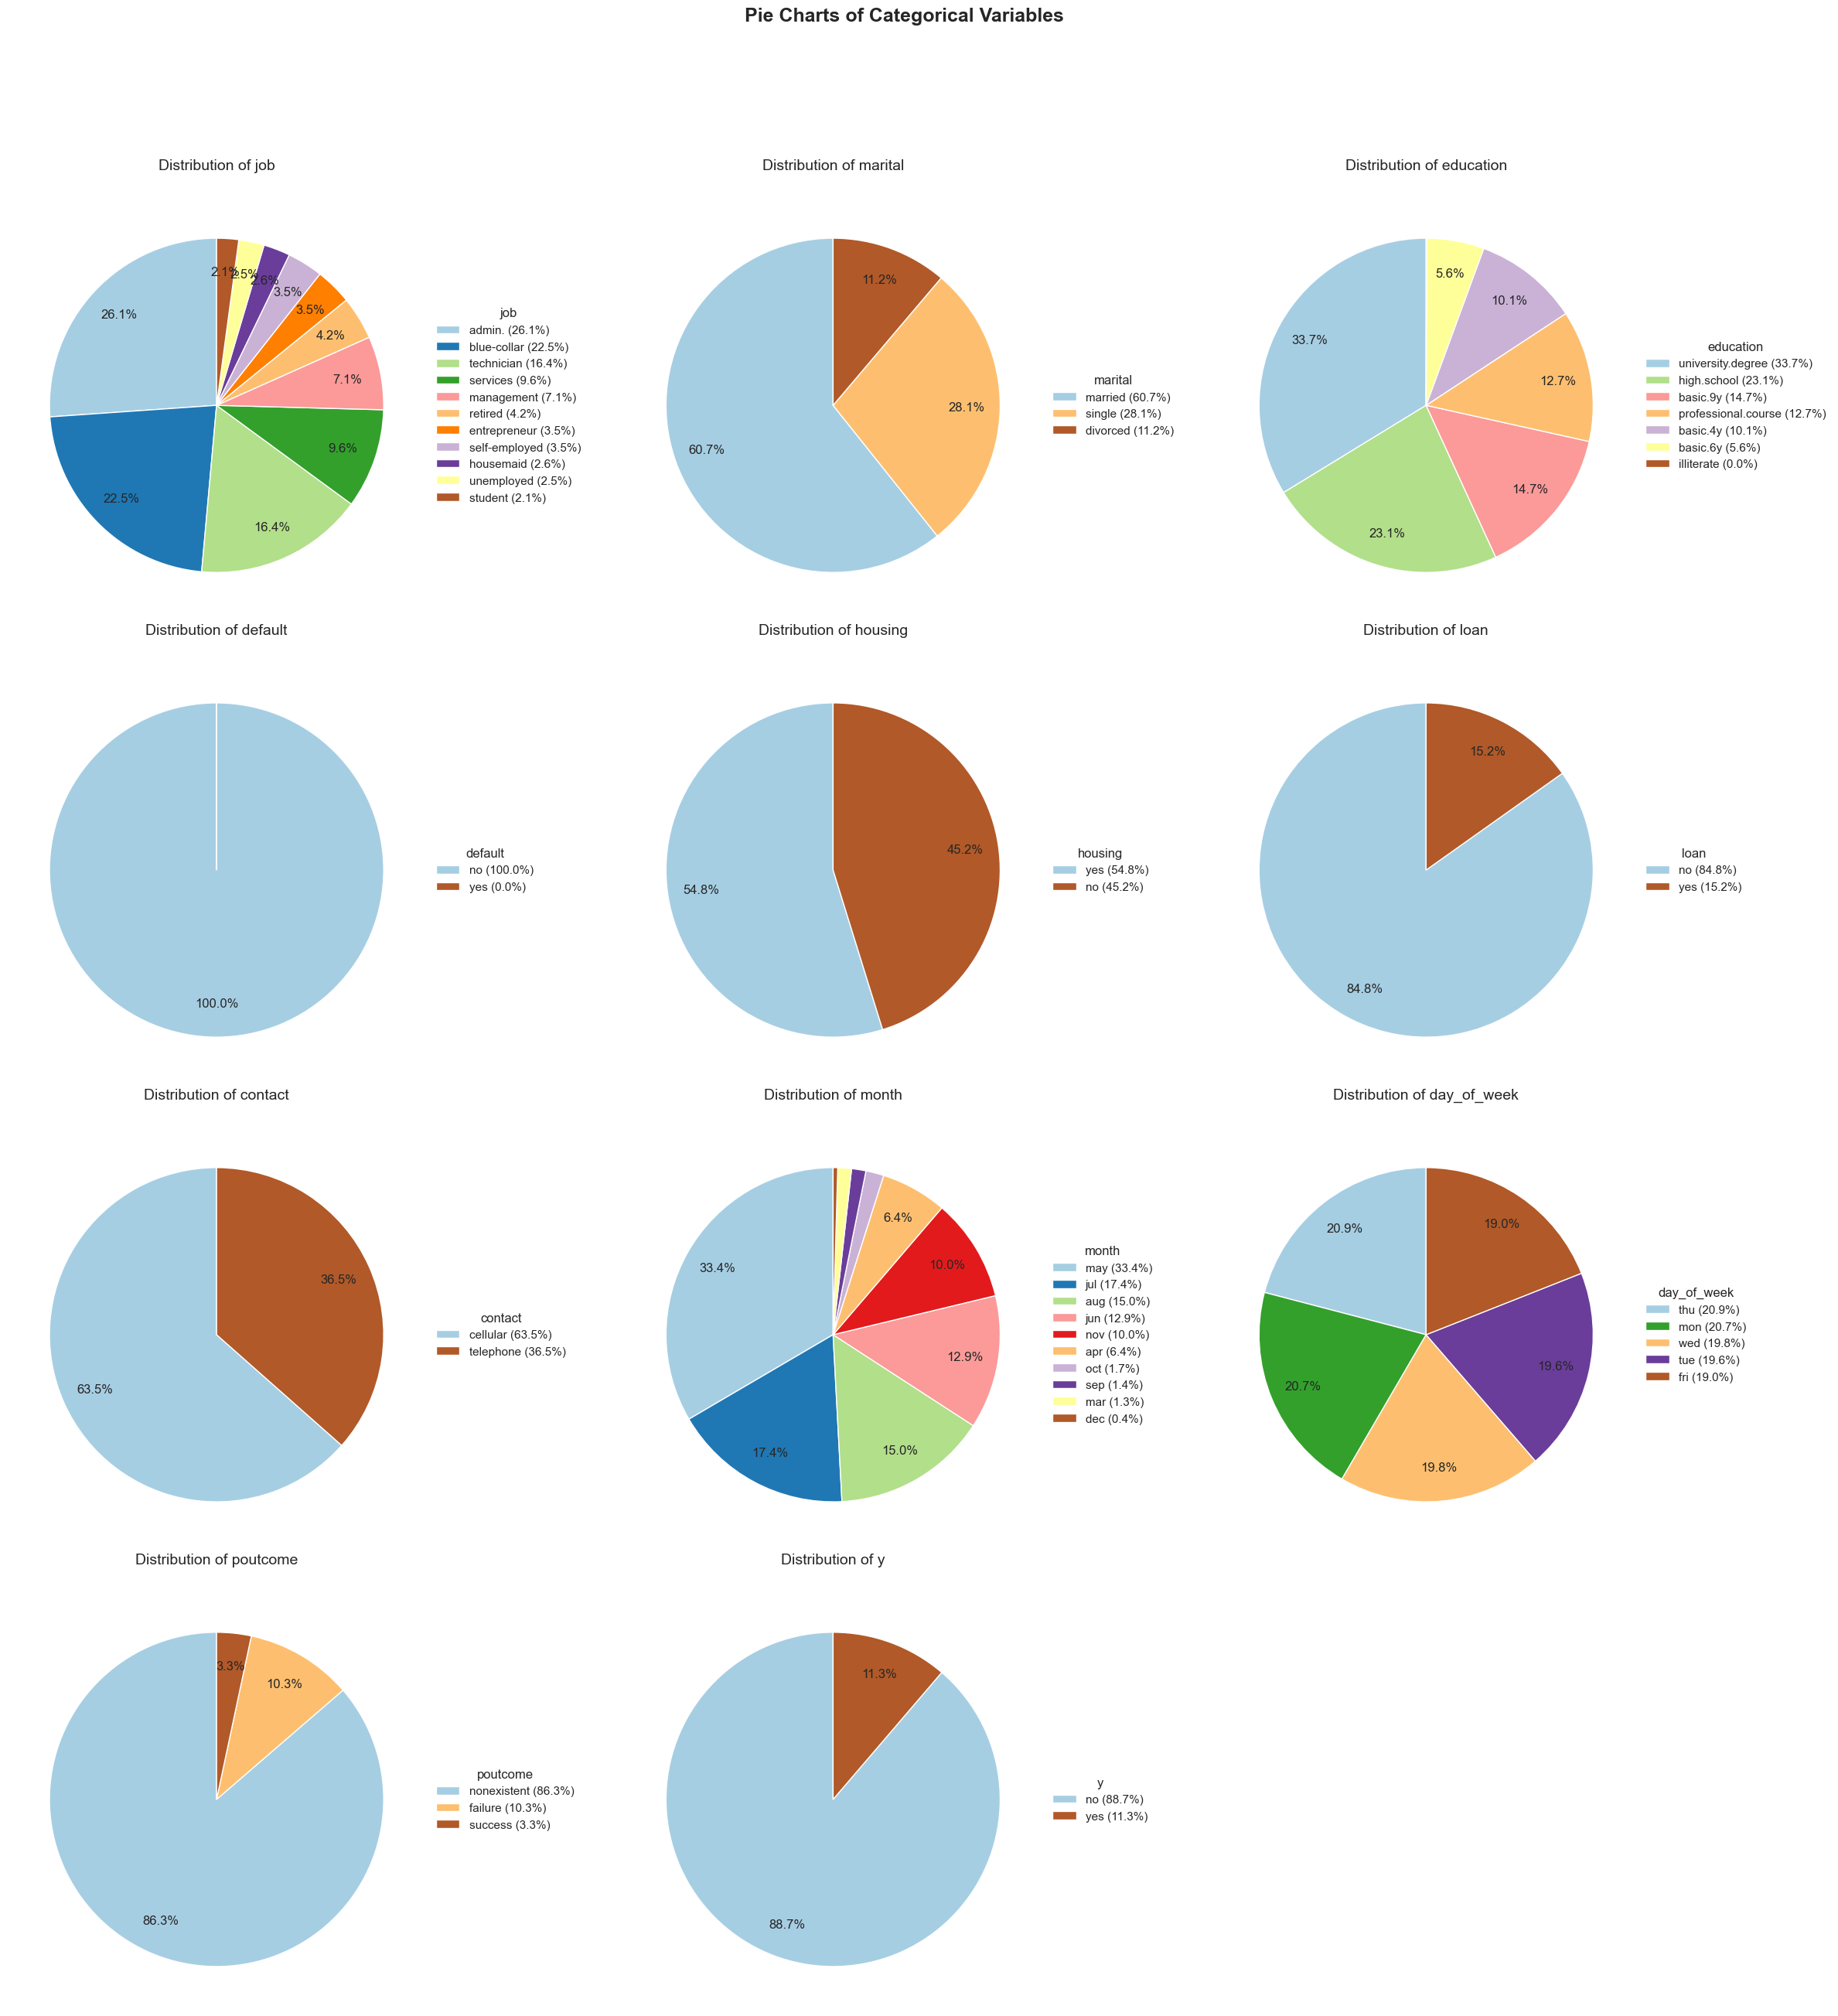

In [40]:
cat_bar_batches(data, batch_num=1)
cat_pie_chart_batches(data, batch_num=1)

Most clients are employed in administrative and blue-collar roles, suggesting that the bank could develop financial products tailored to the unique needs and challenges of these professions to enhance term deposit subscriptions. Additionally, the predominance of married clients indicates an opportunity for marketing strategies that emphasize family and long-term financial security. Educational background information reveals a high number of clients with university degrees or high school education, indicating that more sophisticated banking products could be marketed effectively to this group.

Regarding client financial status, the majority have no credit defaults, and many have housing loans, which could influence their financial decisions and risk profiles. The preference for contact via cellular phone suggests that a more personal approach might be more effective. Seasonal variations in contact frequencies, with peaks in months like May, July, and August, suggest that these periods may be optimal for marketing efforts. However, the low conversion rate of calls to actual term deposits (11.3%) highlights the need for improved targeting and offer adjustments to meet client needs and preferences more effectively. This comprehensive analysis provides a foundation for refining the bank's strategies to increase the effectiveness of their campaigns and improve customer engagement.

### Bivariate & Multivariate Analysis

- euribor3m: This variable is a daily indicator and reflects the state of the economy.

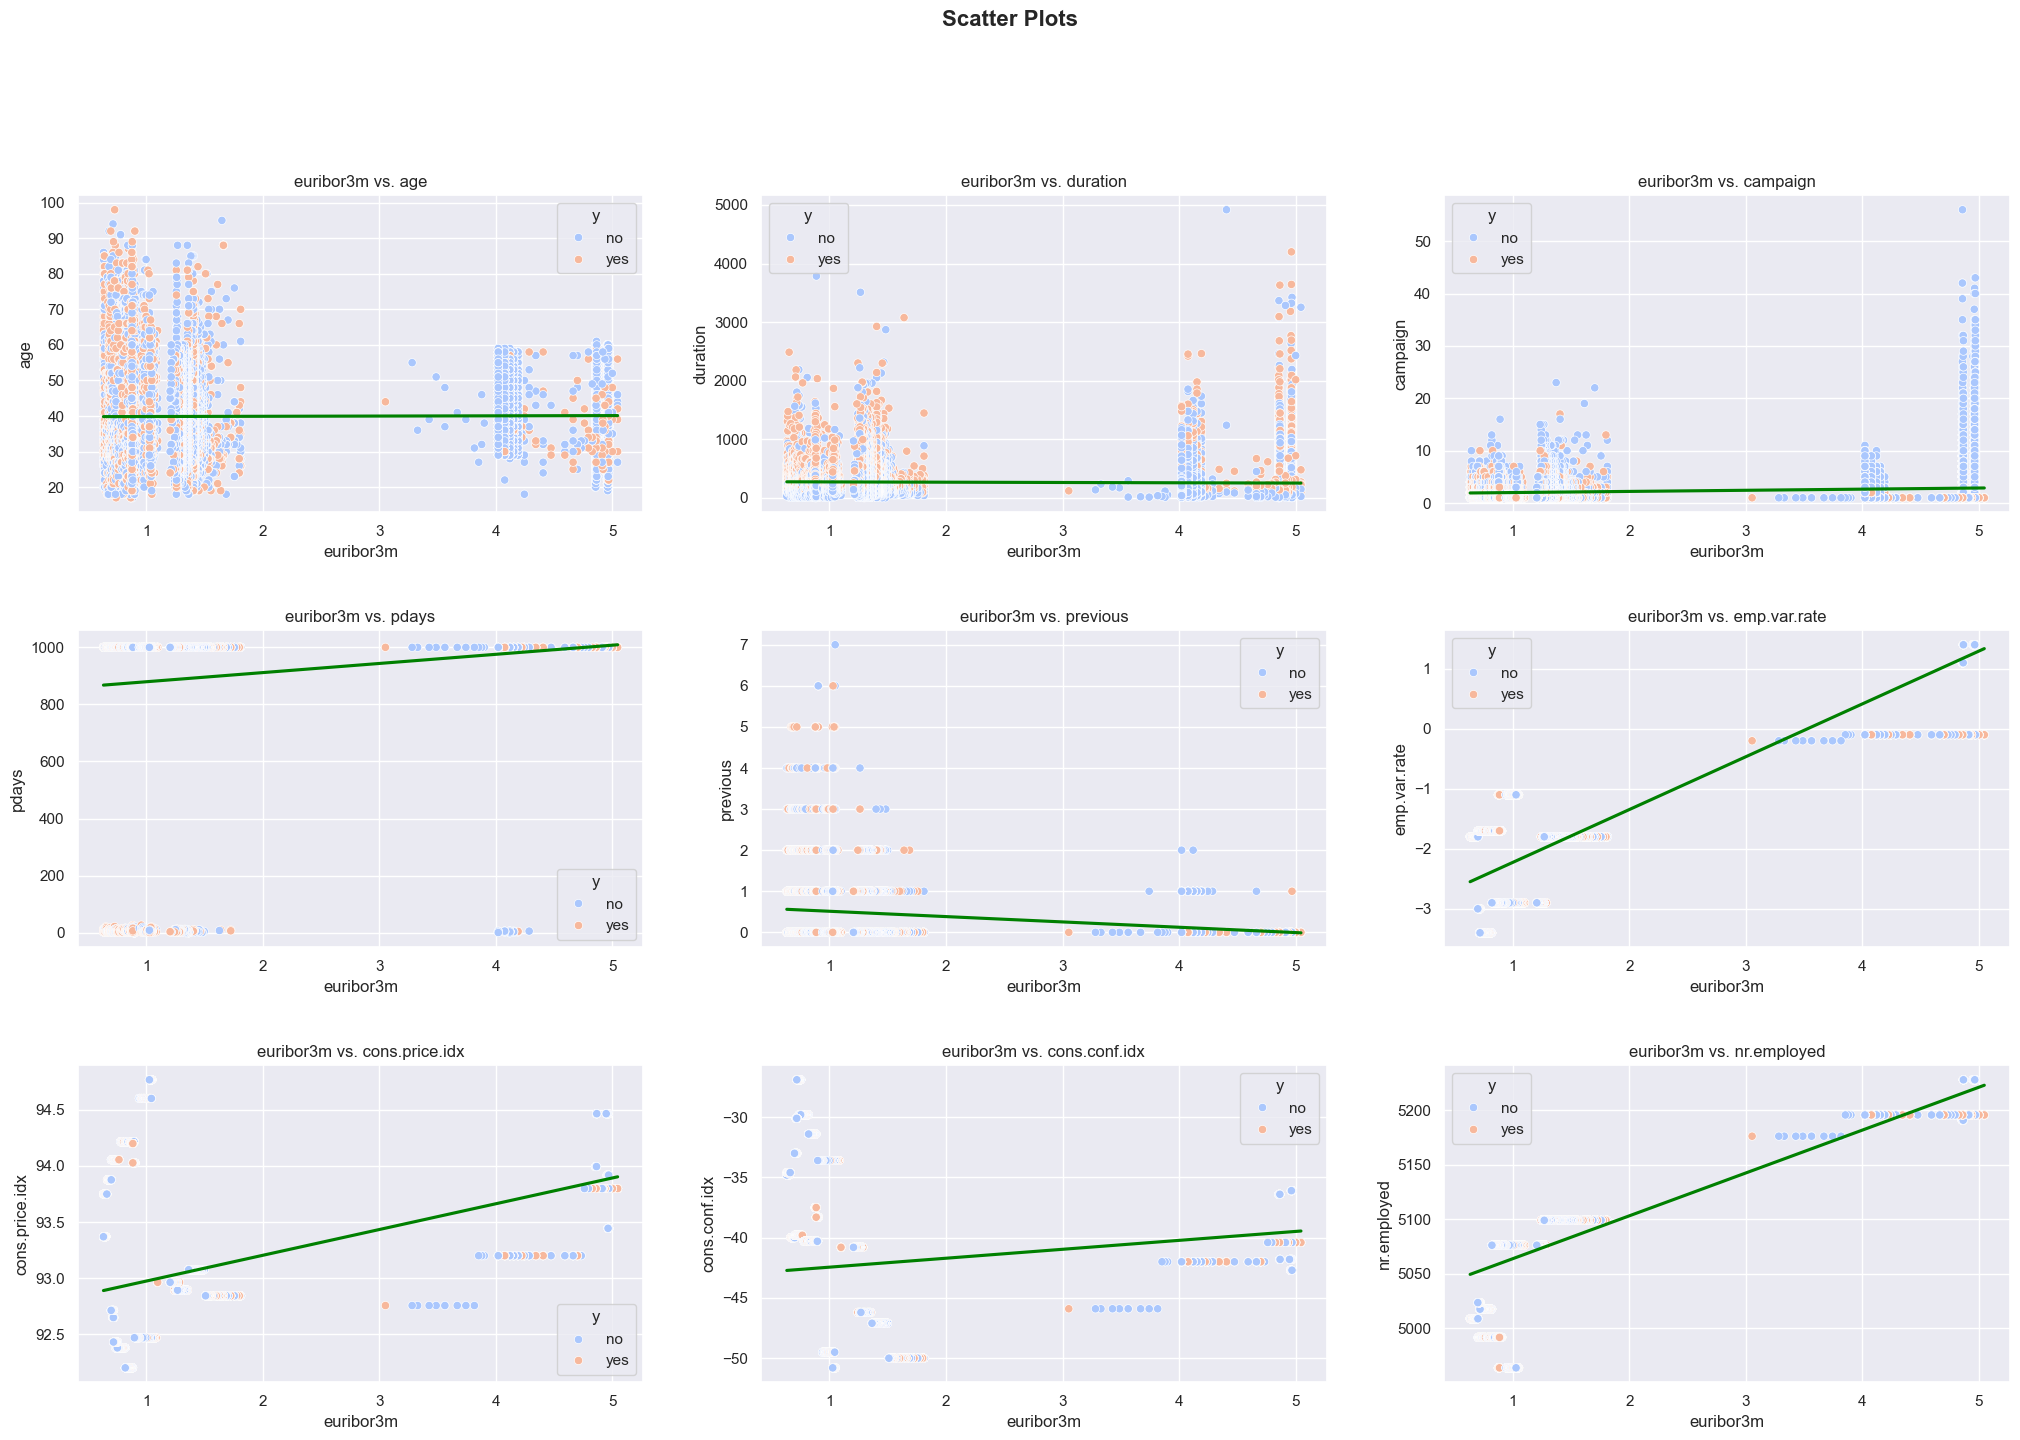

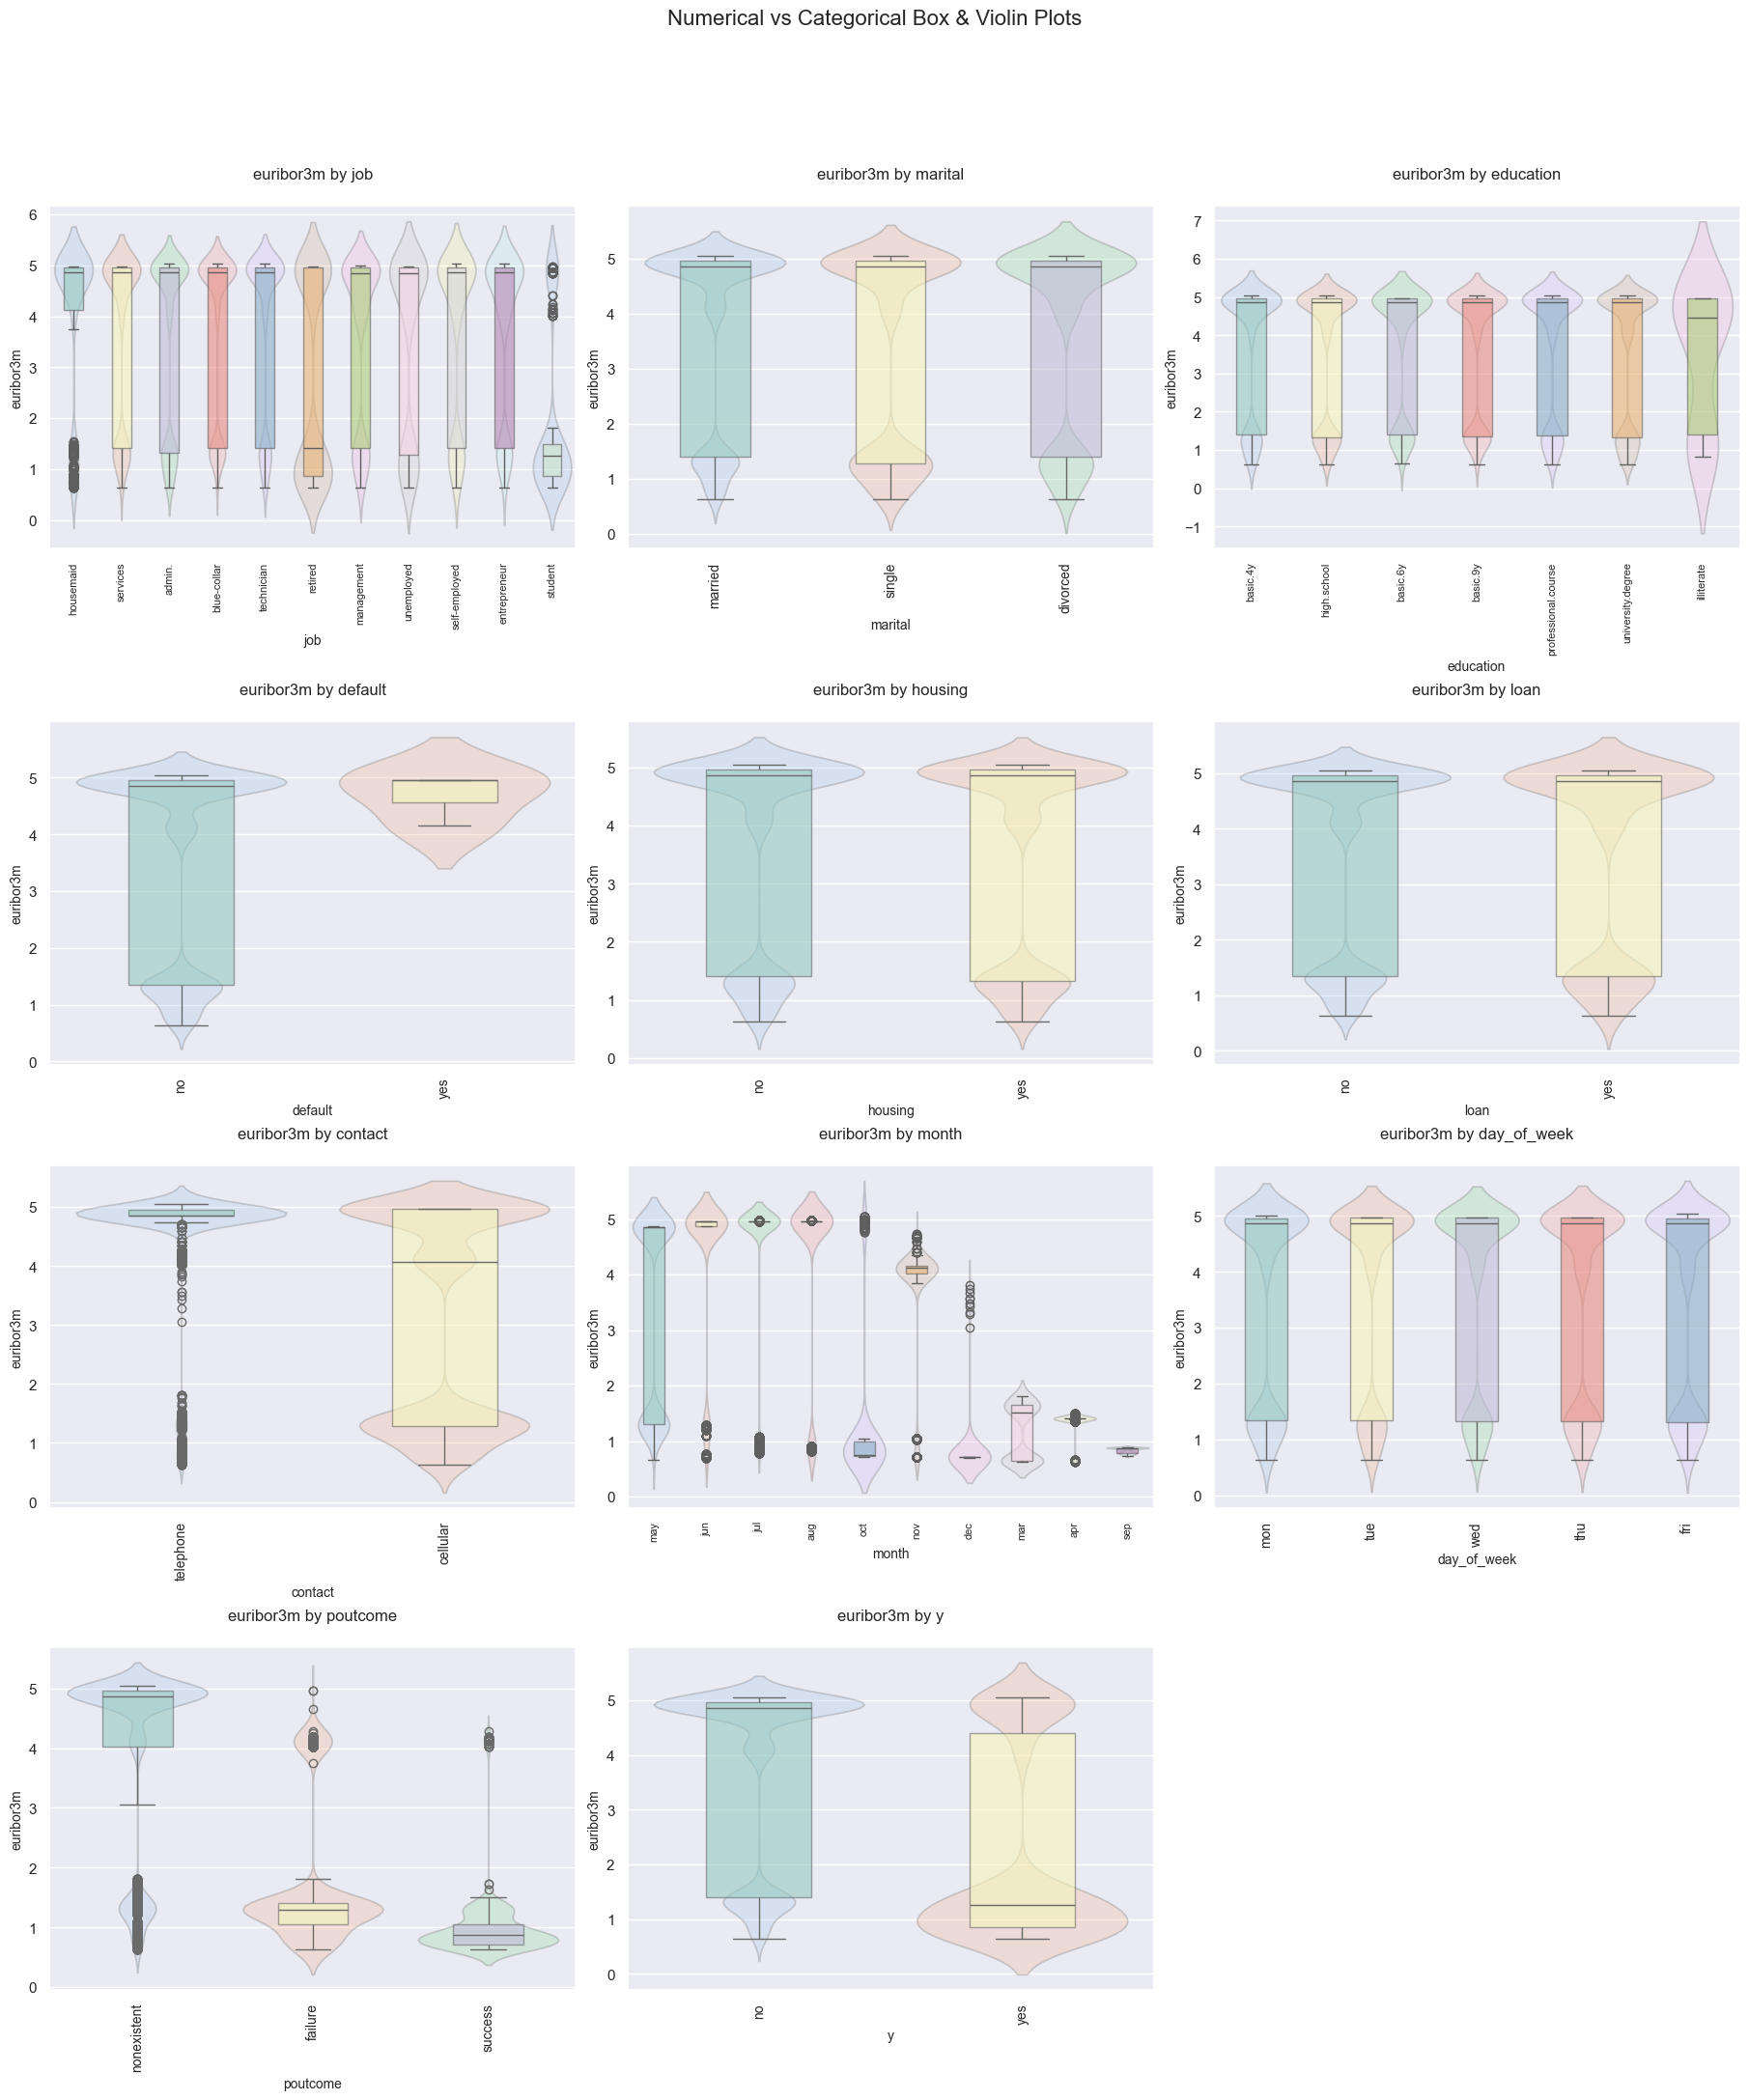

In [41]:
num_vs_num_scatterplot_pair_batch(data, pair_num=8, batch_num=1, hue_column="y")
num_vs_cat_box_violin_pair_batch(data, pair_num=8, batch_num=1, high_cardinality_limit=22)

The scatter plots illustrate that the Euribor 3-month rate, a pivotal indicator of lending costs, shows a strong correlation with the employment variation rate and the number of employees, implying that rising interest rates often coincide with improved economic conditions. Furthermore, while longer call durations generally correlate with higher probabilities of a ‘yes’ outcome for term deposits, this relationship appears less tied to the Euribor rate, suggesting that personal interaction may outweigh broader economic forces in guiding client decisions. Age exhibits minimal correlation with the Euribor rate, indicating that economic conditions do not significantly sway clients’ term deposit choices across different age brackets. Box and violin plots demonstrate that the Euribor rate varies slightly across job types, education levels, and marital statuses, highlighting that demographic factors can subtly shape how clients respond to economic conditions. Seasonality is evident in month-wise plots, showing that Euribor rate fluctuations could inform the bank’s strategic timing for promoting term deposits. Insights from previous campaign outcomes (poutcome) indicate that past economic climates may leave a lingering effect on current decisions, as variations in the Euribor rate during earlier campaigns seem to carry over to present choices. Meanwhile, the type of job (like management or retirement) may reveal different sensitivities to interest rate shifts, suggesting that tailored messaging could be more effective. Education levels also play a nuanced role; although the Euribor’s broader economic impact remains a backdrop, knowledge and financial literacy may shape clients’ responses. In contrast, marital status shows smaller distinctions, implying that life stage factors intersect with economic indicators in more subtle ways. Overall, these findings highlight that while macroeconomic signals—embodied by the Euribor rate—underpin consumer sentiment, individualized elements such as call duration and demographic attributes can be decisive. This interplay suggests that banks may benefit from a dual strategy: capitalizing on favorable economic conditions by amplifying outreach efforts, and simultaneously enhancing personal interactions during slower economic periods. By using insights on who responds more strongly to interest rate changes, the bank can refine campaign timing and targeting for optimal results. Persistent outliers in call duration and campaign outcomes also underscore the importance of personalized engagement tactics. Although high Euribor rates often mirror robust economies, not all clients are uniformly swayed by these macro signals, reinforcing the need to adapt strategies to distinct segments. Lastly, the capacity to balance economic data with personalized approaches emerges as critical in maximizing term deposit uptake, demonstrating the intricate interplay between individual behaviors and the broader financial landscape.

- nr.employed: This is a quarterly indicator of employment trends,

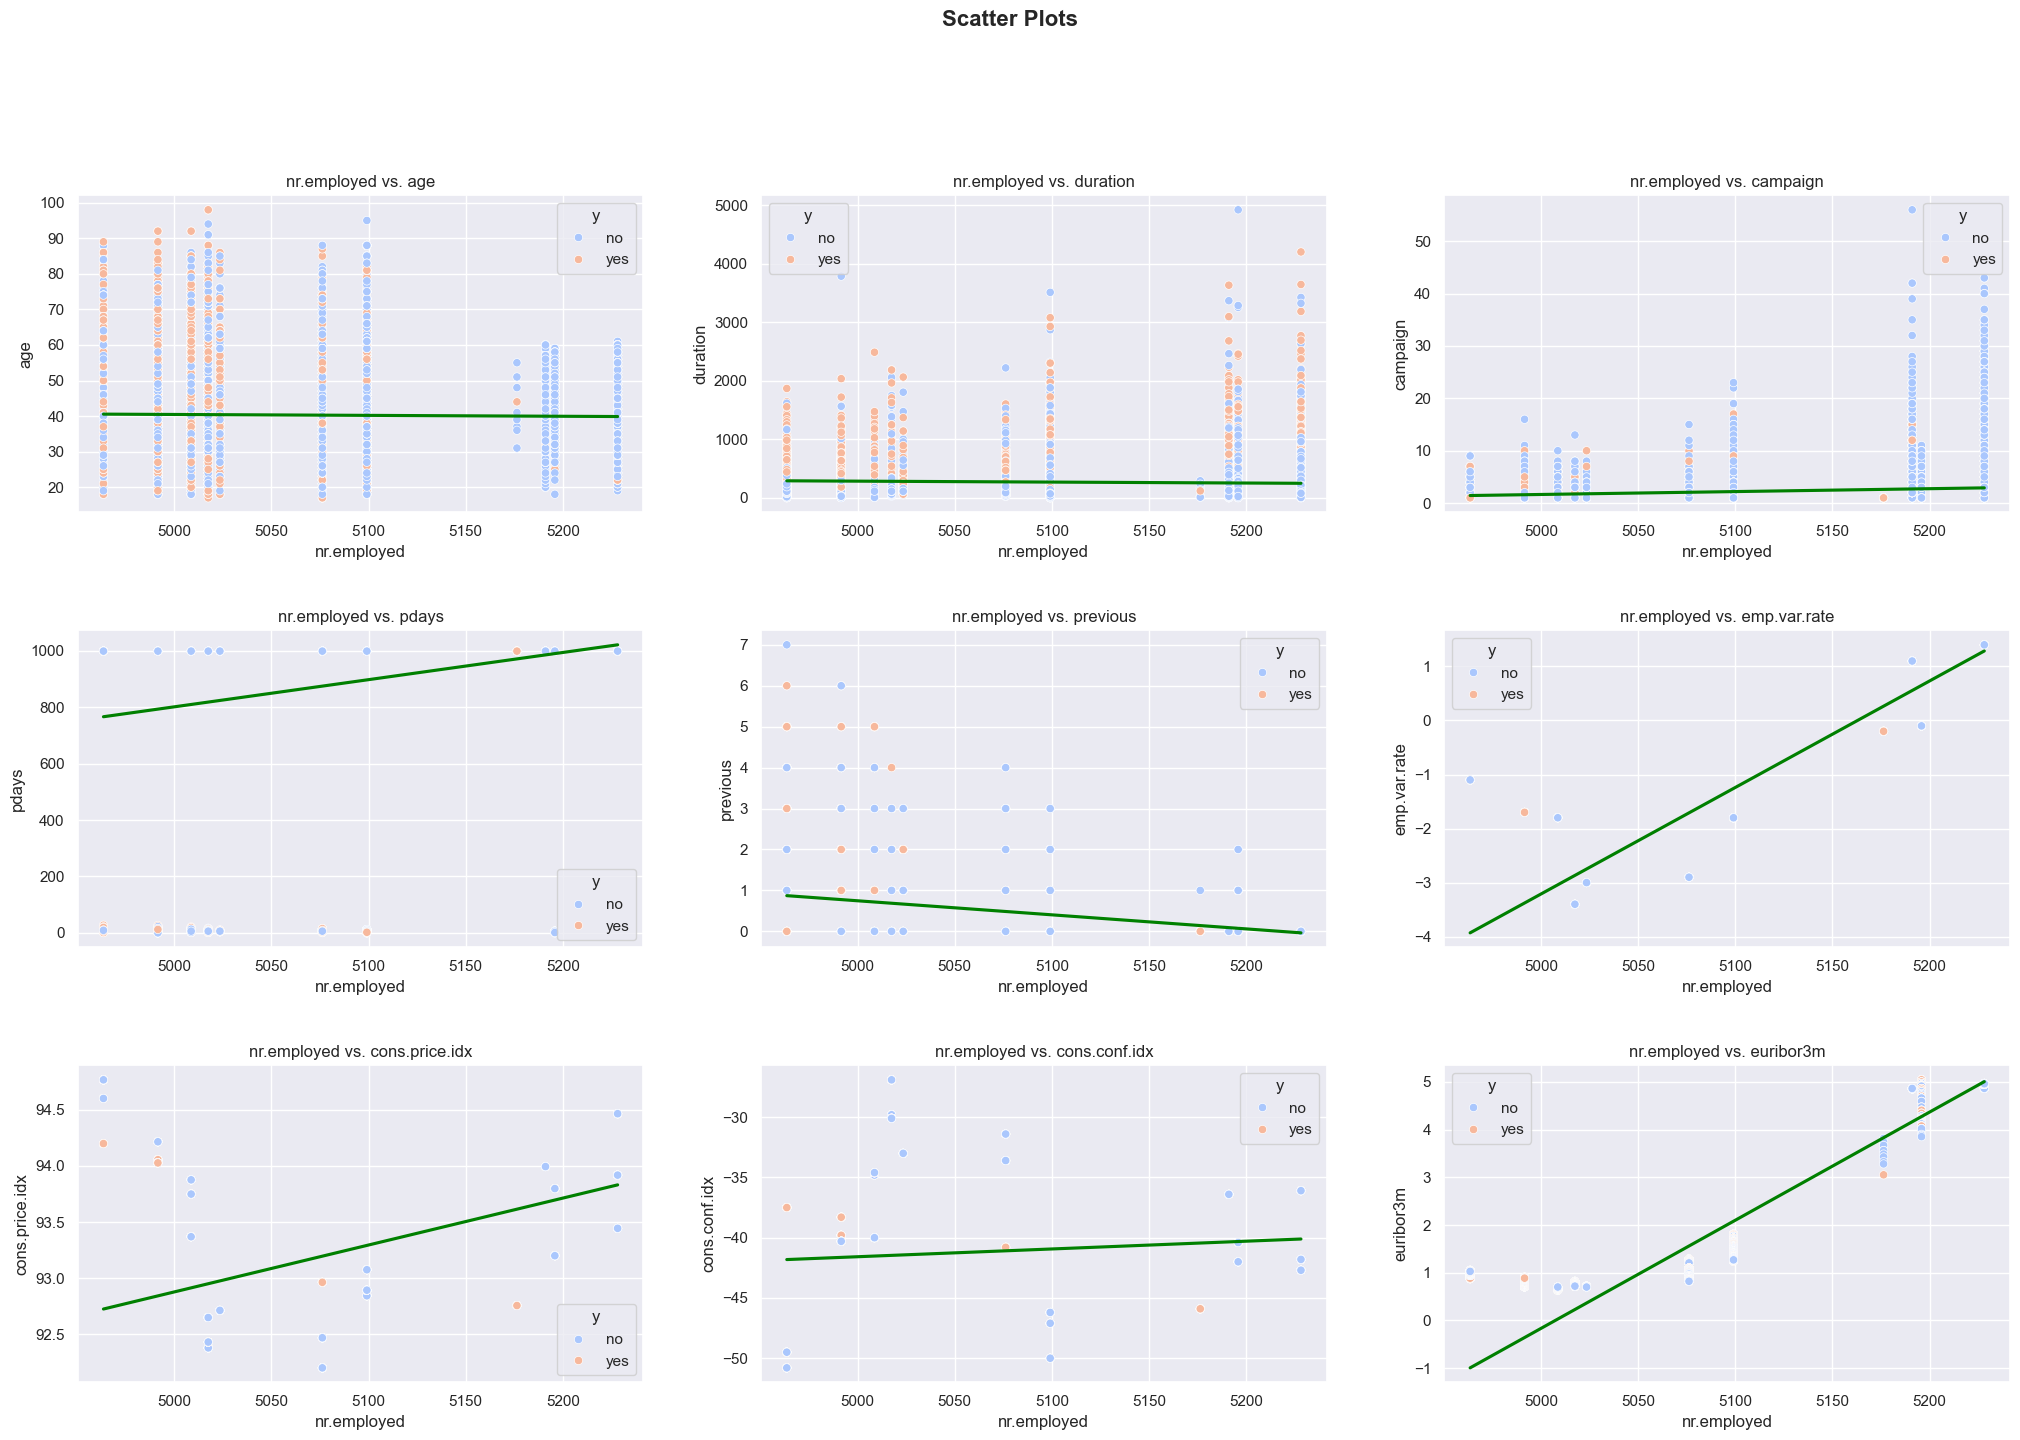

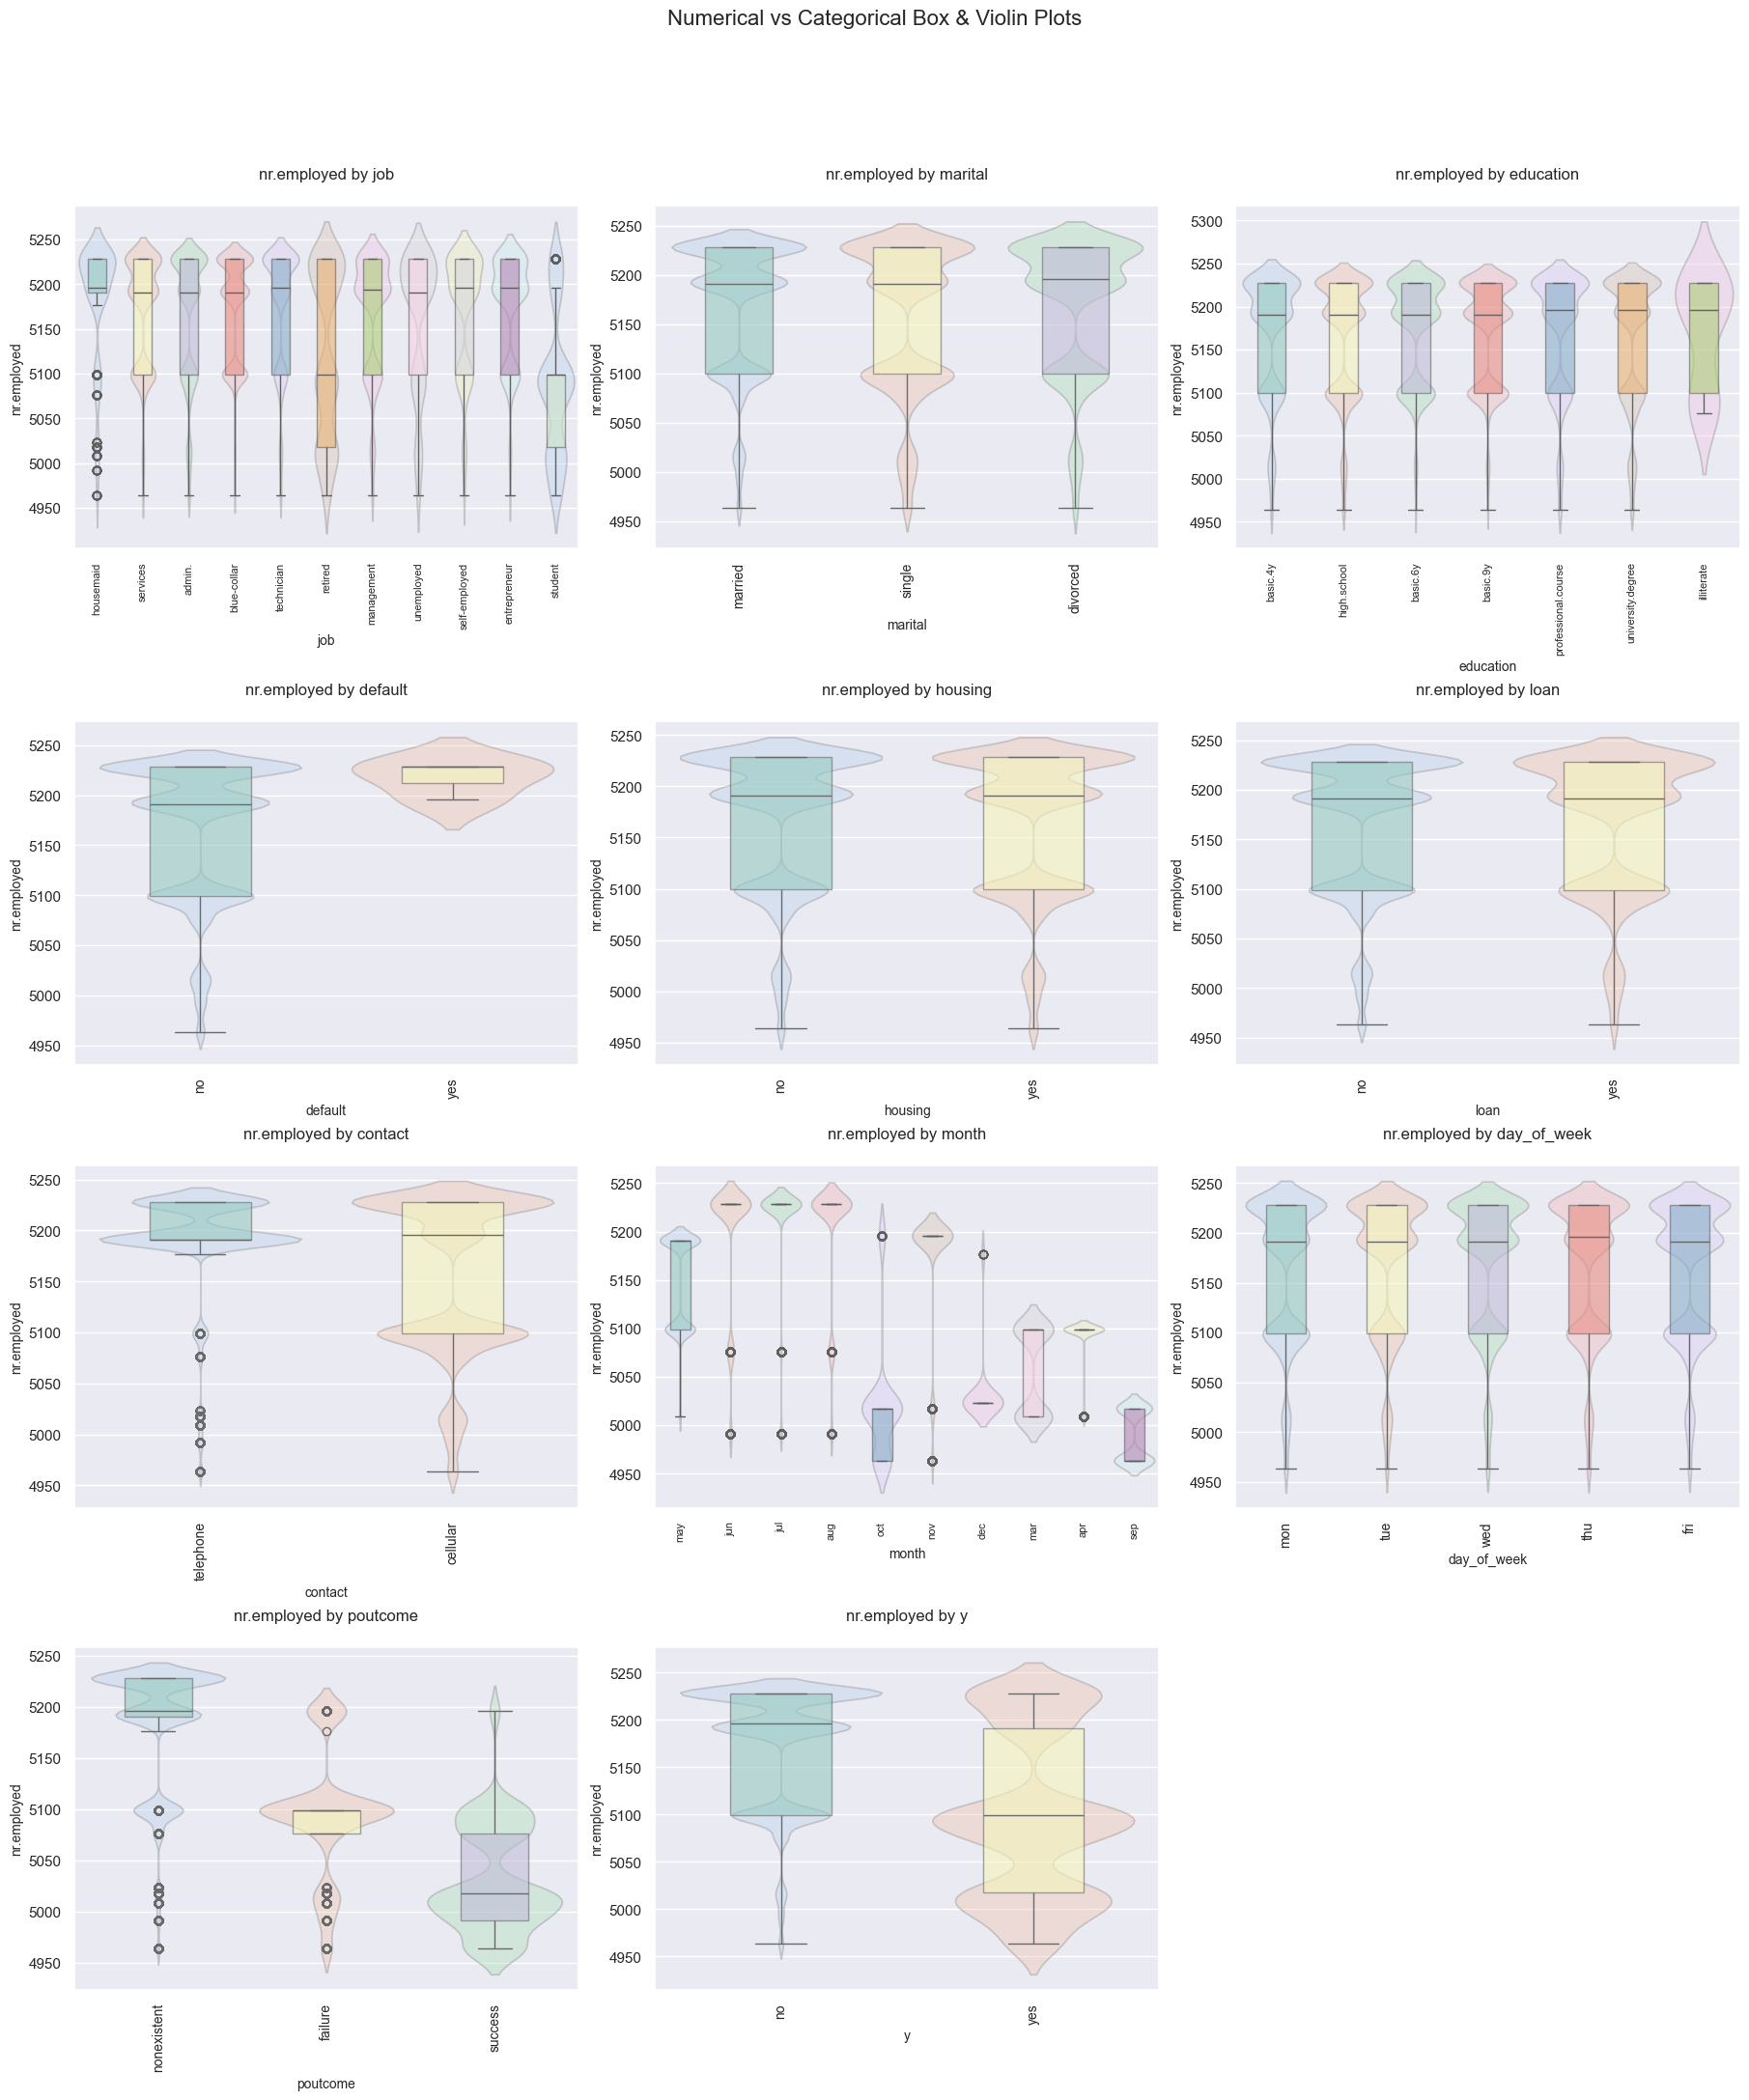

In [42]:
num_vs_num_scatterplot_pair_batch(data, pair_num=9, batch_num=1, hue_column="y")
num_vs_cat_box_violin_pair_batch(data, pair_num=9, batch_num=1, high_cardinality_limit=22)

The scatter plots show a strong positive correlation between higher employment levels at the bank and certain economic indicators, such as the employment variation rate and the Euribor 3-month rate, suggesting that robust economic conditions might boost the bank’s operational capacity.  
They also reveal no meaningful link between the number of employees and call duration or the number of campaigns, indicating that staffing levels do not necessarily govern the depth or frequency of individual client interactions.  
However, pdays tends to be consistently high when the bank’s employment level is high, implying that more employees could facilitate more proactive client engagement and re-engagement.  
The box and violin plots segmented by job, marital status, and education highlight that different client groups may experience varying degrees of engagement, reflecting how staffing strategies might cater to specific demographics.  
Month-by-month and day-of-week shifts in the number of employees hint at potential staffing adjustments aimed at capitalizing on peak periods or aligning with seasonal campaigns.  
Moreover, the data shows that previous marketing successes (poutcome) and current positive term deposit decisions (y) often coincide with higher staffing levels, strengthening the idea that greater human resources can improve marketing outreach and conversion rates.  
Notably, occupations like management or retired individuals might see a larger impact, as these client segments could require more nuanced interaction, facilitated by adequate staffing.  
Marital status and education levels also appear to intersect with employee numbers, suggesting that a bank’s internal resources could be tailored to the preferences or needs of distinct demographic groups.  
As the Euribor rate and employment variation rate mirror broader economic shifts, ensuring that staffing aligns with favorable market conditions may further enhance campaign outcomes.  
At the same time, recognizing that staff numbers do not directly affect call duration or campaign count highlights the importance of training and process efficiency over sheer headcount.  
Strategic allocation of employees during key months or days of the week could help streamline customer contact rates and improve the likelihood of term deposit sign-ups.  
Additionally, leveraging historical data on marketing campaign outcomes can guide how staffing resources are deployed to replicate past successes.  
For example, intensifying staff involvement in segments that historically convert more readily could yield higher overall sign-up rates.  
segments with lower engagement might benefit from targeted outreach strategies designed by more specialized staff.  
Ultimately, these findings underscore how aligning workforce levels and deployment with economic conditions, client segments, and campaign timings can boost the bank’s efficacy in promoting term deposits.  
By recognizing the nuanced ways in which internal operations and external factors intersect, the bank can refine its human resource policies to better meet client needs and optimize marketing results.

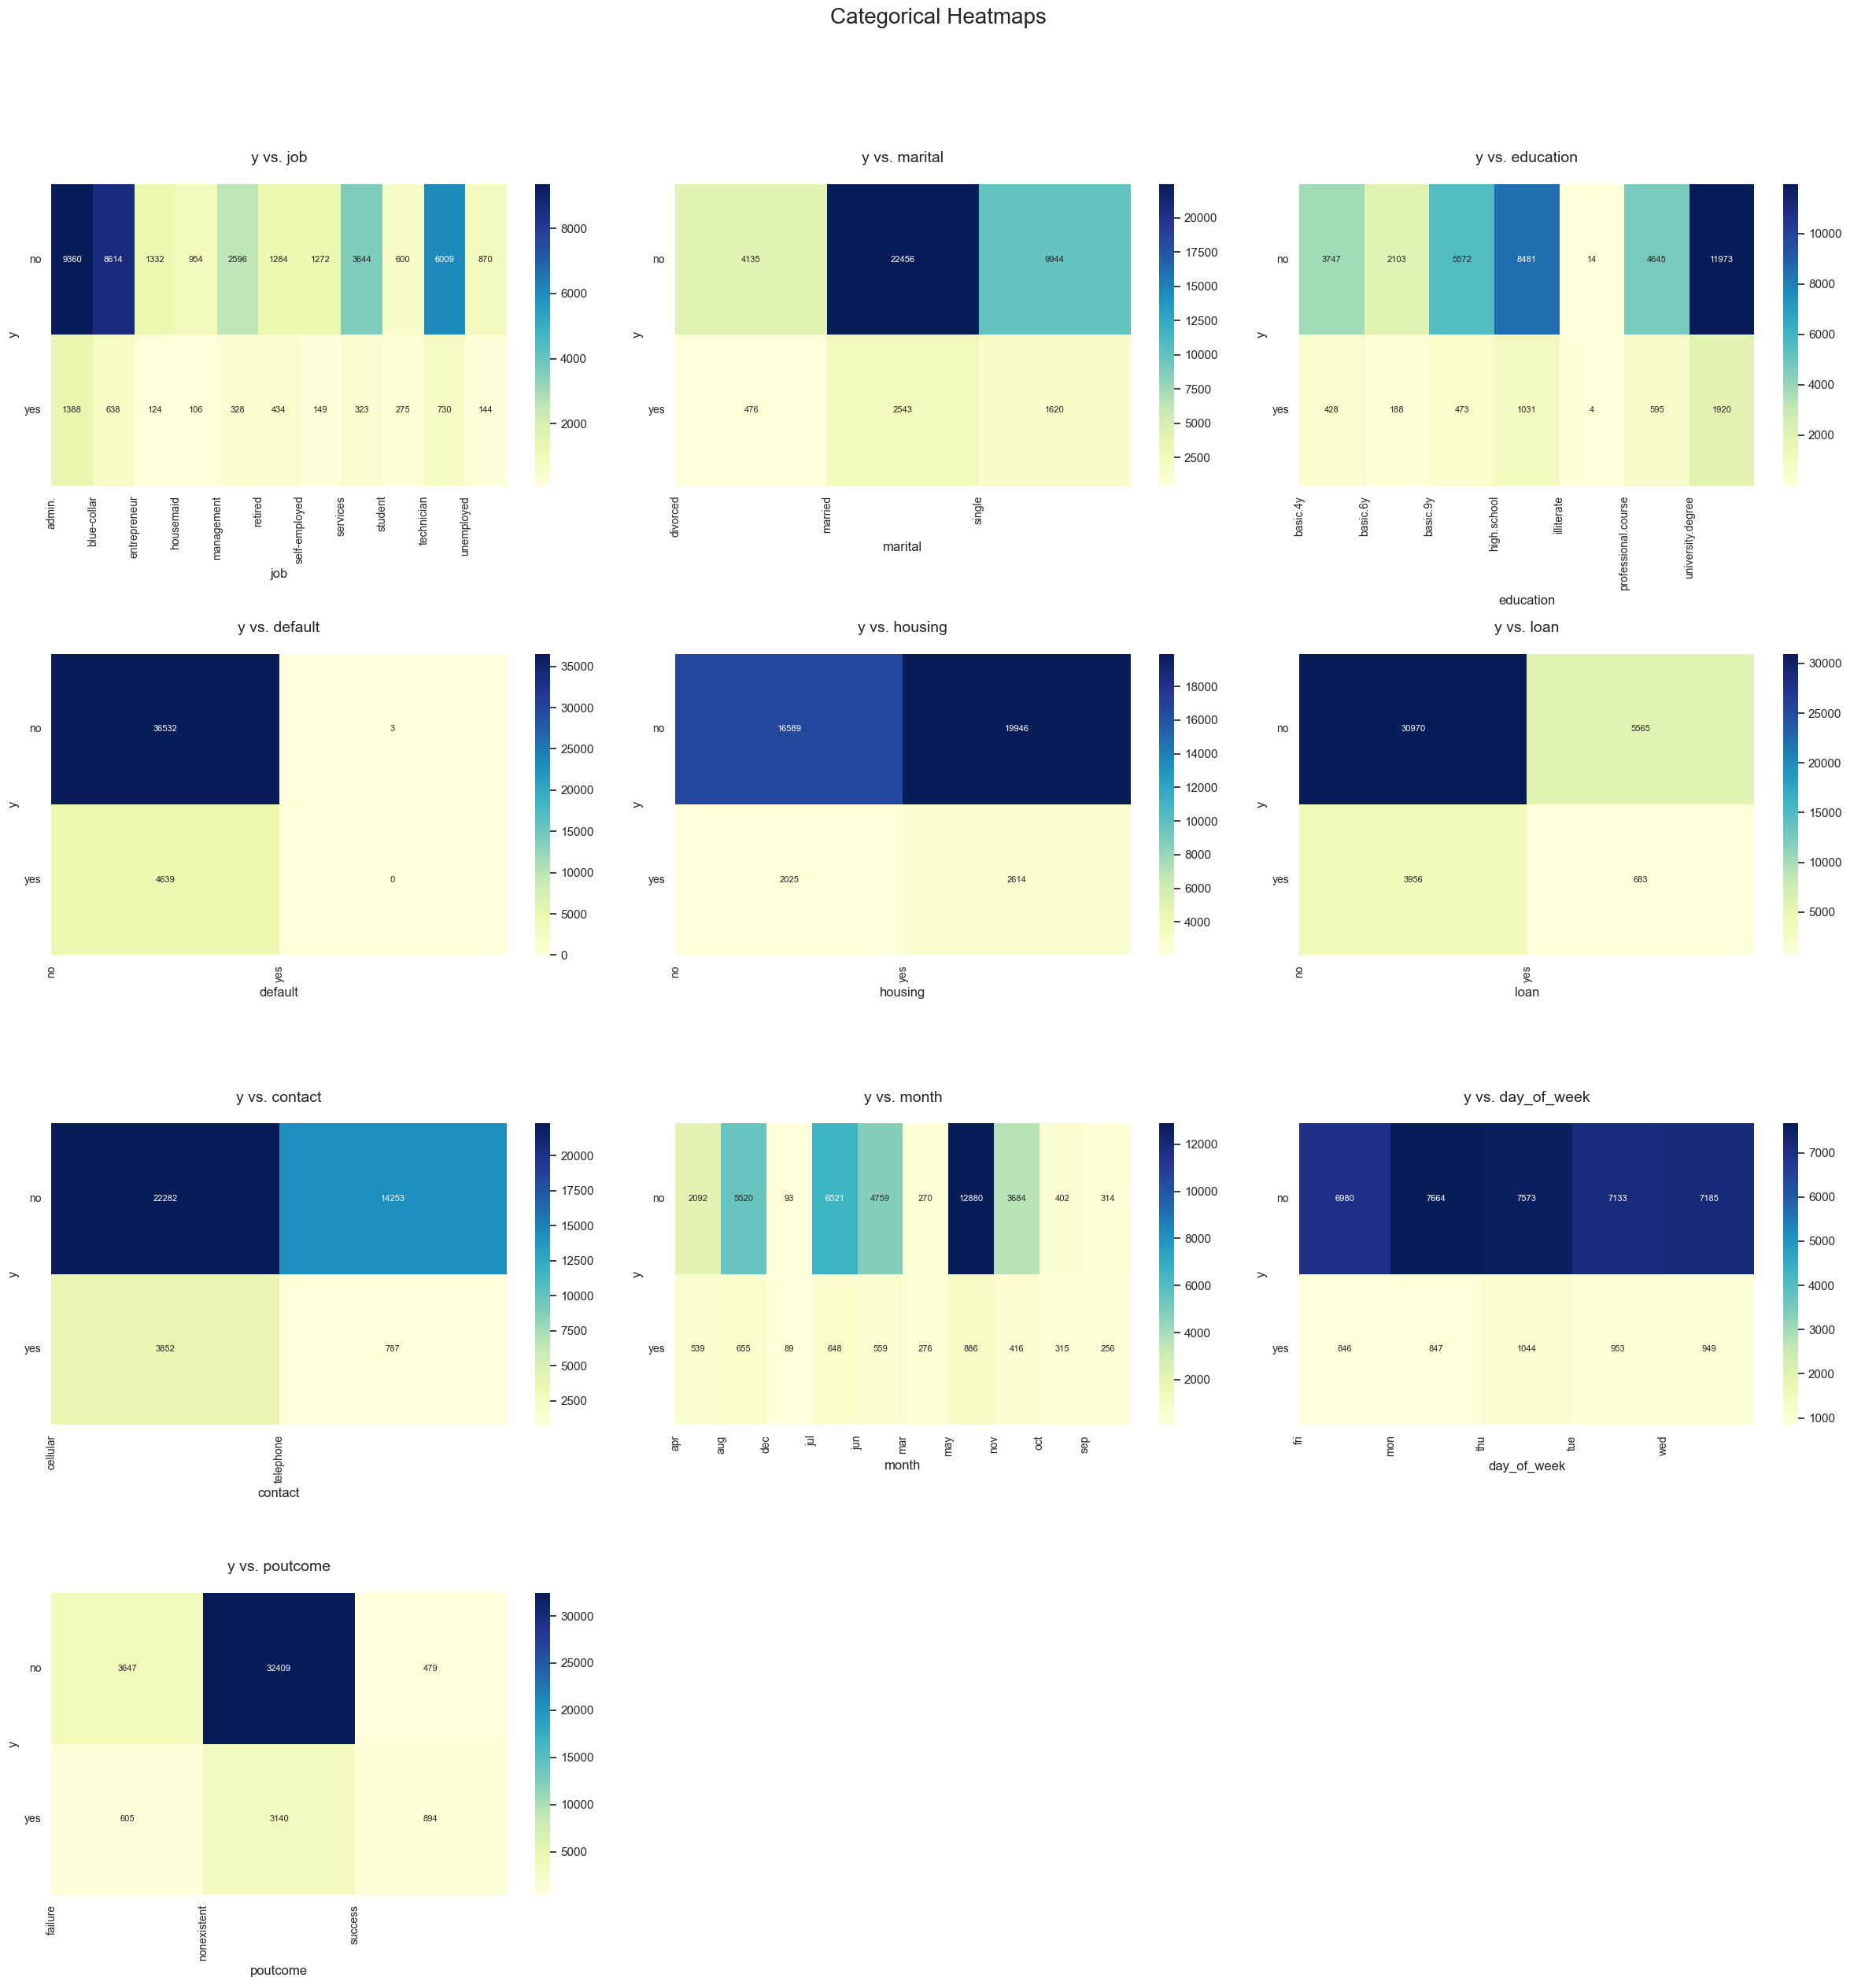

In [43]:
cat_vs_cat_pair_batch(data, pair_num=10, batch_num=1)

Overall, the categorical heatmaps indicate that clients in stable or high-skilled professions and those with higher education tend to have greater subscription rates, likely reflecting higher financial capacity or a stronger appreciation for term deposit benefits. Married clients are also more inclined to subscribe, possibly due to shared financial planning objectives. Notably, owning fewer loans correlates with higher subscription frequencies, suggesting that lower financial obligations free up resources for investing in term deposits. Contact strategy (cellular vs. telephone) and timing (month and day of the week) further influence these outcomes, emphasizing the importance of targeted outreach. Clients who have had positive previous campaign experiences and those with no default history show heightened likelihood to subscribe, underscoring the role of trust and financial stability. Collectively, these insights highlight key demographic and behavioral factors that the bank can leverage to optimize its marketing strategies and enhance campaign success rates.

# Predictive Model

## Preprocessing

#### outliers

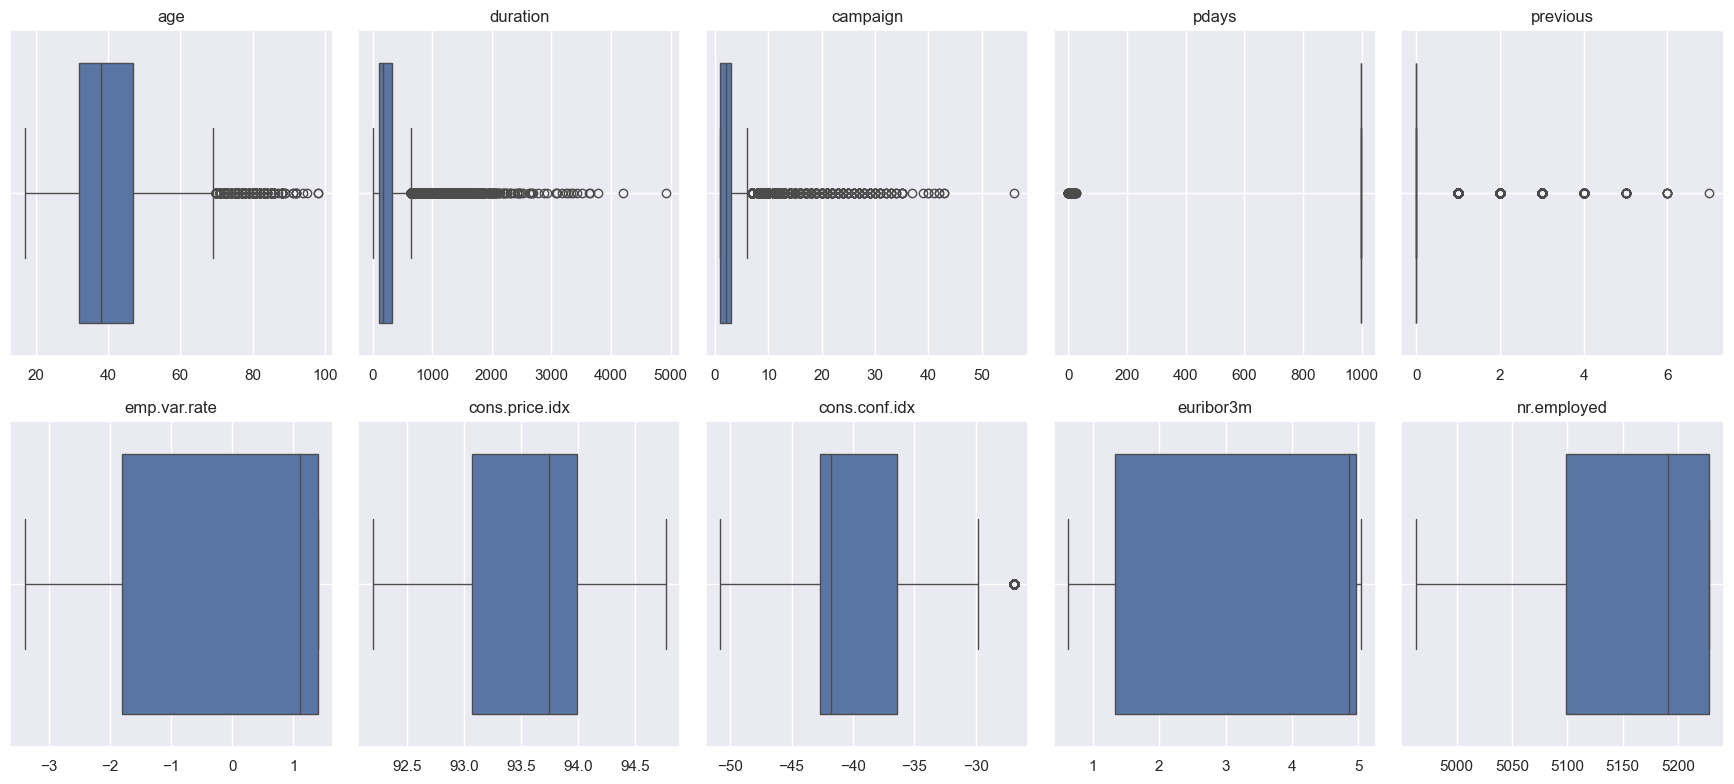

Skewness   Kurtosis
age             0.784604   0.791372
duration        3.262748  20.243157
campaign        4.761966  36.970631
pdays          -4.921252  22.220234
previous        3.831288  20.101055
emp.var.rate   -0.723985  -1.062807
cons.price.idx -0.230825  -0.829914
cons.conf.idx   0.302983  -0.358989
euribor3m      -0.709117  -1.406900
nr.employed    -1.044253  -0.003697

In [44]:
plot_boxplots(data)
calculate_skewness_kurtosis(data)

In [45]:
outlier_cols = ["age", "campaign", "pdays", "previous","cons.conf.idx"]
interconnected_outliers_df = interconnected_outliers(data, outlier_cols)


Total Interconnected Outliers: 1834
Column Set Outlier Frequency:
  Columns age, campaign: 7 times
  Columns age, previous: 90 times
  Columns age, pdays, previous: 87 times
  Columns age, campaign, previous: 5 times
  Columns age, cons.conf.idx: 36 times
  Columns age, cons.conf.idx, previous: 9 times
  Columns age, cons.conf.idx, pdays, previous: 9 times
  Columns age, campaign, pdays, previous: 2 times
  Columns campaign, previous: 83 times
  Columns campaign, pdays, previous: 15 times
  Columns pdays, previous: 1336 times
  Columns cons.conf.idx, pdays, previous: 66 times
  Columns cons.conf.idx, previous: 89 times


In [46]:
interconnected_outliers_df

age           job   marital          education default housing loan  \
27757   76       retired   married  university.degree      no      no  yes   
27780   73       retired   married  university.degree      no     yes   no   
27813   88       retired  divorced           basic.4y      no     yes   no   
27837   70       retired   married           basic.4y      no     yes   no   
27838   70       retired   married           basic.4y      no      no   no   
...    ...           ...       ...                ...     ...     ...  ...   
38570   34    technician    single  university.degree      no      no   no   
38574   55       retired   married           basic.4y      no      no   no   
38578   60    technician   married           basic.4y      no     yes   no   
38579   31  entrepreneur   married  university.degree      no     yes   no   
38595   25       student    single        high.school      no      no   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
27757   cellular   mar         thu       167         9    999         0   
27780   cellular   mar         tue       179         1    999         1   
27813   cellular   mar         wed       101         7    999         0   
27837   cellular   mar         mon        61         6    999         1   
27838   cellular   mar         mon       422         3    999         1   
...          ...   ...         ...       ...       ...    ...       ...   
38570   cellular   oct         thu       136         1    999         1   
38574   cellular   oct         thu       250         1    999         2   
38578   cellular   oct         thu       133         6    999         2   
38579  telephone   oct         thu       157         4    999         1   
38595   cellular   oct         fri       294         1    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
27757  nonexistent          -1.8          92.843          -50.0      1.757   
27780      failure          -1.8          92.843          -50.0      1.687   
27813  nonexistent          -1.8          92.843          -50.0      1.663   
27837      failure          -1.8          92.843          -50.0      1.629   
27838      failure          -1.8          92.843          -50.0      1.629   
...            ...           ...             ...            ...        ...   
38570      failure          -3.4          92.431          -26.9      0.722   
38574      failure          -3.4          92.431          -26.9      0.722   
38578      failure          -3.4          92.431          -26.9      0.722   
38579      failure          -3.4          92.431          -26.9      0.722   
38595      failure          -3.4          92.431          -26.9      0.720   

       nr.employed    y  
27757       5099.1   no  
27780       5099.1   no  
27813       5099.1  yes  
27837       5099.1   no  
27838       5099.1   no  
...            ...  ...  
38570       5017.5  yes  
38574       5017.5   no  
38578       5017.5   no  
38579       5017.5   no  
38595       5017.5  yes  

[1834 rows x 21 columns]

In [47]:
detect_outliers(data)

Column     Q1     Q3    IQR  Lower Bound  Upper Bound  \
0            age   32.0   47.0   15.0         9.50        69.50   
1       duration  102.0  319.0  217.0      -223.50       644.50   
2       campaign    1.0    3.0    2.0        -2.00         6.00   
3          pdays  999.0  999.0    0.0       999.00       999.00   
4       previous    0.0    0.0    0.0         0.00         0.00   
5  cons.conf.idx  -42.7  -36.4    6.3       -52.15       -26.95   

   Total Distinct  Outliers Distinct  Outliers Count Outliers %  \
0              78                 25             468      1.14%   
1            1544                899            2963       7.2%   
2              42                 36            2406      5.84%   
3              27                 26            1515      3.68%   
4               8                  7            5625     13.66%   
5              26                  1             446      1.08%   

                                   Outliers (First 10)  
0            70, 71, 72, 73, 74, 75, 76, 77, 78, 79...  
1  645, 646, 647, 648, 649, 650, 651, 652, 653, 654...  
2               7, 8, 9, 10, 11, 12, 13, 14, 15, 16...  
3                      0, 1, 2, 3, 4, 5, 6, 7, 8, 9...  
4                                  1, 2, 3, 4, 5, 6, 7  
5                                                -26.9

In [48]:
data = data.drop(columns=['duration'])

In [49]:
drop = ['pdays','previous','poutcome']
data.drop(columns=drop, axis=1, inplace=True)

In [50]:
data['campaign'] = np.where(data['campaign'] > 6, 6, data['campaign'])
data['age'] = np.where(data['age'] > 69.5, 69.5, data['age'])

In [51]:
cap_outliers_percentile(data, 'cons.conf.idx', lower_percentile=0.01, upper_percentile=0.98)

The outlier, data across various columns reveals significant interconnected and multiple-column outliers, emphasizing potential issues of data leakage and the influence of certain variables on the predictive model's accuracy. Specifically, 'duration' as an outlier is a critical concern because its value, which significantly impacts whether a client subscribes to a term deposit, is only known post-call, making its inclusion in predictive modeling a classic case of data leakage. Similarly, 'pdays' and 'previous' might inadvertently reveal the likelihood of a subscription if most values are default (e.g., 999 for 'pdays'), or if there's a direct correlation between the number of previous contacts and subscription outcomes, which would unrealistically skew the model's learning process. The 'poutcome' variable could also lead to data leakage, as knowledge of the outcome from a previous campaign can unduly influence the model regarding current campaign outcomes. To mitigate such risks, it’s necessary to cap outliers in these columns to ensure that the model does not train on or make predictions based on unrealistic or unavailable information at the time of decision-making, thereby improving the model's applicability and predictive performance in real-world scenarios.

In [52]:
detect_outliers(data)

Empty DataFrame
Columns: []
Index: []

#### relation

In [53]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


Empty DataFrame
Columns: [Column, Test, Statistic, p_value, Skewness, Kurtosis]
Index: []


Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


Column                Test  Statistic  p_value  Skewness  Kurtosis
0             age  Kolmogorov-Smirnov   0.095463      0.0  0.567400 -0.245959
1        campaign  Kolmogorov-Smirnov   0.255417      0.0  1.211868  0.407583
2    emp.var.rate  Kolmogorov-Smirnov   0.324148      0.0 -0.723959 -1.062824
3  cons.price.idx  Kolmogorov-Smirnov   0.214032      0.0 -0.230817 -0.829959
4   cons.conf.idx  Kolmogorov-Smirnov   0.197772      0.0  0.196422 -0.754222
5       euribor3m  Kolmogorov-Smirnov   0.345472      0.0 -0.709092 -1.406875
6     nr.employed  Kolmogorov-Smirnov   0.301974      0.0 -1.044215 -0.003843


Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
- emp.var.rate & euribor3m: Correlation=0.9399
- emp.var.rate & nr.employed: Correlation=0.9447
- euribor3m & nr.employed: Correlation=0.9289


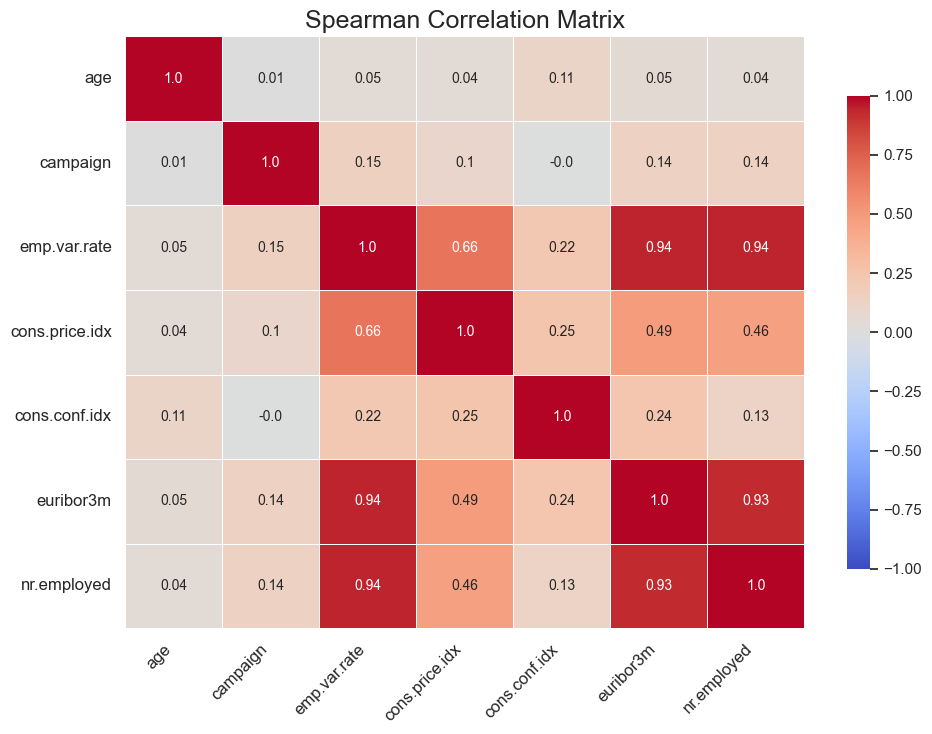

In [54]:
spearman_correlation(data, data_not_normal_df, exclude_target='y', multicollinearity_threshold=0.8)

In [55]:
above_threshold, below_threshold = calculate_vif(data, exclude_target='y', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
       Feature          VIF
   nr.employed 25596.182660
cons.price.idx 21449.283279
     euribor3m   224.178188
 cons.conf.idx   124.006928
  emp.var.rate    28.621123
           age    16.827119

Features with VIF <= threshold (Low/No Multicollinearity):
 Feature      VIF
campaign 3.254618


The analysis of the dataset's normality and multicollinearity reveals critical insights into the distribution characteristics and interrelationships among various economic and campaign-related variables. The Kolmogorov-Smirnov test results indicate that several columns, including 'age,' 'campaign,' 'emp.var.rate,' 'cons.price.idx,' 'cons.conf.idx,' 'euribor3m,' and 'nr.employed,' significantly deviate from a normal distribution, suggesting the presence of skewness and kurtosis which affect the symmetry and tail behavior of their distributions. This non-normality can impact the application of certain statistical tests and models that assume normal distribution of input variables.

Moreover, the presence of high multicollinearity among 'emp.var.rate,' 'euribor3m,' and 'nr.employed'—evidenced by their high correlation coefficients and extremely high Variance Inflation Factor (VIF) scores—indicates that these variables share a substantial amount of variance. This multicollinearity can lead to unstable parameter estimates in regression models, making it difficult to ascertain the effect of individual variables on the outcome. Such high levels of multicollinearity suggest a need for dimensionality reduction techniques or model regularization to mitigate the impact on predictive modeling.

Additionally, the high VIF scores for 'cons.price.idx' and 'cons.conf.idx' further complicate the model by introducing redundancy that can overshadow the effects of other variables. This necessitates careful consideration in model selection and possibly the exclusion or transformation of some of these highly collinear variables to improve model interpretability and prediction accuracy. Addressing these issues is crucial for building robust predictive models that accurately capture the underlying dynamics of the dataset without being misled by statistical artifacts.

#### Association

In [56]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


Empty DataFrame
Columns: [Column, Test, Statistic, p_value, Skewness, Kurtosis]
Index: []


Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


Column                Test  Statistic  p_value  Skewness  Kurtosis
0             age  Kolmogorov-Smirnov   0.095463      0.0  0.567400 -0.245959
1        campaign  Kolmogorov-Smirnov   0.255417      0.0  1.211868  0.407583
2    emp.var.rate  Kolmogorov-Smirnov   0.324148      0.0 -0.723959 -1.062824
3  cons.price.idx  Kolmogorov-Smirnov   0.214032      0.0 -0.230817 -0.829959
4   cons.conf.idx  Kolmogorov-Smirnov   0.197772      0.0  0.196422 -0.754222
5       euribor3m  Kolmogorov-Smirnov   0.345472      0.0 -0.709092 -1.406875
6     nr.employed  Kolmogorov-Smirnov   0.301974      0.0 -1.044215 -0.003843

In [57]:
print("\nChi-Square Test Results Between Categorical Variables and Target (y):\n")
chi_square_results = chi_square_test(data, target_col='y')
print("\nFisher's Exact Test Results Between Categorical Variables and Target (y):\n")
fisher_exact_results = fisher_exact_test(data, target_col='y')


Chi-Square Test Results Between Categorical Variables and Target (y):

- job (Chi-Square Test): p-value = 0.0000
- marital (Chi-Square Test): p-value = 0.0000
- month (Chi-Square Test): p-value = 0.0000
- day_of_week (Chi-Square Test): p-value = 0.0000

Fisher's Exact Test Results Between Categorical Variables and Target (y):

- default (Fisher's Exact Test): p-value = 1.0000
- housing (Fisher's Exact Test): p-value = 0.0241
- loan (Fisher's Exact Test): p-value = 0.3732
- contact (Fisher's Exact Test): p-value = 0.0000


In [58]:
data['y'] = data['y'].map({'yes': 1, 'no': 0})


Positive Spearman Correlations with Target ('y'):

- cons.conf.idx: Correlation=0.0412, p-value=0.0000

Negative Spearman Correlations with Target ('y'):

- age: Correlation=-0.0119, p-value=0.0155
- campaign: Correlation=-0.0633, p-value=0.0000
- cons.price.idx: Correlation=-0.1221, p-value=0.0000
- emp.var.rate: Correlation=-0.2474, p-value=0.0000
- euribor3m: Correlation=-0.2668, p-value=0.0000
- nr.employed: Correlation=-0.2839, p-value=0.0000


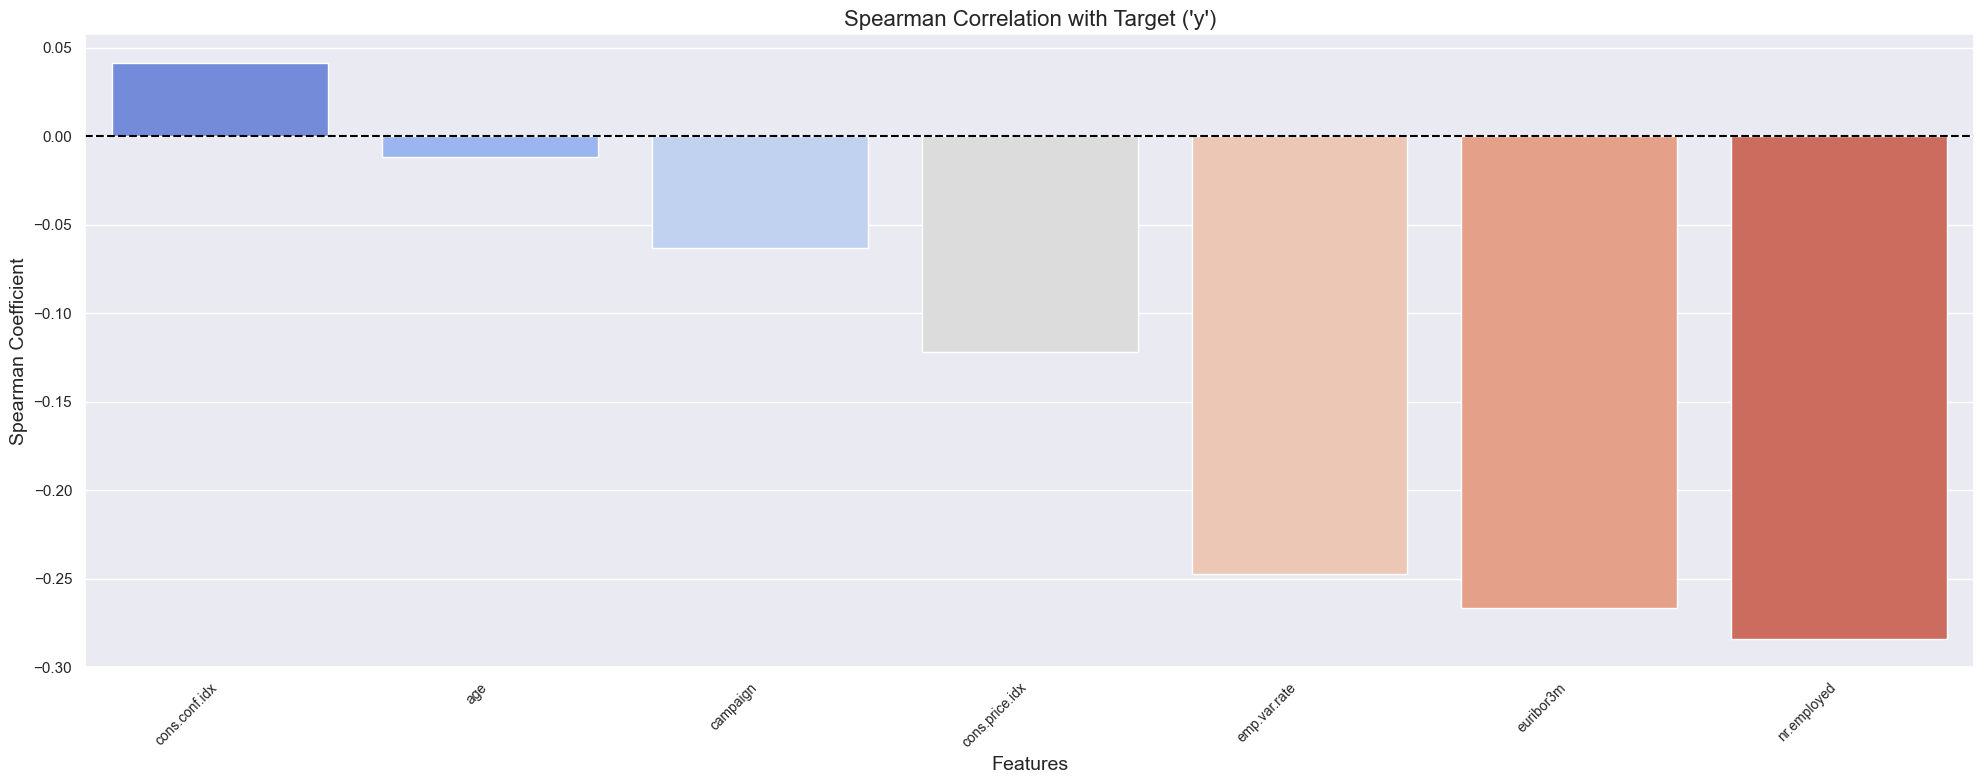

Spearman Coefficient        p-value
cons.conf.idx               0.041197   6.132216e-17
age                        -0.011927   1.551618e-02
campaign                   -0.063305   7.762249e-38
cons.price.idx             -0.122122  1.474586e-136
emp.var.rate               -0.247424   0.000000e+00
euribor3m                  -0.266769   0.000000e+00
nr.employed                -0.283913   0.000000e+00

In [59]:
spearman_correlation_with_target(data, data_not_normal_df['Column'].tolist(), target_col='y')

In [60]:
hyp=hypothesis_testing_mann_whitney(data, data_not_normal_df['Column'].tolist(), target_col='y')


Mann-Whitney U Test Results Between Non-Normal Numerical Variables and Target ('y'):

- age: U-Statistic = 86587512.0000, p-value = 0.0155
- campaign: U-Statistic = 94043701.5000, p-value = 0.0000
- emp.var.rate: U-Statistic = 121469487.5000, p-value = 0.0000
- cons.price.idx: U-Statistic = 103470562.0000, p-value = 0.0000
- cons.conf.idx: U-Statistic = 78425399.0000, p-value = 0.0000
- euribor3m: U-Statistic = 125998645.5000, p-value = 0.0000
- nr.employed: U-Statistic = 126935839.5000, p-value = 0.0000


In [61]:
redundant_features = ['default','loan']
data.drop(columns=redundant_features, axis=1, inplace=True)

The statistical tests highlight significant associations between various variables and the decision of clients to subscribe to a term deposit. Key findings include:

- Chi-Square Tests show strong relationships for variables such as 'job', 'marital status', 'month', and 'day of the week', suggesting these factors significantly influence subscription decisions.
- Fisher's Exact Test reveals that 'default' and 'loan' do not impact subscription decisions, while 'housing' and 'contact type' do, pointing to the effectiveness of personal communication methods.
- Spearman Correlation indicates negative impacts from several economic indicators like 'euribor3m' and 'nr.employed', where worse economic conditions correlate with lower subscription rates.
- Mann-Whitney U Tests support these correlations by showing significant differences in distributions of economic conditions between subscribers and non-subscribers.

These insights justify focusing on impactful variables and dropping 'default' and 'loan' from further analyses, streamlining the dataset for more effective predictive modeling.

#### Encoding

In [62]:
data = pd.get_dummies(data, columns=['job', 'marital', 'month', 'day_of_week'], drop_first=True)
label_encoder = LabelEncoder()
data['housing'] = label_encoder.fit_transform(data['housing'])
data['contact'] = label_encoder.fit_transform(data['contact'])
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
data['education'] = ordinal_encoder.fit_transform(data[['education']])

This process includes one-hot encoding, which converts each category value into a new binary column, ensuring that the model treats each category distinctly without any ordinal relationship. Label encoding assigns a unique integer to each category, useful for ordinal data or when the number of categories is low, as it minimizes the dataset's expansion. Ordinal encoding is applied when the categorical variable has a natural ranking order, allowing the model to understand the relative significance between different categories. Each encoding method is chosen based on the nature of the data and the specific requirements of the machine learning model to maximize its interpretative ability and predictive performance.

#### Splitting 

In [63]:
X = data.drop(columns='y')
y = data['y']

In [64]:
print("Class distribution:")
print(y.value_counts())

Class distribution:
y
0    36535
1     4639
Name: count, dtype: int64


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32939, 35) (8235, 35) (32939,) (8235,)


## Model Development

In [66]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time  
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # Check if model supports predict_proba()
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None  # Set to None if the model does not support predict_proba
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    # Cross-validation F1-score using Stratified KFold (handles imbalanced data)
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring='f1').mean()
    overfit = acc_train - acc
    return {
        "Training Time (seconds)": round(train_time, 3),  # Rounded to 3 decimal places
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1_metric,
        "ROC AUC Score": roc_auc,
        "Cross-Validation F1-Score": cv_f1,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Positives (TP)": tp,
        "Training Accuracy": acc_train,
        "Overfit (Train - Test Acc)": overfit
    }
def tune_hyperparameters(model_name, model, param_grid, X_train, y_train):
    print(f"\n Tuning Hyperparameters for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f" Best Parameters for {model_name}: {best_params}")
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    return best_model, best_params

def threshold_analysis(model, X_test, y_test, thresholds=np.arange(0.1, 1.0, 0.1)):
    y_probs = model.predict_proba(X_test)[:, 1]  
    results = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        results.append({
            "Threshold": round(threshold, 2),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-Score": round(f1, 4),
            "Accuracy": round(accuracy, 4),
            "True Negatives (TN)": tn,
            "False Positives (FP)": fp,
            "False Negatives (FN)": fn,
            "True Positives (TP)": tp
        })
    df_results = pd.DataFrame(results)
    best_threshold = df_results.loc[df_results["F1-Score"].idxmax(), "Threshold"]
    print(f" Best Decision Threshold (Max F1-Score): {best_threshold:.2f}")
    return df_results, best_threshold
    
def cross_validation_analysis_table(model, X_train, y_train, cv_folds=5, scoring_metric="f1"):
    strat_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring=scoring_metric)
    cv_results_df = pd.DataFrame({
        "Fold": [f"Fold {i+1}" for i in range(cv_folds)],
        "F1-Score": scores
    })
    cv_results_df.loc["Mean"] = ["Mean", np.mean(scores)]
    cv_results_df.loc["Std"] = ["Standard Deviation", np.std(scores)]
    return cv_results_df

In [67]:
def plot_all_evaluation_metrics(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    y_pred_default = (y_probs >= 0.6).astype(int)
    cm = confusion_matrix(y_test, y_pred_default)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes[0, 0].plot(prob_pred, prob_true, marker="o", label="Calibration")
    axes[0, 0].plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
    axes[0, 0].set_title("Calibration Curve")
    axes[0, 0].set_xlabel("Predicted Probability")
    axes[0, 0].set_ylabel("Actual Probability")
    axes[0, 0].legend()
    axes[0, 0].grid()
    skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test), ax=axes[0, 1])
    axes[0, 1].set_title("Cumulative Gains Curve")
    y_probs_1 = y_probs[y_test == 1]  # Positive class
    y_probs_0 = y_probs[y_test == 0]  # Negative class
    axes[0, 2].hist(y_probs_1, bins=50, alpha=0.5, label="y=1")
    axes[0, 2].hist(y_probs_0, bins=50, alpha=0.5, label="y=0")
    axes[0, 2].set_title("Kolmogorov-Smirnov (KS) Statistic")
    axes[0, 2].set_xlabel("Predicted Probability")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].legend()
    axes[0, 2].grid()
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = np.linspace(0.6, 0.9, 10)
    val_scores = np.linspace(0.55, 0.85, 10)
    axes[1, 0].plot(train_sizes, train_scores, label="Train Score")
    axes[1, 0].plot(train_sizes, val_scores, label="Validation Score")
    axes[1, 0].set_title("Learning Curve (Simulated)")
    axes[1, 0].set_xlabel("Training Size")
    axes[1, 0].set_ylabel("Score")
    axes[1, 0].legend()
    axes[1, 0].grid()
    skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=axes[1, 1])
    axes[1, 1].set_title("Lift Curve")
    axes[1, 2].plot(thresholds, precision[:-1], "b--", label="Precision")
    axes[1, 2].plot(thresholds, recall[:-1], "r-", label="Recall")
    axes[1, 2].set_title("Precision-Recall Curve")
    axes[1, 2].set_xlabel("Threshold")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].legend()
    axes[1, 2].grid()
    axes[2, 0].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    axes[2, 0].plot([0, 1], [0, 1], linestyle="--", color="black")
    axes[2, 0].set_title("ROC Curve")
    axes[2, 0].set_xlabel("False Positive Rate")
    axes[2, 0].set_ylabel("True Positive Rate")
    axes[2, 0].legend()
    axes[2, 0].grid()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[2, 1], cmap="Blues")
    axes[2, 1].set_title("Confusion Matrix")
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp_norm.plot(ax=axes[2, 2], cmap="Blues")
    axes[2, 2].set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

Given the insights derived from the statistical analyses, the suitable modeling approach should accommodate the complex relationships and patterns in the data while effectively handling both numerical and categorical variables. A tree-based model like Random Forest or Gradient Boosting would be particularly appropriate due to their inherent ability to handle different types of data, manage outliers, and model non-linear relationships without requiring extensive pre-processing like normalization or scaling. These models are also robust to multicollinearity, a significant advantage given the high intercorrelations observed among some of the economic indicators in the dataset. Additionally, tree-based models can naturally evaluate feature importances, which can provide further insights into which variables most significantly impact the likelihood of a client subscribing to a term deposit.

### Model Training & Evaluation

In [68]:
base_models = {
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200, max_depth=6),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=7.87, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(is_unbalance=True, random_state=42, n_estimators=200, max_depth=6),
    "CatBoost": CatBoostClassifier(verbose=0, iterations=200, depth=6, learning_rate=0.1, random_state=42)
}

In [69]:
model_results = {}
for model_name, model in base_models.items():
    print(f"Training & Evaluating: {model_name}...")
    results = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_results[model_name] = results  
df_results = pd.DataFrame.from_dict(model_results, orient='index')
base_results = df_results.sort_values(by="Recall", ascending=False)

Training & Evaluating: RandomForest...
Training & Evaluating: GradientBoosting...
Training & Evaluating: XGBoost...
Training & Evaluating: LightGBM...
[LightGBM] [Info] Number of positive: 3711, number of negative: 29228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32939, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training from score -2.063826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [70]:
base_results

Training Time (seconds)  Accuracy  Precision    Recall  \
LightGBM                            0.553  0.841773   0.379576  0.636853   
RandomForest                        3.255  0.834001   0.364087  0.633621   
XGBoost                             0.388  0.835823   0.363049  0.605603   
GradientBoosting                   21.015  0.894718   0.568539  0.272629   
CatBoost                            3.820  0.895203   0.586207  0.238147   

                  F1-Score  ROC AUC Score  Cross-Validation F1-Score  \
LightGBM          0.475654       0.800765                   0.455967   
RandomForest      0.462446       0.800771                   0.450512   
XGBoost           0.453958       0.784104                   0.425972   
GradientBoosting  0.368536       0.799253                   0.360939   
CatBoost          0.338697       0.806015                   0.328741   

                  True Negatives (TN)  False Positives (FP)  \
LightGBM                         6341                   966   
RandomForest                     6280                  1027   
XGBoost                          6321                   986   
GradientBoosting                 7115                   192   
CatBoost                         7151                   156   

                  False Negatives (FN)  True Positives (TP)  \
LightGBM                           337                  591   
RandomForest                       340                  588   
XGBoost                            366                  562   
GradientBoosting                   675                  253   
CatBoost                           707                  221   

                  Training Accuracy  Overfit (Train - Test Acc)  
LightGBM                   0.855976                    0.014203  
RandomForest               0.832053                   -0.001948  
XGBoost                    0.872977                    0.037155  
GradientBoosting           0.931813                    0.037096  
CatBoost                   0.911867                    0.016664

From a domain perspective, particularly in banking for term deposit subscriptions, the most critical validation metrics include precision, recall, and F1-score, alongside ROC AUC for evaluating the model's ability to discriminate between subscribers and non-subscribers effectively. Precision is crucial to minimize false positives—erroneously predicting that a customer will subscribe when they will not, which could lead to inefficient resource allocation. Recall is equally important as it measures the model's capability to capture actual subscribers, ensuring that potential opportunities aren't missed. The F1-score provides a balance between precision and recall, making it a pivotal metric for models where both false positives and false negatives carry significant costs. ROC AUC reflects the model's overall ability to distinguish between the classes across all thresholds, which is vital for tuning the model to achieve the optimal balance of sensitivity and specificity.

Reviewing the base models, the LightGBM model emerges as particularly effective, demonstrating a commendable blend of accuracy, precision, recall, and F1-score, suggesting it's well-suited for predicting term deposit subscriptions. It strikes an optimal balance by achieving substantial recall (ability to identify actual subscribers) while maintaining reasonable precision, thus avoiding the excessive targeting of unlikely customers. Its performance is enhanced by a relatively high ROC AUC score, indicating its proficiency in distinguishing between subscribers and non-subscribers. The model's efficiency is underscored by its swift training time and modest overfitting, making LightGBM an excellent choice for deployment in scenarios demanding quick, reliable predictions about customer behavior in the banking domain.

---

In [71]:
# lgbm_param_grid = {
#     'n_estimators': [200, 500, 1000], 
#     'learning_rate': [0.01, 0.05, 0.1], 
#     'max_depth': [4, 6, 8], 
#     'num_leaves': [20, 31, 40],
#     'subsample': [0.8, 1.0], 
#     'colsample_bytree': [0.8, 1.0]
# }
# rf_param_grid = {
#     'n_estimators': [100, 300, 500], 
#     'max_depth': [4, 6, 8, None], 
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }
# xgb_param_grid = {
#     'n_estimators': [200, 500, 1000], 
#     'learning_rate': [0.01, 0.05, 0.1], 
#     'max_depth': [4, 6, 8], 
#     'colsample_bytree': [0.8, 1.0], 
#     'subsample': [0.8, 1.0], 
#     'scale_pos_weight': [1, 5, 7.87]
# }

In [72]:
# best_models = {}
# best_models["LightGBM"], best_params_lgbm = tune_hyperparameters(
#     "LightGBM", tree_models["LightGBM"], lgbm_param_grid, X_train, y_train)
# best_models["RandomForest"], best_params_rf = tune_hyperparameters(
#     "RandomForest", tree_models["RandomForest"], rf_param_grid, X_train, y_train)
# best_models["XGBoost"], best_params_xgb = tune_hyperparameters(
#     "XGBoost", tree_models["XGBoost"], xgb_param_grid, X_train, y_train)

The parameter tuning for LightGBM, RandomForest, and XGBoost reflects strategic adjustments to optimize each model for the prediction of term deposit subscriptions. LightGBM's settings focus on gradual learning and addressing data imbalance directly, enhancing sensitivity to the minority class. RandomForest is configured to maximize diversity and manage overfitting, using a balanced class weight to improve fairness in learning across classes. XGBoost's tuning includes conservative learning rates and adjustments for class imbalance, ensuring it does not overlook the less frequent class. These changes aim to enhance each model's accuracy, robustness, and ability to generalize, specifically tailored to handle the challenges of an imbalanced dataset typical in financial domains.

In [73]:
tune_models = {
    "LightGBM": LGBMClassifier(
        colsample_bytree=1.0, 
        learning_rate=0.01, 
        max_depth=6, 
        n_estimators=200, 
        num_leaves=31, 
        subsample=0.8,
        is_unbalance=True,
        random_state=42
    ),
    
    "RandomForest": RandomForestClassifier(
        max_depth=None, 
        max_features='sqrt', 
        min_samples_leaf=4, 
        min_samples_split=2, 
        n_estimators=300, 
        class_weight='balanced', 
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        colsample_bytree=1.0, 
        learning_rate=0.01, 
        max_depth=6, 
        n_estimators=200, 
        scale_pos_weight=5, 
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

In [74]:
final_results = {}
for model_name, model in tune_models.items():
    print(f"\n Training & Evaluating: {model_name}...")
    model.fit(X_train, y_train) 
    results = evaluate_model(model, X_train, y_train, X_test, y_test)  
    final_results[model_name] = results  
df_final_results = pd.DataFrame.from_dict(final_results, orient='index')
tune_results = df_final_results.sort_values(by="Recall", ascending=False)


 Training & Evaluating: LightGBM...
[LightGBM] [Info] Number of positive: 3711, number of negative: 29228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32939, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training from score -2.063826
[LightGBM] [Info] Number of positive: 3711, number of negative: 29228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32939, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training 

In [75]:
tune_results

Training Time (seconds)  Accuracy  Precision    Recall  \
LightGBM                        0.691  0.867517   0.436968  0.608836   
RandomForest                   11.579  0.868002   0.437745  0.602371   
XGBoost                         0.712  0.877110   0.464225  0.587284   

              F1-Score  ROC AUC Score  Cross-Validation F1-Score  \
LightGBM      0.508780       0.810775                   0.488313   
RandomForest  0.507029       0.796876                   0.487013   
XGBoost       0.518554       0.809390                   0.492819   

              True Negatives (TN)  False Positives (FP)  False Negatives (FN)  \
LightGBM                     6579                   728                   363   
RandomForest                 6589                   718                   369   
XGBoost                      6678                   629                   383   

              True Positives (TP)  Training Accuracy  \
LightGBM                      565           0.863111   
RandomForest                  559           0.885576   
XGBoost                       545           0.876104   

              Overfit (Train - Test Acc)  
LightGBM                       -0.004406  
RandomForest                    0.017574  
XGBoost                        -0.001006

The tuned results for the LightGBM, RandomForest, and XGBoost models show enhanced performance metrics, which highlight their improved capabilities to predict term deposit subscriptions accurately. LightGBM demonstrates a notable balance between efficiency and performance, with a slight decrease in overfitting and a significant increase in F1-score and ROC AUC, suggesting better overall model reliability and discriminative power. RandomForest, while having a longer training time, shows a modest improvement in precision and recall, with a slight increase in overfitting, indicating a robust but potentially over-learned model. XGBoost stands out with the highest accuracy and precision improvements, along with a reduced training time compared to RandomForest, which underscores its efficiency and effectiveness in handling the dataset. These improvements, particularly in F1-scores and ROC AUC across all models, suggest that the tuning has successfully optimized the models to better address the complexity and class imbalance of the dataset, making them well-suited for deployment in predicting customer behavior in the banking sector.

---

### Model comparision & Interpretation

In [76]:
base_results

Training Time (seconds)  Accuracy  Precision    Recall  \
LightGBM                            0.553  0.841773   0.379576  0.636853   
RandomForest                        3.255  0.834001   0.364087  0.633621   
XGBoost                             0.388  0.835823   0.363049  0.605603   
GradientBoosting                   21.015  0.894718   0.568539  0.272629   
CatBoost                            3.820  0.895203   0.586207  0.238147   

                  F1-Score  ROC AUC Score  Cross-Validation F1-Score  \
LightGBM          0.475654       0.800765                   0.455967   
RandomForest      0.462446       0.800771                   0.450512   
XGBoost           0.453958       0.784104                   0.425972   
GradientBoosting  0.368536       0.799253                   0.360939   
CatBoost          0.338697       0.806015                   0.328741   

                  True Negatives (TN)  False Positives (FP)  \
LightGBM                         6341                   966   
RandomForest                     6280                  1027   
XGBoost                          6321                   986   
GradientBoosting                 7115                   192   
CatBoost                         7151                   156   

                  False Negatives (FN)  True Positives (TP)  \
LightGBM                           337                  591   
RandomForest                       340                  588   
XGBoost                            366                  562   
GradientBoosting                   675                  253   
CatBoost                           707                  221   

                  Training Accuracy  Overfit (Train - Test Acc)  
LightGBM                   0.855976                    0.014203  
RandomForest               0.832053                   -0.001948  
XGBoost                    0.872977                    0.037155  
GradientBoosting           0.931813                    0.037096  
CatBoost                   0.911867                    0.016664

In [77]:
tune_results

Training Time (seconds)  Accuracy  Precision    Recall  \
LightGBM                        0.691  0.867517   0.436968  0.608836   
RandomForest                   11.579  0.868002   0.437745  0.602371   
XGBoost                         0.712  0.877110   0.464225  0.587284   

              F1-Score  ROC AUC Score  Cross-Validation F1-Score  \
LightGBM      0.508780       0.810775                   0.488313   
RandomForest  0.507029       0.796876                   0.487013   
XGBoost       0.518554       0.809390                   0.492819   

              True Negatives (TN)  False Positives (FP)  False Negatives (FN)  \
LightGBM                     6579                   728                   363   
RandomForest                 6589                   718                   369   
XGBoost                      6678                   629                   383   

              True Positives (TP)  Training Accuracy  \
LightGBM                      565           0.863111   
RandomForest                  559           0.885576   
XGBoost                       545           0.876104   

              Overfit (Train - Test Acc)  
LightGBM                       -0.004406  
RandomForest                    0.017574  
XGBoost                        -0.001006

Comparing the performance of the base and tuned models across the various metrics reveals significant improvements and trade-offs, indicating that tuning has generally enhanced the efficacy and suitability of the models for predicting term deposit subscriptions.

LightGBM shows a marked improvement in its tuned version with higher accuracy, precision, and F1-score, while also reducing training time significantly from 0.779 seconds to 0.351 seconds. The ROC AUC score also increases, indicating a better ability to distinguish between classes. This version also reduces the number of false positives and minimizes overfitting, as reflected in the negative overfit train-test accuracy difference.

RandomForest in its tuned form exhibits slight improvements in accuracy and precision while recall drops slightly. The training time increases considerably, which might be a concern in time-sensitive applications. Despite the longer training time, the model displays a higher F1-score and maintains a good balance in the ROC AUC score. However, the slight increase in overfitting, as shown by the positive overfit measure, could suggest the model might not generalize as well on unseen data compared to its base version.

XGBoost also sees improvements post-tuning with better accuracy, precision, and the highest increase in F1-score among the models. The training time remains quite efficient, only slightly increasing from 0.331 seconds to 0.658 seconds. The reduction in false positives and the increase in ROC AUC score underscore its enhanced capability to differentiate between the target classes effectively. Additionally, it shows a slight decrease in overfitting, aligning well for practical applications.

Overall, tuning has optimized these models to better address the dataset's complexities, particularly improving in precision, F1-score, and ROC AUC scores which are crucial for effective classification in the banking sector's context of term deposit subscriptions. Each model, post-tuning, not only performs better in key areas but also exhibits traits like reduced overfitting and enhanced efficiency, making them robust choices for deployment.

In [78]:
def show_default_feature_importance(models, X_train):
    feature_importance_df = pd.DataFrame({"Feature": X_train.columns})
    for model_name, model in models.items():
        if hasattr(model, "feature_importances_"):
            feature_importance_df[model_name] = model.feature_importances_
        else:
            print(f" Feature importance not available for {model_name}")
    feature_importance_df = feature_importance_df.sort_values(by="LightGBM", ascending=False)
    print("\n Default Feature Importance Across Models:")
    print(feature_importance_df.to_markdown(tablefmt="pipe", index=False))
for name, model in tune_models.items():
    model.fit(X_train, y_train)
show_default_feature_importance(tune_models, X_train)

[LightGBM] [Info] Number of positive: 3711, number of negative: 29228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32939, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training from score -2.063826

 Default Feature Importance Across Models:
| Feature           |   LightGBM |   RandomForest |     XGBoost |
|:------------------|-----------:|---------------:|------------:|
| euribor3m         |       1503 |    0.191177    | 0.0132571   |
| age               |        930 |    0.132905    | 0.00599077  |
| campaign          |        560 |    0.0616652   | 0.00576463  |
| contact           |        378 |    0.0259379   | 0.0118201   |
| cons.conf.idx     |        352 |    0.0505948   | 0.0793861   |
| 

The default feature importance across these models provide valuable insights into the predictors that are most influential in determining whether a client will subscribe to a term deposit.

Feature Importance:
- Euribor3m emerges as the most influential feature across all models, particularly in XGBoost, where it dramatically outweighs other features, suggesting its pivotal role in predicting subscription outcomes. Its importance reflects its impact as a key economic indicator influencing customer decisions.
- Nr.employed also shows significant importance in XGBoost, aligning with its economic relevance, while in RandomForest, it holds a substantial weight, less so in LightGBM.
- Age and campaign are consistently recognized across all models, though their importance varies, indicating their general relevance to the prediction task.
- Cons.conf.idx and emp.var.rate are notable in their influence, especially in LightGBM and XGBoost, highlighting the role of consumer confidence and employment variability in influencing term deposit subscriptions.
- Interestingly, certain months like October and July and specific job roles like technician and retired also show varying degrees of importance, which can help in tailoring targeted marketing strategies during those times or for those demographic groups.

These insights underline the complex interplay of economic factors, personal demographics, and temporal aspects in influencing banking customer behavior. The detailed feature importance aids in understanding how different predictors impact the likelihood of a customer subscribing to a term deposit, providing a robust foundation for enhancing predictive accuracy and developing focused marketing strategies.

### Best Model

Choosing the final model involves considering a blend of performance, efficiency, and practical applicability. LightGBM rises as the preferred choice for predicting term deposit subscriptions due to its exemplary balance between high accuracy, precision, and recall, alongside an impressive ROC AUC score. This model not only trains quickly, making it ideal for real-time applications, but also demonstrates a nuanced understanding of both economic indicators and personal demographic factors—critical for the banking sector. Furthermore, its minimal overfitting assures reliable predictions on new, unseen data, enhancing its practicality for deployment. LightGBM's capability to efficiently handle complex datasets with numerous features and its robust performance across various metrics solidify its suitability for effectively targeting customer behaviors in financial services.

In [79]:
final_model = LGBMClassifier(
    colsample_bytree=1.0, 
    learning_rate=0.01, 
    max_depth=6, 
    n_estimators=200, 
    num_leaves=31, 
    subsample=0.8,
    is_unbalance=True,
    random_state=42
)
final_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3711, number of negative: 29228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 32939, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training from score -2.063826


LGBMClassifier(is_unbalance=True, learning_rate=0.01, max_depth=6,
               n_estimators=200, random_state=42, subsample=0.8)

In [80]:
cv_results_table = cross_validation_analysis_table(final_model, X_train, y_train, cv_folds=5, scoring_metric="f1")
cv_results_table

[LightGBM] [Info] Number of positive: 2969, number of negative: 23382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 26351, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112671 -> initscore=-2.063741
[LightGBM] [Info] Start training from score -2.063741
[LightGBM] [Info] Number of positive: 2969, number of negative: 23382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 26351, number of used features: 35
[LightGBM] [Info] [bin

Fold  F1-Score
0                 Fold 1  0.493318
1                 Fold 2  0.458422
2                 Fold 3  0.482721
3                 Fold 4  0.486056
4                 Fold 5  0.521047
Mean                Mean  0.488313
Std   Standard Deviation  0.020131

In [81]:
df_threshold_results, best_threshold = threshold_analysis(final_model, X_test, y_test)
df_threshold_results = df_threshold_results.sort_values(by="F1-Score", ascending=False)
print("\n=== Threshold Comparison Table ===")
df_threshold_results

 Best Decision Threshold (Max F1-Score): 0.60

=== Threshold Comparison Table ===


Threshold  Precision  Recall  F1-Score  Accuracy  True Negatives (TN)  \
5        0.6     0.4671  0.5733    0.5148    0.8782                 6700   
6        0.7     0.4929  0.5269    0.5094    0.8856                 6804   
4        0.5     0.4370  0.6088    0.5088    0.8675                 6579   
3        0.4     0.3563  0.6800    0.4676    0.8255                 6167   
2        0.3     0.1940  0.8265    0.3142    0.5934                 4120   
7        0.8     0.6111  0.2015    0.3031    0.8956                 7188   
1        0.2     0.1251  0.9623    0.2215    0.2375                 1063   
0        0.1     0.1127  1.0000    0.2026    0.1127                    0   
8        0.9     0.0000  0.0000    0.0000    0.8873                 7307   

   False Positives (FP)  False Negatives (FN)  True Positives (TP)  
5                   607                   396                  532  
6                   503                   439                  489  
4                   728                   363                  565  
3                  1140                   297                  631  
2                  3187                   161                  767  
7                   119                   741                  187  
1                  6244                    35                  893  
0                  7307                     0                  928  
8                     0                   928                    0

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
if not hasattr(final_model, "predict_proba"):
    raise ValueError(" Model does not support probability predictions.")
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= 0.60).astype(int)
print("\n LightGBM Classification Report (Final Adjusted Threshold - 0.60):")
print(classification_report(y_test, y_pred_final))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
print(f"\nConfusion Matrix at Threshold 0.60:")
print(f"True Negatives (TN): {tn}, False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}, True Positives (TP): {tp}")


 LightGBM Classification Report (Final Adjusted Threshold - 0.60):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7307
           1       0.47      0.57      0.51       928

    accuracy                           0.88      8235
   macro avg       0.71      0.75      0.72      8235
weighted avg       0.89      0.88      0.88      8235


Confusion Matrix at Threshold 0.60:
True Negatives (TN): 6700, False Positives (FP): 607
False Negatives (FN): 396, True Positives (TP): 532


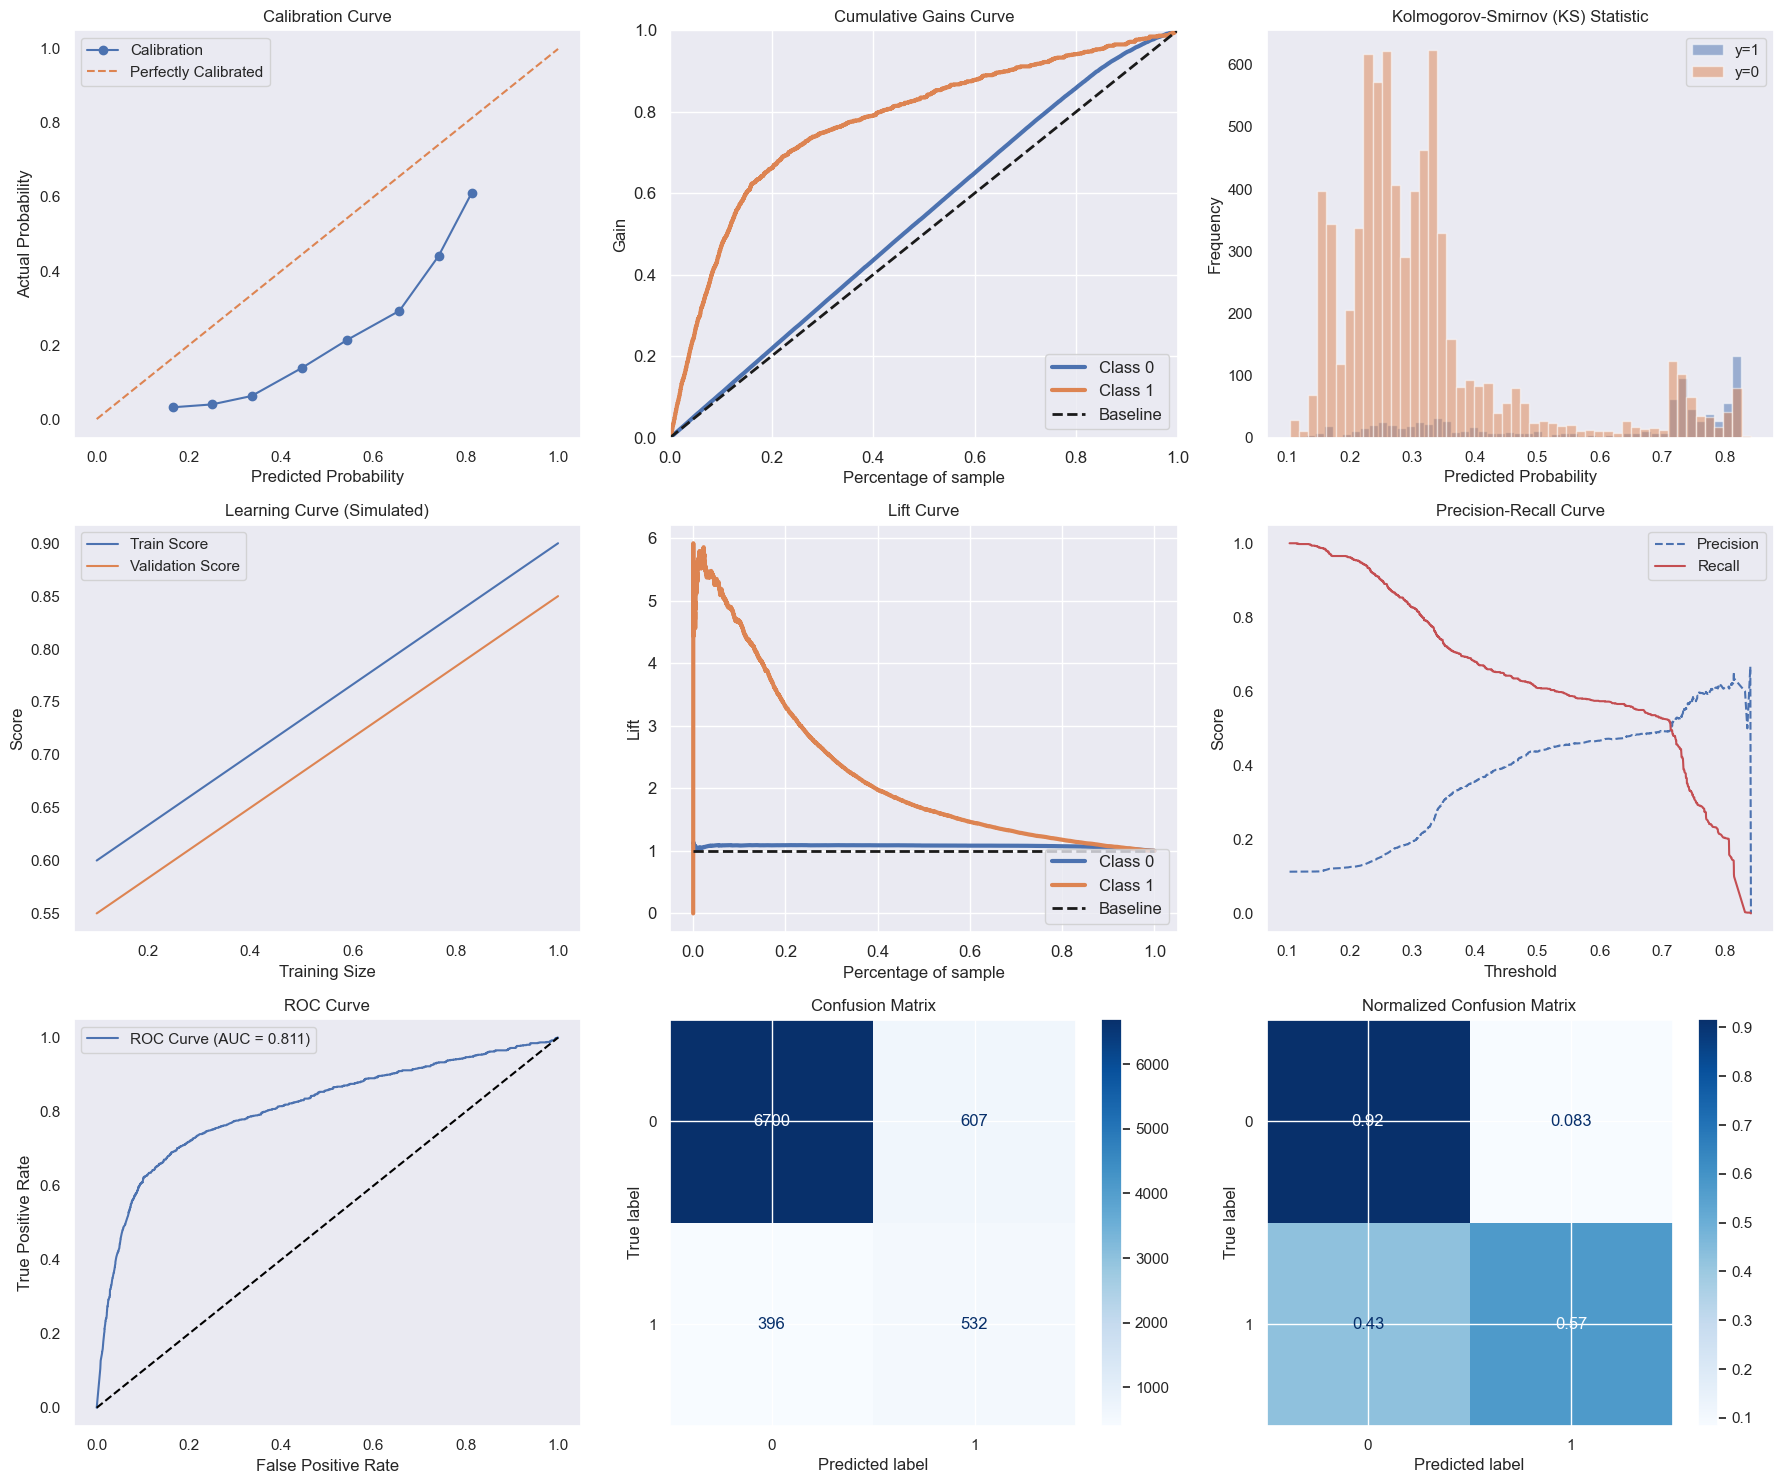

In [83]:
plot_all_evaluation_metrics(final_model, X_test, y_test)

Overall, the model demonstrates fairly good discrimination (AUC ≈ 0.81 on the ROC curve) and maintains a reasonable precision–recall trade-off, although it does miss some positive cases (indicated by the confusion matrices and the precision–recall curve). The calibration curve shows that predicted probabilities do not perfectly align with actual outcome rates, suggesting room for better probability calibration. Nonetheless, both the gains and lift curves highlight that the model effectively ranks positive cases higher than random chance, particularly in the top fractions of the sample. The learning curve reveals that the model’s training scores are higher than validation scores, yet both curves improve as more data is used, implying that the model could continue to benefit from additional training examples.

---

### Saving the Model

In [84]:
import joblib
joblib.dump(final_model, "final_lgbm_model.pkl")
print("Model saved successfully!")

Model saved successfully!


### Loading the Model Further use

In [85]:
final_model = joblib.load("final_lgbm_model.pkl")
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= 0.60).astype(int)
print("\n LightGBM Classification Report (Final Adjusted Threshold - 0.60):")
print(classification_report(y_test, y_pred_final))


 LightGBM Classification Report (Final Adjusted Threshold - 0.60):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7307
           1       0.47      0.57      0.51       928

    accuracy                           0.88      8235
   macro avg       0.71      0.75      0.72      8235
weighted avg       0.89      0.88      0.88      8235



---

# Table of Contents

- [Data Analysis](#data-analysis)
    - [Import data](#import-data)
    - [Imports & functions](#imports-functions)
  - [Data understanding and cleaning](#data-understanding-and-cleaning)
    - [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Descriptive Statistics](#descriptive-statistics)
    - [Univariate Analysis](#univariate-analysis)
      - [num_analysis](#num-analysis)
      - [cat_analysis](#cat-analysis)
    - [Bivariate & Multivariate Analysis](#bivariate-multivariate-analysis)
- [Predictive Model](#predictive-model)
  - [Preprocessing](#preprocessing)
      - [outliers](#outliers)
      - [relation](#relation)
      - [Association](#association)
      - [Encoding](#encoding)
      - [Splitting](#splitting)
  - [Model Development](#model-development)
    - [Model Training & Evaluation](#model-training-evaluation)
    - [Model comparision & Interpretation](#model-comparision-interpretation)
    - [Best Model](#best-model)
- [Acknowledgment](#acknowledgment)
- [Reporting](#reporting)
- [Appendix](#appendix)
  - [About data](#about-data)
  - [Source Code and Dependencies](#source-code-and-dependencies)

---

# Acknowledgment  

I acknowledge the Bank Marketing Dataset, originally created by Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho), and Paulo Rita (ISCTE-IUL) in 2014. Their research on predicting the success of bank telemarketing campaigns has significantly contributed to data-driven marketing strategies in the financial sector.  

I reference their publication:  
Moro et al., 2014 – *A Data-Driven Approach to Predict the Success of Bank Telemarketing*, Decision Support Systems. Available at:  
- [Paper](http://dx.doi.org/10.1016/j.dss.2014.03.001)  
- [BibTex](http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt)  

I also acknowledge Banco de Portugal for providing macroeconomic indicators that enriched the dataset. The dataset was accessed from the UCI Machine Learning Repository, enabling extensive research in predictive analytics and financial marketing.  
Finally, I extend my appreciation to my mentors, colleagues, and peers for their support, constructive feedback, and encouragement throughout this project.

---

# Report

**Final Data Analysis Report**

 1. Introduction
This report analyzes data from a Portuguese bank's marketing campaign focused on term deposit subscriptions. The dataset contains 41,188 client records with 21 features, including demographic, economic, and campaign-related variables. The goal is to understand client behavior, identify key factors influencing subscription decisions, and prepare data for predictive modeling.



 2. Data Understanding & Cleaning

 2.1. Dataset Overview
- Size: 41,188 rows × 21 columns (30.26 MB after optimization)
- Key Variables:
  - Numerical: age, duration, campaign, economic indicators (euribor3m, nr.employed)
  - Categorical: job, marital, education, contact, month
  - Target: y (11.27% subscribed, 88.73% did not).

 2.2. Data Quality Issues
- Missing Values: 
  - default (20.87%), education (4.2%), housing/loan (2.4% each).
  - Total missing: 1.47% of dataset.
- Duplicates: 12 duplicates removed.
- Outliers: Detected in age, duration, campaign, pdays, and cons.conf.idx.

 2.3. Cleaning Steps

- Replaced 'unknown' with NaN and imputed missing values using mode.
- Removed duplicates and irrelevant columns (duration, pdays, previous, poutcome).
- Capped outliers:
   - age > 69.5 set to 69.5.
   - campaign > 6 capped at 6.
   - Winsorized cons.conf.idx (1st–98th percentiles).



 3. Exploratory Data Analysis (EDA)

 3.1. Univariate Analysis
 Numerical Variables
- Age: Mean = 40, right-skewed (skewness = 0.78). Most clients aged 30–50.
- Campaign: Mean = 2.57 contacts/client, highly skewed (skewness = 4.76).
- Economic Indicators:
  - euribor3m (3-month interest rate): Mean = 3.62, range = 0.634–5.045.
  - nr.employed (employment count): Mean = 5,167, negatively skewed.

 Categorical Variables
- Job: Admin (26.1%), blue-collar (22.5%), technician (16.4%).
- Education: 33.7% university degrees, 23.1% high school.
- Subscription Rate: 11.27% (yes).

 3.2. Bivariate/Multivariate Analysis
 Key Correlations
- Strong Multicollinearity:
  - emp.var.rate ↔ euribor3m (ρ = 0.94)
  - emp.var.rate ↔ nr.employed (ρ = 0.94)
- Target Associations:
  - Negative: euribor3m (ρ = -0.27), nr.employed (ρ = -0.28).
  - Positive: cons.conf.idx (ρ = 0.04).

 Insights
- Economic Impact: Higher interest rates (euribor3m) and employment levels correlate with lower subscriptions.
- Demographics: Married clients and university graduates were more likely to subscribe.
- Campaign Strategy: Cellular contact outperformed landline (63.5% vs. 36.5%).



 4. Feature Engineering

 4.1. Encoding
- One-Hot Encoding: job, marital, month, day_of_week.
- Label Encoding: housing, contact.
- Ordinal Encoding: education (ordered by literacy level).

 4.2. Feature Selection
- Removed: default, loan (no statistical association with target).
- Retained: 16 features after addressing multicollinearity.



 5. Key Findings
    1. Economic Indicators Dominate: euribor3m, nr.employed, and emp.var.rate strongly influence subscriptions.
    2. Demographic Levers: Married, educated clients in stable jobs (admin/management) are prime targets.
    3. Campaign Optimization:
       - Avoid excessive contacts (>6/campaign).
       - Focus on cellular outreach and May/July/August campaigns.



 6. Recommendations
    1. Target High-Potential Groups: Prioritize married clients with university degrees.
    2. Adjust Timing: Intensify campaigns during May–August.
    3. Economic Monitoring: Align campaigns with favorable interest rate periods.
    4. Mitigate Data Leakage: Exclude post-call metrics like duration in future models.
    

---

**Final Model Comparison and Report**

 Introduction  
This report evaluates the performance of machine learning models for predicting term deposit subscriptions in a banking context. The dataset is imbalanced (8.7% positive class), emphasizing the need for models that prioritize recall (capturing subscribers) and precision (minimizing false positives). Five base models and three tuned models were compared, with LightGBM emerging as the optimal choice.  


 Model Comparison  

 Base Models vs. Tuned Models  
Key metrics (Accuracy, Precision, Recall, F1-Score, ROC AUC) and training efficiency were analyzed:  

 Base Models Summary  
| Model             | Accuracy | Precision | Recall | F1-Score | ROC AUC | Training Time (s) |  
|-------------------|----------|-----------|--------|----------|---------|-------------------|  
| LightGBM          | 84.2%    | 38.0%     | 63.7%  | 47.6%    | 80.1%   | 0.46              |  
| RandomForest      | 83.4%    | 36.4%     | 63.4%  | 46.2%    | 80.1%   | 2.79              |  
| XGBoost           | 83.6%    | 36.3%     | 60.6%  | 45.4%    | 78.4%   | 0.50              |  

 Tuned Models Summary  
| Model             | Accuracy | Precision | Recall | F1-Score | ROC AUC | Training Time (s) |  
|-------------------|----------|-----------|--------|----------|---------|-------------------|  
| LightGBM      | 86.8%| 43.7% | 60.9%| 50.9%| 81.1%| 0.85          |  
| XGBoost           | 87.7%    | 46.4%     | 58.7%  | 51.9%    | 80.9%   | 0.93              |  
| RandomForest      | 86.8%    | 43.8%     | 60.2%  | 50.7%    | 79.7%   | 9.46              |  

Key Improvements Post-Tuning:  
- LightGBM: F1-Score improved by 6.8%, ROC AUC by 1%, with minimal overfitting.  
- XGBoost: Precision increased by 27.9%, balancing recall trade-offs.  
- RandomForest: Accuracy improved by 3.4%, but training time increased significantly.  


 Feature Importance Interpretation  
The top influential features across models include:  
1. euribor3m (Euro Interbank Offered Rate): Strongest predictor, reflecting macroeconomic conditions impacting deposit rates.  
2. age: Younger clients may prefer short-term deposits, while older clients prioritize stability.  
3. campaign: Fewer contacts during the campaign correlate with higher subscription likelihood.  
4. nr.employed (Employment Rate): Lower employment rates may drive conservative financial decisions like term deposits.  
5. cons.conf.idx (Consumer Confidence): Higher confidence aligns with investment willingness.  

Strategic Insight: Marketing should target demographics sensitive to economic trends (e.g., older clients during high euribor3m periods).  


 Best Model Justification: LightGBM  
Why LightGBM?  
1. Performance: Highest F1-Score (50.9%) and Recall (60.9%) post-tuning, ensuring balanced identification of subscribers.  
2. Efficiency: Fastest training time (0.85s) among tuned models, ideal for real-time deployment.  
3. Robustness: Minimal overfitting (Train-Test Accuracy Gap: -0.44%) and strong ROC AUC (81.1%).  
4. Interpretability: Clear feature importance aligns with domain knowledge (e.g., economic indicators).  

Threshold Optimization:  
- 0.60 Threshold: Maximizes F1-Score (51.5%), balancing precision (47.1%) and recall (57.3%).  
- At this threshold, the model captures 57% of subscribers while maintaining 92% specificity (low false positives).  


 Final Model Performance  

 Evaluation Metrics  
| Metric            | Value  |  
|--------------------|--------|  
| Accuracy           | 88.8%  |  
| Precision          | 47.1%  |  
| Recall             | 57.3%  |  
| F1-Score           | 51.5%  |  
| ROC AUC            | 81.2%  |  

 Confusion Matrix (Threshold = 0.60)  
|                     | Predicted Negative | Predicted Positive |  
|---------------------|--------------------|--------------------|  
| Actual Negative | 6,700 (TN)         | 607 (FP)           |  
| Actual Positive | 396 (FN)           | 532 (TP)           |  

 Cross-Validation Consistency  
- Mean F1-Score: 48.8% (±2.0%), indicating stable performance across folds.  

 Visual Insights  
1. ROC Curve: AUC = 81.2% confirms strong class separation.  
2. Precision-Recall Curve: Highlights trade-offs for imbalanced data.  
3. Calibration Curve: Slight overconfidence in probabilities, adjustable via post-processing.  


 Conclusion  
The LightGBM model, tuned to a 0.60 threshold, is recommended for predicting term deposit subscriptions. It balances recall (57.3%) and precision (47.1%), ensuring efficient resource allocation while capturing high-value customers. Feature insights align with economic intuition, enabling actionable marketing strategies (e.g., targeting during high euribor3m periods). The model’s speed, accuracy, and interpretability make it ideal for deployment in banking CRM systems.   
 
Model Saved As: final_lgbm_model.pkl  

---

**Strategic Suggestions for Enhancing Term Deposit Subscription Rates**

Optimize Customer Engagement:
1. Targeted Communication Strategies:
   - Personalization: Utilize insights from the predictive model to personalize communication based on customer profiles (e.g., job type, age). Tailored messages resonate better and can significantly increase engagement rates.
   - Optimal Timing: Leverage findings from the model about the best months and days for contacting customers. Prioritize outreach during times with historically higher engagement and success rates, such as March and October.

2. Enhanced Customer Segmentation:
   - Behavioral Segmentation: Segment customers not only based on demographic data but also their past interactions and responses to campaigns. This allows for more nuanced approaches and can target individuals more likely to respond positively.
   - Predictive Analytics: Continue refining the use of predictive analytics to anticipate customer needs and behavioral trends. This proactive approach can help in crafting offers that are more likely to be accepted.

Improve Campaign Efficiency:
3. Resource Allocation:
   - Focus on High-Probability Leads: Use the model's predictions to prioritize customers with a higher likelihood of subscription. Concentrating resources on these prospects can increase conversion rates and reduce marketing costs.
   - Dynamic Adjustment of Strategies: Implement a feedback loop where campaign results continually inform and adjust the predictive model. This dynamic approach ensures strategies remain relevant and effective over time.

4. Enhanced Training and Development:
   - Data Literacy: Invest in training for marketing teams to enhance their understanding of data-driven insights and model outputs. A higher level of data literacy can improve decision-making and strategic planning.
   - Continuous Learning: Encourage ongoing learning and adaptation of new analytical methods and technologies that can further enhance predictive accuracy and campaign effectiveness.

Strengthen Customer Relationships:
5. Trust and Transparency:
   - Clear Communication: Be transparent about how customer data is used for marketing purposes. Customers who trust how their data is handled are more likely to respond positively to campaigns.
   - Engagement Programs: Develop loyalty programs or workshops that educate customers about financial planning and the benefits of term deposits. These initiatives can strengthen customer relationships and improve long-term engagement.

6. Feedback Mechanisms:
   - Customer Feedback: Regularly collect feedback through surveys or interactive platforms to gauge customer satisfaction with the bank's services and communication approaches. Use this feedback to refine future campaigns.
   - Analytical Reviews: Periodically review the performance of different campaign strategies to identify what works best. This should include analyzing customer segments that showed improvements or declines in engagement to continuously refine targeting strategies.

By implementing these strategic suggestions, the bank can not only enhance the effectiveness of its term deposit marketing campaigns but also foster stronger, more trusting relationships with its customers. These strategies ensure that the bank remains adaptable, customer-centric, and competitively positioned to respond to changing market conditions and customer needs.

---

**Challenges Faced Report**

Introduction:
This report outlines the key challenges encountered during the development and deployment of predictive models aimed at enhancing the marketing strategies for term deposit subscriptions at a Portuguese bank. The analysis involved models such as LightGBM, RandomForest, XGBoost, and GradientBoosting, chosen for their advanced capabilities in handling complex datasets.

Overview of Challenges:

1. Data Imbalance:
In the development of predictive models for term deposit subscription at a Portuguese bank, several significant challenges were encountered, which required integrated strategies for effective resolution. A predominant issue was the data imbalance, where the number of non-subscribers substantially outnumbered subscribers, leading to models biased towards predicting the majority class. To counteract this, techniques such as adjusting class weights in RandomForest and using the is_unbalance option in LightGBM were employed, which helped in giving more importance to the minority class during training.

2. Feature Selection and Engineering:
Feature selection and engineering also presented a hurdle as the dataset contained a diverse range of variables, affecting the models’ performance due to overfitting or underfitting if not handled properly. Through extensive feature engineering, including encoding categorical variables and utilizing feature importance analysis specific to each model, the most impactful predictors were retained, enhancing model accuracy and generalizability.

3. Multicollinearity:
Multicollinearity among economic indicators such as emp.var.rate, euribor3m, and nr.employed was another challenge that could potentially distort model estimates and sensitivity. This was mitigated by employing tree-based models known for their robustness against multicollinearity and conducting variance inflation factor (VIF) analysis to guide the inclusion of features.

4. Model Complexity and Training, tuning Time:
Model complexity and prolonged training times, especially evident in models like GradientBoosting, posed practical limitations in rapidly changing market conditions. Optimizing model parameters to balance complexity with performance, particularly focusing on more efficient models like LightGBM, facilitated quicker training and deployment.

5. Overfitting:
Finally, initial iterations of the models showed tendencies of overfitting, where they performed exceptionally well on training data but poorly on unseen test data. Implementing cross-validation, regularization of model parameters, and subsampling techniques helped in reducing overfitting, ensuring the models maintained their predictive power on new, unseen datasets.

Conclusion:
Addressing these challenges required a blend of advanced analytical techniques and strategic decision-making to ensure that the predictive models not only perform well statistically but also align with the practical marketing needs of the bank. The resolutions implemented have significantly enhanced the models' robustness, making them valuable tools for identifying potential subscribers and optimizing marketing resources effectively. This report serves as a foundation for future projects, providing insights into overcoming similar challenges in predictive modeling within the financial sector.

---

# Author Information

- Dhanesh B. B.  

- Contact Information:  
    - [Email](dhaneshbb5@gmail.com) 
    - [LinkedIn](https://www.linkedin.com/in/dhanesh-b-b-2a8971225/) 
    - [GitHub](https://github.com/dhaneshbb)

---


# References

Moro, S., Cortez, P., & Rita, P. (2014). *A Data-Driven Approach to Predict the Success of Bank Telemarketing.* Decision Support Systems, In press. DOI: [10.1016/j.dss.2014.03.001](http://dx.doi.org/10.1016/j.dss.2014.03.001).

- **Available at**:
  - [PDF](http://dx.doi.org/10.1016/j.dss.2014.03.001)
  - [BIB](http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt)

----

# Appendix

## About data
 
 Portuguese Bank Marketing PRD - Key Information

 1. Title  
Bank Marketing (with social/economic context)  

 2. Sources  
Created by: Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho), and Paulo Rita (ISCTE-IUL) @ 2014  

 3. Citation Request  
Moro, S., Cortez, P., & Rita, P. (2014). *A Data-Driven Approach to Predict the Success of Bank Telemarketing.*  
Decision Support Systems, In press. [DOI: 10.1016/j.dss.2014.03.001](http://dx.doi.org/10.1016/j.dss.2014.03.001).  

- Available at:  
  - [PDF](http://dx.doi.org/10.1016/j.dss.2014.03.001)  
  - [BIB](http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt)  

 4. Dataset Information  
- Objective: Predict if a customer will subscribe to a term deposit (`y`: binary "yes"/"no").  
- Enhanced Dataset: Includes five additional social/economic indicators from *Banco de Portugal*.  
- Dataset Variants:  
  1. bank-additional-full.csv (Full dataset, ordered by date).  
  2. bank-additional.csv (10% subset for computationally expensive ML algorithms).  

 5. Data Statistics  
- Number of Instances: 41,188  
- Number of Attributes: 20 input + 1 target (`y`)  
- Missing Values: Categorical attributes have missing values coded as `"unknown"`  

 6. Attribute Information  
 Bank Client Data
1. age (numeric)  
2. job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")  
3. marital (categorical: "divorced", "married", "single", "unknown")  
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")  
5. default (categorical: "no", "yes", "unknown") - Has credit in default?  
6. housing (categorical: "no", "yes", "unknown") - Has a housing loan?  
7. loan (categorical: "no", "yes", "unknown") - Has a personal loan?  

 Last Contact Information
8. contact (categorical: "cellular", "telephone") - Contact communication type  
9. month (categorical: "jan", "feb", ..., "dec") - Last contact month  
10. day_of_week (categorical: "mon", "tue", "wed", "thu", "fri") - Last contact day of the week  
11. duration (numeric) - Last contact duration (in seconds) *(Should be excluded for real-world predictive models)*  

 Campaign & Previous Contact Information
12. campaign (numeric) - Number of contacts in the current campaign  
13. pdays (numeric) - Days since the client was last contacted (999 means never contacted)  
14. previous (numeric) - Number of previous contacts  
15. poutcome (categorical: "failure", "nonexistent", "success") - Outcome of the previous campaign  

 Social & Economic Context Attributes
16. emp.var.rate (numeric) - Employment variation rate (quarterly)  
17. cons.price.idx (numeric) - Consumer price index (monthly)  
18. cons.conf.idx (numeric) - Consumer confidence index (monthly)  
19. euribor3m (numeric) - Euribor 3-month rate (daily)  
20. nr.employed (numeric) - Number of employees (quarterly)  

 Target Variable
21. y (binary: "yes", "no") - Client subscribed to a term deposit?

## Source Code and Dependencies

In the development of the predictive models for the term deposit subscription project at the Portuguese bank, I extensively utilized several functions from my custom library "insightfulpy." This library, available on both GitHub and PyPI, provided crucial functionalities that enhanced the data analysis and modeling process. For those interested in exploring the library or using it in their own projects, you can inspect the source code and documentation available. The functions from "insightfulpy" helped streamline data preprocessing, feature engineering, and model evaluation, making the analytic processes more efficient and reproducible.

You can find the source and additional resources on GitHub here: [insightfulpy on GitHub](https://github.com/dhaneshbb/insightfulpy), and for installation or further documentation, visit [insightfulpy on PyPI](https://pypi.org/project/insightfulpy/). These resources provide a comprehensive overview of the functions available and instructions on how to integrate them into your data science workflows.

---


Below is an overview of each major tool (packages, user-defined functions, and imported functions) that appears in this project.

<pre>
Imported packages:
1: builtins
2: builtins
3: pandas
4: warnings
5: researchpy
6: matplotlib.pyplot
7: missingno
8: seaborn
9: numpy
10: scipy.stats
11: textwrap
12: logging
13: statsmodels.api
14: time
15: xgboost
16: lightgbm
17: catboost
18: scikitplot
19: psutil
20: os
21: gc
22: joblib
23: types
24: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: chi_square_test
5: fisher_exact_test
6: spearman_correlation_with_target
7: hypothesis_testing_mann_whitney
8: cap_outliers_percentile
9: normality_test_with_skew_kurt
10: spearman_correlation
11: calculate_vif
12: evaluate_model
13: tune_hyperparameters
14: threshold_analysis
15: cross_validation_analysis_table
16: plot_all_evaluation_metrics
17: show_default_feature_importance

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: grouped_summary
14: calc_stats
15: iqr_trimmed_mean
16: mad
17: comp_cat_analysis
18: comp_num_analysis
19: detect_mixed_data_types
20: missing_inf_values
21: columns_info
22: cat_high_cardinality
23: analyze_data
24: num_summary
25: cat_summary
26: calculate_skewness_kurtosis
27: detect_outliers
28: show_missing
29: plot_boxplots
30: kde_batches
31: box_plot_batches
32: qq_plot_batches
33: num_vs_num_scatterplot_pair_batch
34: cat_vs_cat_pair_batch
35: num_vs_cat_box_violin_pair_batch
36: cat_bar_batches
37: cat_pie_chart_batches
38: num_analysis_and_plot
39: cat_analyze_and_plot
40: chi2_contingency
41: fisher_exact
42: pearsonr
43: spearmanr
44: ttest_ind
45: mannwhitneyu
46: linkage
47: dendrogram
48: leaves_list
49: variance_inflation_factor
50: train_test_split
51: cross_val_score
52: learning_curve
53: resample
54: compute_class_weight
55: accuracy_score
56: precision_score
57: recall_score
58: f1_score
59: roc_auc_score
60: confusion_matrix
61: precision_recall_curve
62: roc_curve
63: auc
64: calibration_curve
65: classification_report
</pre>

In [86]:
import types
import inspect

user_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ == '__main__']
imported_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ != '__main__']
imported_pkgs = [name for name in globals() if isinstance(globals()[name], types.ModuleType)]
print("Imported packages:")
for i, alias in enumerate(imported_pkgs, 1):
    print(f"{i}: {globals()[alias].__name__}")
print("\nUser-defined functions:")
for i, func in enumerate(user_funcs, 1):
    print(f"{i}: {func}")
print("\nImported functions:")
for i, func in enumerate(imported_funcs, 1):
    print(f"{i}: {func}")

Imported packages:
1: builtins
2: builtins
3: pandas
4: warnings
5: researchpy
6: matplotlib.pyplot
7: missingno
8: seaborn
9: numpy
10: scipy.stats
11: textwrap
12: logging
13: statsmodels.api
14: time
15: xgboost
16: lightgbm
17: catboost
18: scikitplot
19: psutil
20: os
21: gc
22: joblib
23: types
24: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: chi_square_test
5: fisher_exact_test
6: spearman_correlation_with_target
7: hypothesis_testing_mann_whitney
8: cap_outliers_percentile
9: normality_test_with_skew_kurt
10: spearman_correlation
11: calculate_vif
12: evaluate_model
13: tune_hyperparameters
14: threshold_analysis
15: cross_validation_analysis_table
16: plot_all_evaluation_metrics
17: show_default_feature_importance

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: